Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_500.mat")
y_data = datax["spike30_sim_500"] 
traj = scipy.io.loadmat("trj30_sim_500.mat")
traj = traj["trj30_sim_500"]

(500, 30)


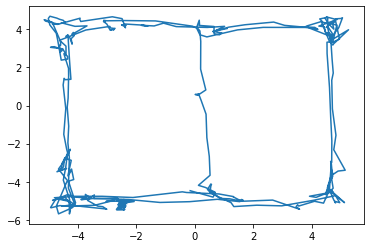

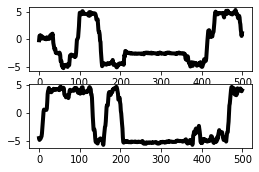

In [3]:
factor_dim = 2

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)

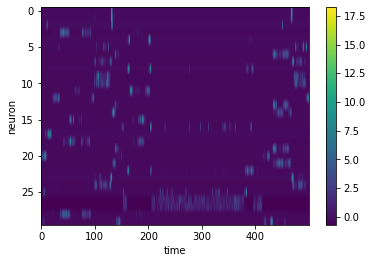

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        #self.dense_output = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        #xo = self.dense_output(x)
        xo = self.dense_output2(x)
        #xo = 5*tf.exp(tf.nn.tanh(self.dense_output2(xo)))
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 64
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=32,
                             num_gru_unit=32,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,10)

In [15]:
epochs = 2800

for i,kl_ in enumerate(KL_penalty):
    print(kl_,i)
    if i > 8:
        break
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,),'i',i)

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                #print("loss",loss,"kl",sum(vae.losses))
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

0.0 0
Start of epoch 0 i 0
step 0: mean loss = 1.0002652
Start of epoch 1 i 0
step 0: mean loss = 1.0002954
Start of epoch 2 i 0
step 0: mean loss = 1.00026
Start of epoch 3 i 0
step 0: mean loss = 1.0001892
Start of epoch 4 i 0
step 0: mean loss = 1.0002594
Start of epoch 5 i 0
step 0: mean loss = 1.0002697
Start of epoch 6 i 0
step 0: mean loss = 1.0002378
Start of epoch 7 i 0
step 0: mean loss = 1.0002149
Start of epoch 8 i 0
step 0: mean loss = 1.0001923
Start of epoch 9 i 0
step 0: mean loss = 1.0001702
Start of epoch 10 i 0
step 0: mean loss = 1.0002158
Start of epoch 11 i 0
step 0: mean loss = 1.0002202
Start of epoch 12 i 0
step 0: mean loss = 1.0002079
Start of epoch 13 i 0
step 0: mean loss = 1.0001897
Start of epoch 14 i 0
step 0: mean loss = 1.0001954
Start of epoch 15 i 0
step 0: mean loss = 1.0001816
Start of epoch 16 i 0
step 0: mean loss = 1.0001758
Start of epoch 17 i 0
step 0: mean loss = 1.0001657
Start of epoch 18 i 0
step 0: mean loss = 1.0001535
Start of epoch 19 

step 0: mean loss = 0.9966908
Start of epoch 157 i 0
step 0: mean loss = 0.996633
Start of epoch 158 i 0
step 0: mean loss = 0.99657553
Start of epoch 159 i 0
step 0: mean loss = 0.9965169
Start of epoch 160 i 0
step 0: mean loss = 0.9964579
Start of epoch 161 i 0
step 0: mean loss = 0.99639827
Start of epoch 162 i 0
step 0: mean loss = 0.99633837
Start of epoch 163 i 0
step 0: mean loss = 0.9962785
Start of epoch 164 i 0
step 0: mean loss = 0.99621767
Start of epoch 165 i 0
step 0: mean loss = 0.9961565
Start of epoch 166 i 0
step 0: mean loss = 0.9960955
Start of epoch 167 i 0
step 0: mean loss = 0.9960339
Start of epoch 168 i 0
step 0: mean loss = 0.9959718
Start of epoch 169 i 0
step 0: mean loss = 0.9959096
Start of epoch 170 i 0
step 0: mean loss = 0.9958473
Start of epoch 171 i 0
step 0: mean loss = 0.9957845
Start of epoch 172 i 0
step 0: mean loss = 0.99572134
Start of epoch 173 i 0
step 0: mean loss = 0.9956579
Start of epoch 174 i 0
step 0: mean loss = 0.9955942
Start of epo

step 0: mean loss = 0.9878977
Start of epoch 311 i 0
step 0: mean loss = 0.9878508
Start of epoch 312 i 0
step 0: mean loss = 0.98780435
Start of epoch 313 i 0
step 0: mean loss = 0.98775846
Start of epoch 314 i 0
step 0: mean loss = 0.98771226
Start of epoch 315 i 0
step 0: mean loss = 0.98766667
Start of epoch 316 i 0
step 0: mean loss = 0.987622
Start of epoch 317 i 0
step 0: mean loss = 0.9875762
Start of epoch 318 i 0
step 0: mean loss = 0.9875311
Start of epoch 319 i 0
step 0: mean loss = 0.9874859
Start of epoch 320 i 0
step 0: mean loss = 0.9874407
Start of epoch 321 i 0
step 0: mean loss = 0.98739564
Start of epoch 322 i 0
step 0: mean loss = 0.987351
Start of epoch 323 i 0
step 0: mean loss = 0.9873065
Start of epoch 324 i 0
step 0: mean loss = 0.9872618
Start of epoch 325 i 0
step 0: mean loss = 0.98721725
Start of epoch 326 i 0
step 0: mean loss = 0.987173
Start of epoch 327 i 0
step 0: mean loss = 0.9871302
Start of epoch 328 i 0
step 0: mean loss = 0.98708636
Start of epo

step 0: mean loss = 0.97730243
Start of epoch 465 i 0
step 0: mean loss = 0.9772066
Start of epoch 466 i 0
step 0: mean loss = 0.9771105
Start of epoch 467 i 0
step 0: mean loss = 0.9770147
Start of epoch 468 i 0
step 0: mean loss = 0.9769189
Start of epoch 469 i 0
step 0: mean loss = 0.97682333
Start of epoch 470 i 0
step 0: mean loss = 0.97672784
Start of epoch 471 i 0
step 0: mean loss = 0.9766328
Start of epoch 472 i 0
step 0: mean loss = 0.9765377
Start of epoch 473 i 0
step 0: mean loss = 0.97644275
Start of epoch 474 i 0
step 0: mean loss = 0.97634774
Start of epoch 475 i 0
step 0: mean loss = 0.97625285
Start of epoch 476 i 0
step 0: mean loss = 0.97615826
Start of epoch 477 i 0
step 0: mean loss = 0.97606355
Start of epoch 478 i 0
step 0: mean loss = 0.9759694
Start of epoch 479 i 0
step 0: mean loss = 0.97587484
Start of epoch 480 i 0
step 0: mean loss = 0.97578096
Start of epoch 481 i 0
step 0: mean loss = 0.97568685
Start of epoch 482 i 0
step 0: mean loss = 0.9755933
Start

step 0: mean loss = 0.964524
Start of epoch 619 i 0
step 0: mean loss = 0.964486
Start of epoch 620 i 0
step 0: mean loss = 0.96444905
Start of epoch 621 i 0
step 0: mean loss = 0.9644115
Start of epoch 622 i 0
step 0: mean loss = 0.9643719
Start of epoch 623 i 0
step 0: mean loss = 0.9643308
Start of epoch 624 i 0
step 0: mean loss = 0.9642894
Start of epoch 625 i 0
step 0: mean loss = 0.96424663
Start of epoch 626 i 0
step 0: mean loss = 0.96420175
Start of epoch 627 i 0
step 0: mean loss = 0.9641563
Start of epoch 628 i 0
step 0: mean loss = 0.9641107
Start of epoch 629 i 0
step 0: mean loss = 0.96406335
Start of epoch 630 i 0
step 0: mean loss = 0.96401453
Start of epoch 631 i 0
step 0: mean loss = 0.9639655
Start of epoch 632 i 0
step 0: mean loss = 0.9639154
Start of epoch 633 i 0
step 0: mean loss = 0.96386534
Start of epoch 634 i 0
step 0: mean loss = 0.9638143
Start of epoch 635 i 0
step 0: mean loss = 0.96376467
Start of epoch 636 i 0
step 0: mean loss = 0.9637132
Start of ep

step 0: mean loss = 0.9575033
Start of epoch 773 i 0
step 0: mean loss = 0.9574645
Start of epoch 774 i 0
step 0: mean loss = 0.9574257
Start of epoch 775 i 0
step 0: mean loss = 0.9573871
Start of epoch 776 i 0
step 0: mean loss = 0.9573485
Start of epoch 777 i 0
step 0: mean loss = 0.9573101
Start of epoch 778 i 0
step 0: mean loss = 0.9572717
Start of epoch 779 i 0
step 0: mean loss = 0.95723337
Start of epoch 780 i 0
step 0: mean loss = 0.9571951
Start of epoch 781 i 0
step 0: mean loss = 0.957157
Start of epoch 782 i 0
step 0: mean loss = 0.9571189
Start of epoch 783 i 0
step 0: mean loss = 0.9570811
Start of epoch 784 i 0
step 0: mean loss = 0.9570435
Start of epoch 785 i 0
step 0: mean loss = 0.9570058
Start of epoch 786 i 0
step 0: mean loss = 0.95696807
Start of epoch 787 i 0
step 0: mean loss = 0.95693046
Start of epoch 788 i 0
step 0: mean loss = 0.9568929
Start of epoch 789 i 0
step 0: mean loss = 0.9568555
Start of epoch 790 i 0
step 0: mean loss = 0.9568182
Start of epoch

step 0: mean loss = 0.9524605
Start of epoch 927 i 0
step 0: mean loss = 0.952433
Start of epoch 928 i 0
step 0: mean loss = 0.95240545
Start of epoch 929 i 0
step 0: mean loss = 0.95237803
Start of epoch 930 i 0
step 0: mean loss = 0.9523507
Start of epoch 931 i 0
step 0: mean loss = 0.9523234
Start of epoch 932 i 0
step 0: mean loss = 0.9522961
Start of epoch 933 i 0
step 0: mean loss = 0.9522689
Start of epoch 934 i 0
step 0: mean loss = 0.9522417
Start of epoch 935 i 0
step 0: mean loss = 0.9522146
Start of epoch 936 i 0
step 0: mean loss = 0.9521876
Start of epoch 937 i 0
step 0: mean loss = 0.9521606
Start of epoch 938 i 0
step 0: mean loss = 0.9521336
Start of epoch 939 i 0
step 0: mean loss = 0.9521069
Start of epoch 940 i 0
step 0: mean loss = 0.95208
Start of epoch 941 i 0
step 0: mean loss = 0.95205325
Start of epoch 942 i 0
step 0: mean loss = 0.95202667
Start of epoch 943 i 0
step 0: mean loss = 0.95199996
Start of epoch 944 i 0
step 0: mean loss = 0.9519735
Start of epoch

step 0: mean loss = 0.9488106
Start of epoch 1080 i 0
step 0: mean loss = 0.94878995
Start of epoch 1081 i 0
step 0: mean loss = 0.9487695
Start of epoch 1082 i 0
step 0: mean loss = 0.94874895
Start of epoch 1083 i 0
step 0: mean loss = 0.94872844
Start of epoch 1084 i 0
step 0: mean loss = 0.94870794
Start of epoch 1085 i 0
step 0: mean loss = 0.94868755
Start of epoch 1086 i 0
step 0: mean loss = 0.9486671
Start of epoch 1087 i 0
step 0: mean loss = 0.9486468
Start of epoch 1088 i 0
step 0: mean loss = 0.94862646
Start of epoch 1089 i 0
step 0: mean loss = 0.9486061
Start of epoch 1090 i 0
step 0: mean loss = 0.9485858
Start of epoch 1091 i 0
step 0: mean loss = 0.9485656
Start of epoch 1092 i 0
step 0: mean loss = 0.9485454
Start of epoch 1093 i 0
step 0: mean loss = 0.94852513
Start of epoch 1094 i 0
step 0: mean loss = 0.9485049
Start of epoch 1095 i 0
step 0: mean loss = 0.9484849
Start of epoch 1096 i 0
step 0: mean loss = 0.9484649
Start of epoch 1097 i 0
step 0: mean loss = 0

step 0: mean loss = 0.9460606
Start of epoch 1231 i 0
step 0: mean loss = 0.9460445
Start of epoch 1232 i 0
step 0: mean loss = 0.9460285
Start of epoch 1233 i 0
step 0: mean loss = 0.9460125
Start of epoch 1234 i 0
step 0: mean loss = 0.94599646
Start of epoch 1235 i 0
step 0: mean loss = 0.94598055
Start of epoch 1236 i 0
step 0: mean loss = 0.9459646
Start of epoch 1237 i 0
step 0: mean loss = 0.94594866
Start of epoch 1238 i 0
step 0: mean loss = 0.9459328
Start of epoch 1239 i 0
step 0: mean loss = 0.94591695
Start of epoch 1240 i 0
step 0: mean loss = 0.9459011
Start of epoch 1241 i 0
step 0: mean loss = 0.9458853
Start of epoch 1242 i 0
step 0: mean loss = 0.9458695
Start of epoch 1243 i 0
step 0: mean loss = 0.94585377
Start of epoch 1244 i 0
step 0: mean loss = 0.94583803
Start of epoch 1245 i 0
step 0: mean loss = 0.94582236
Start of epoch 1246 i 0
step 0: mean loss = 0.9458067
Start of epoch 1247 i 0
step 0: mean loss = 0.945791
Start of epoch 1248 i 0
step 0: mean loss = 0.

step 0: mean loss = 0.943888
Start of epoch 1382 i 0
step 0: mean loss = 0.94387513
Start of epoch 1383 i 0
step 0: mean loss = 0.9438622
Start of epoch 1384 i 0
step 0: mean loss = 0.9438493
Start of epoch 1385 i 0
step 0: mean loss = 0.94383645
Start of epoch 1386 i 0
step 0: mean loss = 0.9438237
Start of epoch 1387 i 0
step 0: mean loss = 0.9438109
Start of epoch 1388 i 0
step 0: mean loss = 0.94379807
Start of epoch 1389 i 0
step 0: mean loss = 0.9437853
Start of epoch 1390 i 0
step 0: mean loss = 0.94377255
Start of epoch 1391 i 0
step 0: mean loss = 0.9437598
Start of epoch 1392 i 0
step 0: mean loss = 0.94374704
Start of epoch 1393 i 0
step 0: mean loss = 0.94373435
Start of epoch 1394 i 0
step 0: mean loss = 0.94372165
Start of epoch 1395 i 0
step 0: mean loss = 0.94370896
Start of epoch 1396 i 0
step 0: mean loss = 0.9436963
Start of epoch 1397 i 0
step 0: mean loss = 0.9436837
Start of epoch 1398 i 0
step 0: mean loss = 0.94367105
Start of epoch 1399 i 0
step 0: mean loss = 

step 0: mean loss = 0.94212395
Start of epoch 1533 i 0
step 0: mean loss = 0.9421133
Start of epoch 1534 i 0
step 0: mean loss = 0.94210273
Start of epoch 1535 i 0
step 0: mean loss = 0.9420922
Start of epoch 1536 i 0
step 0: mean loss = 0.94208163
Start of epoch 1537 i 0
step 0: mean loss = 0.94207114
Start of epoch 1538 i 0
step 0: mean loss = 0.94206053
Start of epoch 1539 i 0
step 0: mean loss = 0.94205004
Start of epoch 1540 i 0
step 0: mean loss = 0.94203955
Start of epoch 1541 i 0
step 0: mean loss = 0.94202906
Start of epoch 1542 i 0
step 0: mean loss = 0.94201857
Start of epoch 1543 i 0
step 0: mean loss = 0.9420081
Start of epoch 1544 i 0
step 0: mean loss = 0.94199765
Start of epoch 1545 i 0
step 0: mean loss = 0.9419872
Start of epoch 1546 i 0
step 0: mean loss = 0.9419767
Start of epoch 1547 i 0
step 0: mean loss = 0.94196635
Start of epoch 1548 i 0
step 0: mean loss = 0.9419559
Start of epoch 1549 i 0
step 0: mean loss = 0.9419455
Start of epoch 1550 i 0
step 0: mean loss

step 0: mean loss = 0.9406496
Start of epoch 1684 i 0
step 0: mean loss = 0.9406406
Start of epoch 1685 i 0
step 0: mean loss = 0.9406317
Start of epoch 1686 i 0
step 0: mean loss = 0.94062275
Start of epoch 1687 i 0
step 0: mean loss = 0.9406138
Start of epoch 1688 i 0
step 0: mean loss = 0.94060487
Start of epoch 1689 i 0
step 0: mean loss = 0.940596
Start of epoch 1690 i 0
step 0: mean loss = 0.94058704
Start of epoch 1691 i 0
step 0: mean loss = 0.94057816
Start of epoch 1692 i 0
step 0: mean loss = 0.9405693
Start of epoch 1693 i 0
step 0: mean loss = 0.9405604
Start of epoch 1694 i 0
step 0: mean loss = 0.9405515
Start of epoch 1695 i 0
step 0: mean loss = 0.9405427
Start of epoch 1696 i 0
step 0: mean loss = 0.9405338
Start of epoch 1697 i 0
step 0: mean loss = 0.940525
Start of epoch 1698 i 0
step 0: mean loss = 0.9405162
Start of epoch 1699 i 0
step 0: mean loss = 0.9405073
Start of epoch 1700 i 0
step 0: mean loss = 0.94049853
Start of epoch 1701 i 0
step 0: mean loss = 0.940

step 0: mean loss = 0.9393924
Start of epoch 1835 i 0
step 0: mean loss = 0.93938464
Start of epoch 1836 i 0
step 0: mean loss = 0.9393769
Start of epoch 1837 i 0
step 0: mean loss = 0.93936926
Start of epoch 1838 i 0
step 0: mean loss = 0.9393615
Start of epoch 1839 i 0
step 0: mean loss = 0.9393539
Start of epoch 1840 i 0
step 0: mean loss = 0.93934625
Start of epoch 1841 i 0
step 0: mean loss = 0.9393386
Start of epoch 1842 i 0
step 0: mean loss = 0.939331
Start of epoch 1843 i 0
step 0: mean loss = 0.9393233
Start of epoch 1844 i 0
step 0: mean loss = 0.9393157
Start of epoch 1845 i 0
step 0: mean loss = 0.93930805
Start of epoch 1846 i 0
step 0: mean loss = 0.9393005
Start of epoch 1847 i 0
step 0: mean loss = 0.9392928
Start of epoch 1848 i 0
step 0: mean loss = 0.93928516
Start of epoch 1849 i 0
step 0: mean loss = 0.9392775
Start of epoch 1850 i 0
step 0: mean loss = 0.9392699
Start of epoch 1851 i 0
step 0: mean loss = 0.93926233
Start of epoch 1852 i 0
step 0: mean loss = 0.9

step 0: mean loss = 0.9382923
Start of epoch 1987 i 0
step 0: mean loss = 0.9382854
Start of epoch 1988 i 0
step 0: mean loss = 0.9382785
Start of epoch 1989 i 0
step 0: mean loss = 0.93827164
Start of epoch 1990 i 0
step 0: mean loss = 0.9382647
Start of epoch 1991 i 0
step 0: mean loss = 0.9382579
Start of epoch 1992 i 0
step 0: mean loss = 0.93825096
Start of epoch 1993 i 0
step 0: mean loss = 0.9382441
Start of epoch 1994 i 0
step 0: mean loss = 0.9382373
Start of epoch 1995 i 0
step 0: mean loss = 0.93823045
Start of epoch 1996 i 0
step 0: mean loss = 0.9382236
Start of epoch 1997 i 0
step 0: mean loss = 0.9382168
Start of epoch 1998 i 0
step 0: mean loss = 0.9382099
Start of epoch 1999 i 0
step 0: mean loss = 0.938203
Start of epoch 2000 i 0
step 0: mean loss = 0.9381962
Start of epoch 2001 i 0
step 0: mean loss = 0.9381893
Start of epoch 2002 i 0
step 0: mean loss = 0.9381825
Start of epoch 2003 i 0
step 0: mean loss = 0.9381756
Start of epoch 2004 i 0
step 0: mean loss = 0.9381

step 0: mean loss = 0.9372507
Start of epoch 2138 i 0
step 0: mean loss = 0.93724364
Start of epoch 2139 i 0
step 0: mean loss = 0.9372366
Start of epoch 2140 i 0
step 0: mean loss = 0.93722963
Start of epoch 2141 i 0
step 0: mean loss = 0.9372226
Start of epoch 2142 i 0
step 0: mean loss = 0.9372155
Start of epoch 2143 i 0
step 0: mean loss = 0.9372085
Start of epoch 2144 i 0
step 0: mean loss = 0.93720144
Start of epoch 2145 i 0
step 0: mean loss = 0.93719435
Start of epoch 2146 i 0
step 0: mean loss = 0.9371874
Start of epoch 2147 i 0
step 0: mean loss = 0.9371803
Start of epoch 2148 i 0
step 0: mean loss = 0.9371732
Start of epoch 2149 i 0
step 0: mean loss = 0.9371661
Start of epoch 2150 i 0
step 0: mean loss = 0.937159
Start of epoch 2151 i 0
step 0: mean loss = 0.9371519
Start of epoch 2152 i 0
step 0: mean loss = 0.9371448
Start of epoch 2153 i 0
step 0: mean loss = 0.9371377
Start of epoch 2154 i 0
step 0: mean loss = 0.9371306
Start of epoch 2155 i 0
step 0: mean loss = 0.937

step 0: mean loss = 0.9359704
Start of epoch 2289 i 0
step 0: mean loss = 0.93596
Start of epoch 2290 i 0
step 0: mean loss = 0.93594956
Start of epoch 2291 i 0
step 0: mean loss = 0.9359392
Start of epoch 2292 i 0
step 0: mean loss = 0.93592876
Start of epoch 2293 i 0
step 0: mean loss = 0.9359183
Start of epoch 2294 i 0
step 0: mean loss = 0.9359079
Start of epoch 2295 i 0
step 0: mean loss = 0.93589747
Start of epoch 2296 i 0
step 0: mean loss = 0.935887
Start of epoch 2297 i 0
step 0: mean loss = 0.93587655
Start of epoch 2298 i 0
step 0: mean loss = 0.9358661
Start of epoch 2299 i 0
step 0: mean loss = 0.9358557
Start of epoch 2300 i 0
step 0: mean loss = 0.93584526
Start of epoch 2301 i 0
step 0: mean loss = 0.9358348
Start of epoch 2302 i 0
step 0: mean loss = 0.9358244
Start of epoch 2303 i 0
step 0: mean loss = 0.9358139
Start of epoch 2304 i 0
step 0: mean loss = 0.9358034
Start of epoch 2305 i 0
step 0: mean loss = 0.9357929
Start of epoch 2306 i 0
step 0: mean loss = 0.9357

step 0: mean loss = 0.935187
Start of epoch 2440 i 0
step 0: mean loss = 0.93518114
Start of epoch 2441 i 0
step 0: mean loss = 0.9351752
Start of epoch 2442 i 0
step 0: mean loss = 0.9351692
Start of epoch 2443 i 0
step 0: mean loss = 0.93516326
Start of epoch 2444 i 0
step 0: mean loss = 0.93515736
Start of epoch 2445 i 0
step 0: mean loss = 0.9351514
Start of epoch 2446 i 0
step 0: mean loss = 0.9351455
Start of epoch 2447 i 0
step 0: mean loss = 0.9351396
Start of epoch 2448 i 0
step 0: mean loss = 0.93513364
Start of epoch 2449 i 0
step 0: mean loss = 0.93512774
Start of epoch 2450 i 0
step 0: mean loss = 0.9351218
Start of epoch 2451 i 0
step 0: mean loss = 0.93511575
Start of epoch 2452 i 0
step 0: mean loss = 0.93510973
Start of epoch 2453 i 0
step 0: mean loss = 0.9351038
Start of epoch 2454 i 0
step 0: mean loss = 0.93509775
Start of epoch 2455 i 0
step 0: mean loss = 0.9350918
Start of epoch 2456 i 0
step 0: mean loss = 0.93508583
Start of epoch 2457 i 0
step 0: mean loss = 

step 0: mean loss = 0.93413734
Start of epoch 2591 i 0
step 0: mean loss = 0.93412834
Start of epoch 2592 i 0
step 0: mean loss = 0.9341194
Start of epoch 2593 i 0
step 0: mean loss = 0.93411034
Start of epoch 2594 i 0
step 0: mean loss = 0.93410134
Start of epoch 2595 i 0
step 0: mean loss = 0.9340923
Start of epoch 2596 i 0
step 0: mean loss = 0.9340833
Start of epoch 2597 i 0
step 0: mean loss = 0.93407416
Start of epoch 2598 i 0
step 0: mean loss = 0.93406504
Start of epoch 2599 i 0
step 0: mean loss = 0.9340559
Start of epoch 2600 i 0
step 0: mean loss = 0.9340468
Start of epoch 2601 i 0
step 0: mean loss = 0.9340376
Start of epoch 2602 i 0
step 0: mean loss = 0.93402845
Start of epoch 2603 i 0
step 0: mean loss = 0.9340193
Start of epoch 2604 i 0
step 0: mean loss = 0.93401
Start of epoch 2605 i 0
step 0: mean loss = 0.9340008
Start of epoch 2606 i 0
step 0: mean loss = 0.93399155
Start of epoch 2607 i 0
step 0: mean loss = 0.9339823
Start of epoch 2608 i 0
step 0: mean loss = 0.

step 0: mean loss = 0.932688
Start of epoch 2742 i 0
step 0: mean loss = 0.93267816
Start of epoch 2743 i 0
step 0: mean loss = 0.9326683
Start of epoch 2744 i 0
step 0: mean loss = 0.93265855
Start of epoch 2745 i 0
step 0: mean loss = 0.9326488
Start of epoch 2746 i 0
step 0: mean loss = 0.93263894
Start of epoch 2747 i 0
step 0: mean loss = 0.93262917
Start of epoch 2748 i 0
step 0: mean loss = 0.9326194
Start of epoch 2749 i 0
step 0: mean loss = 0.93260956
Start of epoch 2750 i 0
step 0: mean loss = 0.9325998
Start of epoch 2751 i 0
step 0: mean loss = 0.93258995
Start of epoch 2752 i 0
step 0: mean loss = 0.9325801
Start of epoch 2753 i 0
step 0: mean loss = 0.9325703
Start of epoch 2754 i 0
step 0: mean loss = 0.93256044
Start of epoch 2755 i 0
step 0: mean loss = 0.93255067
Start of epoch 2756 i 0
step 0: mean loss = 0.93254083
Start of epoch 2757 i 0
step 0: mean loss = 0.93253106
Start of epoch 2758 i 0
step 0: mean loss = 0.9325213
Start of epoch 2759 i 0
step 0: mean loss =

step 0: mean loss = 0.941539
Start of epoch 97 i 1
step 0: mean loss = 0.94154996
Start of epoch 98 i 1
step 0: mean loss = 0.94155836
Start of epoch 99 i 1
step 0: mean loss = 0.9415691
Start of epoch 100 i 1
step 0: mean loss = 0.9415807
Start of epoch 101 i 1
step 0: mean loss = 0.941597
Start of epoch 102 i 1
step 0: mean loss = 0.94160783
Start of epoch 103 i 1
step 0: mean loss = 0.941634
Start of epoch 104 i 1
step 0: mean loss = 0.9416488
Start of epoch 105 i 1
step 0: mean loss = 0.94165814
Start of epoch 106 i 1
step 0: mean loss = 0.9416683
Start of epoch 107 i 1
step 0: mean loss = 0.9416783
Start of epoch 108 i 1
step 0: mean loss = 0.94169027
Start of epoch 109 i 1
step 0: mean loss = 0.94170064
Start of epoch 110 i 1
step 0: mean loss = 0.94171
Start of epoch 111 i 1
step 0: mean loss = 0.9417228
Start of epoch 112 i 1
step 0: mean loss = 0.94173145
Start of epoch 113 i 1
step 0: mean loss = 0.941739
Start of epoch 114 i 1
step 0: mean loss = 0.9417484
Start of epoch 115

step 0: mean loss = 0.94252133
Start of epoch 251 i 1
step 0: mean loss = 0.9425222
Start of epoch 252 i 1
step 0: mean loss = 0.9425242
Start of epoch 253 i 1
step 0: mean loss = 0.9425328
Start of epoch 254 i 1
step 0: mean loss = 0.9425336
Start of epoch 255 i 1
step 0: mean loss = 0.9425354
Start of epoch 256 i 1
step 0: mean loss = 0.94253576
Start of epoch 257 i 1
step 0: mean loss = 0.9425377
Start of epoch 258 i 1
step 0: mean loss = 0.94254076
Start of epoch 259 i 1
step 0: mean loss = 0.9425432
Start of epoch 260 i 1
step 0: mean loss = 0.9425451
Start of epoch 261 i 1
step 0: mean loss = 0.94254667
Start of epoch 262 i 1
step 0: mean loss = 0.9425478
Start of epoch 263 i 1
step 0: mean loss = 0.942553
Start of epoch 264 i 1
step 0: mean loss = 0.94255346
Start of epoch 265 i 1
step 0: mean loss = 0.9425544
Start of epoch 266 i 1
step 0: mean loss = 0.9425558
Start of epoch 267 i 1
step 0: mean loss = 0.94255626
Start of epoch 268 i 1
step 0: mean loss = 0.942558
Start of epo

step 0: mean loss = 0.9425798
Start of epoch 405 i 1
step 0: mean loss = 0.9425776
Start of epoch 406 i 1
step 0: mean loss = 0.9425773
Start of epoch 407 i 1
step 0: mean loss = 0.9425739
Start of epoch 408 i 1
step 0: mean loss = 0.9425711
Start of epoch 409 i 1
step 0: mean loss = 0.9425691
Start of epoch 410 i 1
step 0: mean loss = 0.9425651
Start of epoch 411 i 1
step 0: mean loss = 0.9425678
Start of epoch 412 i 1
step 0: mean loss = 0.94256496
Start of epoch 413 i 1
step 0: mean loss = 0.9425618
Start of epoch 414 i 1
step 0: mean loss = 0.9425583
Start of epoch 415 i 1
step 0: mean loss = 0.9425548
Start of epoch 416 i 1
step 0: mean loss = 0.9425513
Start of epoch 417 i 1
step 0: mean loss = 0.94254845
Start of epoch 418 i 1
step 0: mean loss = 0.9425457
Start of epoch 419 i 1
step 0: mean loss = 0.94254506
Start of epoch 420 i 1
step 0: mean loss = 0.94254196
Start of epoch 421 i 1
step 0: mean loss = 0.9425386
Start of epoch 422 i 1
step 0: mean loss = 0.94255376
Start of ep

step 0: mean loss = 0.94228166
Start of epoch 559 i 1
step 0: mean loss = 0.94227856
Start of epoch 560 i 1
step 0: mean loss = 0.9422738
Start of epoch 561 i 1
step 0: mean loss = 0.942274
Start of epoch 562 i 1
step 0: mean loss = 0.94227237
Start of epoch 563 i 1
step 0: mean loss = 0.94226766
Start of epoch 564 i 1
step 0: mean loss = 0.942263
Start of epoch 565 i 1
step 0: mean loss = 0.94226253
Start of epoch 566 i 1
step 0: mean loss = 0.94225854
Start of epoch 567 i 1
step 0: mean loss = 0.94225425
Start of epoch 568 i 1
step 0: mean loss = 0.9422502
Start of epoch 569 i 1
step 0: mean loss = 0.94225657
Start of epoch 570 i 1
step 0: mean loss = 0.9422518
Start of epoch 571 i 1
step 0: mean loss = 0.9422486
Start of epoch 572 i 1
step 0: mean loss = 0.9422448
Start of epoch 573 i 1
step 0: mean loss = 0.94224125
Start of epoch 574 i 1
step 0: mean loss = 0.9422395
Start of epoch 575 i 1
step 0: mean loss = 0.942237
Start of epoch 576 i 1
step 0: mean loss = 0.942236
Start of ep

step 0: mean loss = 0.94192356
Start of epoch 713 i 1
step 0: mean loss = 0.94191927
Start of epoch 714 i 1
step 0: mean loss = 0.9419177
Start of epoch 715 i 1
step 0: mean loss = 0.94191426
Start of epoch 716 i 1
step 0: mean loss = 0.9419109
Start of epoch 717 i 1
step 0: mean loss = 0.9419061
Start of epoch 718 i 1
step 0: mean loss = 0.94190115
Start of epoch 719 i 1
step 0: mean loss = 0.9418969
Start of epoch 720 i 1
step 0: mean loss = 0.94189197
Start of epoch 721 i 1
step 0: mean loss = 0.94188714
Start of epoch 722 i 1
step 0: mean loss = 0.94188255
Start of epoch 723 i 1
step 0: mean loss = 0.94187796
Start of epoch 724 i 1
step 0: mean loss = 0.94187284
Start of epoch 725 i 1
step 0: mean loss = 0.9418688
Start of epoch 726 i 1
step 0: mean loss = 0.94186366
Start of epoch 727 i 1
step 0: mean loss = 0.94185877
Start of epoch 728 i 1
step 0: mean loss = 0.94185364
Start of epoch 729 i 1
step 0: mean loss = 0.9418495
Start of epoch 730 i 1
step 0: mean loss = 0.94184685
Sta

step 0: mean loss = 0.94226974
Start of epoch 867 i 1
step 0: mean loss = 0.9422725
Start of epoch 868 i 1
step 0: mean loss = 0.942275
Start of epoch 869 i 1
step 0: mean loss = 0.9422776
Start of epoch 870 i 1
step 0: mean loss = 0.942281
Start of epoch 871 i 1
step 0: mean loss = 0.94231015
Start of epoch 872 i 1
step 0: mean loss = 0.9423125
Start of epoch 873 i 1
step 0: mean loss = 0.9423142
Start of epoch 874 i 1
step 0: mean loss = 0.9423179
Start of epoch 875 i 1
step 0: mean loss = 0.9423194
Start of epoch 876 i 1
step 0: mean loss = 0.9423454
Start of epoch 877 i 1
step 0: mean loss = 0.94234776
Start of epoch 878 i 1
step 0: mean loss = 0.9423506
Start of epoch 879 i 1
step 0: mean loss = 0.9423535
Start of epoch 880 i 1
step 0: mean loss = 0.94235456
Start of epoch 881 i 1
step 0: mean loss = 0.9423564
Start of epoch 882 i 1
step 0: mean loss = 0.9423579
Start of epoch 883 i 1
step 0: mean loss = 0.9423592
Start of epoch 884 i 1
step 0: mean loss = 0.94236034
Start of epoc

step 0: mean loss = 0.9425602
Start of epoch 1021 i 1
step 0: mean loss = 0.94255936
Start of epoch 1022 i 1
step 0: mean loss = 0.9425608
Start of epoch 1023 i 1
step 0: mean loss = 0.9425644
Start of epoch 1024 i 1
step 0: mean loss = 0.9425642
Start of epoch 1025 i 1
step 0: mean loss = 0.9425645
Start of epoch 1026 i 1
step 0: mean loss = 0.9425637
Start of epoch 1027 i 1
step 0: mean loss = 0.9425653
Start of epoch 1028 i 1
step 0: mean loss = 0.94256467
Start of epoch 1029 i 1
step 0: mean loss = 0.94256413
Start of epoch 1030 i 1
step 0: mean loss = 0.9425658
Start of epoch 1031 i 1
step 0: mean loss = 0.9425652
Start of epoch 1032 i 1
step 0: mean loss = 0.9425644
Start of epoch 1033 i 1
step 0: mean loss = 0.94256383
Start of epoch 1034 i 1
step 0: mean loss = 0.9425635
Start of epoch 1035 i 1
step 0: mean loss = 0.94256437
Start of epoch 1036 i 1
step 0: mean loss = 0.9425668
Start of epoch 1037 i 1
step 0: mean loss = 0.9425666
Start of epoch 1038 i 1
step 0: mean loss = 0.9

step 0: mean loss = 0.9425977
Start of epoch 1172 i 1
step 0: mean loss = 0.94259685
Start of epoch 1173 i 1
step 0: mean loss = 0.9425966
Start of epoch 1174 i 1
step 0: mean loss = 0.9425954
Start of epoch 1175 i 1
step 0: mean loss = 0.942594
Start of epoch 1176 i 1
step 0: mean loss = 0.94259274
Start of epoch 1177 i 1
step 0: mean loss = 0.9425917
Start of epoch 1178 i 1
step 0: mean loss = 0.94259125
Start of epoch 1179 i 1
step 0: mean loss = 0.9425913
Start of epoch 1180 i 1
step 0: mean loss = 0.9425899
Start of epoch 1181 i 1
step 0: mean loss = 0.9425888
Start of epoch 1182 i 1
step 0: mean loss = 0.9425887
Start of epoch 1183 i 1
step 0: mean loss = 0.94258827
Start of epoch 1184 i 1
step 0: mean loss = 0.9425878
Start of epoch 1185 i 1
step 0: mean loss = 0.94258684
Start of epoch 1186 i 1
step 0: mean loss = 0.9425864
Start of epoch 1187 i 1
step 0: mean loss = 0.94258565
Start of epoch 1188 i 1
step 0: mean loss = 0.94258434
Start of epoch 1189 i 1
step 0: mean loss = 0.

step 0: mean loss = 0.94310606
Start of epoch 1323 i 1
step 0: mean loss = 0.9431117
Start of epoch 1324 i 1
step 0: mean loss = 0.94311833
Start of epoch 1325 i 1
step 0: mean loss = 0.9431237
Start of epoch 1326 i 1
step 0: mean loss = 0.9431288
Start of epoch 1327 i 1
step 0: mean loss = 0.9431338
Start of epoch 1328 i 1
step 0: mean loss = 0.9431394
Start of epoch 1329 i 1
step 0: mean loss = 0.9431443
Start of epoch 1330 i 1
step 0: mean loss = 0.9431487
Start of epoch 1331 i 1
step 0: mean loss = 0.9431528
Start of epoch 1332 i 1
step 0: mean loss = 0.9431577
Start of epoch 1333 i 1
step 0: mean loss = 0.9431623
Start of epoch 1334 i 1
step 0: mean loss = 0.94316703
Start of epoch 1335 i 1
step 0: mean loss = 0.94317067
Start of epoch 1336 i 1
step 0: mean loss = 0.94317406
Start of epoch 1337 i 1
step 0: mean loss = 0.94317776
Start of epoch 1338 i 1
step 0: mean loss = 0.9431973
Start of epoch 1339 i 1
step 0: mean loss = 0.94320065
Start of epoch 1340 i 1
step 0: mean loss = 0

step 0: mean loss = 0.94358313
Start of epoch 1475 i 1
step 0: mean loss = 0.9435845
Start of epoch 1476 i 1
step 0: mean loss = 0.9435864
Start of epoch 1477 i 1
step 0: mean loss = 0.9435882
Start of epoch 1478 i 1
step 0: mean loss = 0.9435902
Start of epoch 1479 i 1
step 0: mean loss = 0.94359255
Start of epoch 1480 i 1
step 0: mean loss = 0.94359547
Start of epoch 1481 i 1
step 0: mean loss = 0.94359815
Start of epoch 1482 i 1
step 0: mean loss = 0.94360054
Start of epoch 1483 i 1
step 0: mean loss = 0.94360304
Start of epoch 1484 i 1
step 0: mean loss = 0.94360554
Start of epoch 1485 i 1
step 0: mean loss = 0.9436081
Start of epoch 1486 i 1
step 0: mean loss = 0.94361055
Start of epoch 1487 i 1
step 0: mean loss = 0.94361305
Start of epoch 1488 i 1
step 0: mean loss = 0.943616
Start of epoch 1489 i 1
step 0: mean loss = 0.94361836
Start of epoch 1490 i 1
step 0: mean loss = 0.94362146
Start of epoch 1491 i 1
step 0: mean loss = 0.9436241
Start of epoch 1492 i 1
step 0: mean loss 

step 0: mean loss = 0.9436599
Start of epoch 1626 i 1
step 0: mean loss = 0.94366014
Start of epoch 1627 i 1
step 0: mean loss = 0.94365907
Start of epoch 1628 i 1
step 0: mean loss = 0.943659
Start of epoch 1629 i 1
step 0: mean loss = 0.9436579
Start of epoch 1630 i 1
step 0: mean loss = 0.94365734
Start of epoch 1631 i 1
step 0: mean loss = 0.94365627
Start of epoch 1632 i 1
step 0: mean loss = 0.943655
Start of epoch 1633 i 1
step 0: mean loss = 0.9436602
Start of epoch 1634 i 1
step 0: mean loss = 0.94365937
Start of epoch 1635 i 1
step 0: mean loss = 0.94365853
Start of epoch 1636 i 1
step 0: mean loss = 0.9436573
Start of epoch 1637 i 1
step 0: mean loss = 0.94365656
Start of epoch 1638 i 1
step 0: mean loss = 0.94365585
Start of epoch 1639 i 1
step 0: mean loss = 0.94365495
Start of epoch 1640 i 1
step 0: mean loss = 0.9436538
Start of epoch 1641 i 1
step 0: mean loss = 0.94365245
Start of epoch 1642 i 1
step 0: mean loss = 0.94365114
Start of epoch 1643 i 1
step 0: mean loss =

step 0: mean loss = 0.94354725
Start of epoch 1777 i 1
step 0: mean loss = 0.943545
Start of epoch 1778 i 1
step 0: mean loss = 0.94354266
Start of epoch 1779 i 1
step 0: mean loss = 0.94355595
Start of epoch 1780 i 1
step 0: mean loss = 0.94355357
Start of epoch 1781 i 1
step 0: mean loss = 0.9435516
Start of epoch 1782 i 1
step 0: mean loss = 0.9435505
Start of epoch 1783 i 1
step 0: mean loss = 0.94354826
Start of epoch 1784 i 1
step 0: mean loss = 0.94355863
Start of epoch 1785 i 1
step 0: mean loss = 0.9435575
Start of epoch 1786 i 1
step 0: mean loss = 0.94356704
Start of epoch 1787 i 1
step 0: mean loss = 0.9435664
Start of epoch 1788 i 1
step 0: mean loss = 0.94356465
Start of epoch 1789 i 1
step 0: mean loss = 0.9435627
Start of epoch 1790 i 1
step 0: mean loss = 0.9435603
Start of epoch 1791 i 1
step 0: mean loss = 0.9435767
Start of epoch 1792 i 1
step 0: mean loss = 0.94357455
Start of epoch 1793 i 1
step 0: mean loss = 0.94357246
Start of epoch 1794 i 1
step 0: mean loss =

step 0: mean loss = 0.9435862
Start of epoch 1928 i 1
step 0: mean loss = 0.9435848
Start of epoch 1929 i 1
step 0: mean loss = 0.9435833
Start of epoch 1930 i 1
step 0: mean loss = 0.9435817
Start of epoch 1931 i 1
step 0: mean loss = 0.9435802
Start of epoch 1932 i 1
step 0: mean loss = 0.9435819
Start of epoch 1933 i 1
step 0: mean loss = 0.9435808
Start of epoch 1934 i 1
step 0: mean loss = 0.94358045
Start of epoch 1935 i 1
step 0: mean loss = 0.9435791
Start of epoch 1936 i 1
step 0: mean loss = 0.943579
Start of epoch 1937 i 1
step 0: mean loss = 0.9435806
Start of epoch 1938 i 1
step 0: mean loss = 0.9435807
Start of epoch 1939 i 1
step 0: mean loss = 0.9435791
Start of epoch 1940 i 1
step 0: mean loss = 0.94357955
Start of epoch 1941 i 1
step 0: mean loss = 0.9435788
Start of epoch 1942 i 1
step 0: mean loss = 0.9435777
Start of epoch 1943 i 1
step 0: mean loss = 0.94357663
Start of epoch 1944 i 1
step 0: mean loss = 0.9435758
Start of epoch 1945 i 1
step 0: mean loss = 0.9435

step 0: mean loss = 0.9434144
Start of epoch 2079 i 1
step 0: mean loss = 0.9434121
Start of epoch 2080 i 1
step 0: mean loss = 0.9434111
Start of epoch 2081 i 1
step 0: mean loss = 0.9434089
Start of epoch 2082 i 1
step 0: mean loss = 0.9434075
Start of epoch 2083 i 1
step 0: mean loss = 0.9434054
Start of epoch 2084 i 1
step 0: mean loss = 0.94340336
Start of epoch 2085 i 1
step 0: mean loss = 0.9434009
Start of epoch 2086 i 1
step 0: mean loss = 0.94339937
Start of epoch 2087 i 1
step 0: mean loss = 0.94339746
Start of epoch 2088 i 1
step 0: mean loss = 0.94339526
Start of epoch 2089 i 1
step 0: mean loss = 0.9433937
Start of epoch 2090 i 1
step 0: mean loss = 0.9433916
Start of epoch 2091 i 1
step 0: mean loss = 0.9433907
Start of epoch 2092 i 1
step 0: mean loss = 0.9433887
Start of epoch 2093 i 1
step 0: mean loss = 0.9433865
Start of epoch 2094 i 1
step 0: mean loss = 0.9433846
Start of epoch 2095 i 1
step 0: mean loss = 0.9433821
Start of epoch 2096 i 1
step 0: mean loss = 0.94

step 0: mean loss = 0.9431915
Start of epoch 2230 i 1
step 0: mean loss = 0.9431896
Start of epoch 2231 i 1
step 0: mean loss = 0.9431874
Start of epoch 2232 i 1
step 0: mean loss = 0.9431857
Start of epoch 2233 i 1
step 0: mean loss = 0.9431862
Start of epoch 2234 i 1
step 0: mean loss = 0.94318414
Start of epoch 2235 i 1
step 0: mean loss = 0.94318193
Start of epoch 2236 i 1
step 0: mean loss = 0.94318044
Start of epoch 2237 i 1
step 0: mean loss = 0.9431781
Start of epoch 2238 i 1
step 0: mean loss = 0.94317615
Start of epoch 2239 i 1
step 0: mean loss = 0.9431744
Start of epoch 2240 i 1
step 0: mean loss = 0.9431852
Start of epoch 2241 i 1
step 0: mean loss = 0.9431835
Start of epoch 2242 i 1
step 0: mean loss = 0.9431819
Start of epoch 2243 i 1
step 0: mean loss = 0.94318
Start of epoch 2244 i 1
step 0: mean loss = 0.9431779
Start of epoch 2245 i 1
step 0: mean loss = 0.94317573
Start of epoch 2246 i 1
step 0: mean loss = 0.94317365
Start of epoch 2247 i 1
step 0: mean loss = 0.94

step 0: mean loss = 0.9430083
Start of epoch 2381 i 1
step 0: mean loss = 0.94300586
Start of epoch 2382 i 1
step 0: mean loss = 0.9430033
Start of epoch 2383 i 1
step 0: mean loss = 0.9430023
Start of epoch 2384 i 1
step 0: mean loss = 0.943
Start of epoch 2385 i 1
step 0: mean loss = 0.94299847
Start of epoch 2386 i 1
step 0: mean loss = 0.9429965
Start of epoch 2387 i 1
step 0: mean loss = 0.9429942
Start of epoch 2388 i 1
step 0: mean loss = 0.9429925
Start of epoch 2389 i 1
step 0: mean loss = 0.94299
Start of epoch 2390 i 1
step 0: mean loss = 0.94298774
Start of epoch 2391 i 1
step 0: mean loss = 0.94298553
Start of epoch 2392 i 1
step 0: mean loss = 0.9429831
Start of epoch 2393 i 1
step 0: mean loss = 0.94298166
Start of epoch 2394 i 1
step 0: mean loss = 0.9429794
Start of epoch 2395 i 1
step 0: mean loss = 0.9429786
Start of epoch 2396 i 1
step 0: mean loss = 0.94297624
Start of epoch 2397 i 1
step 0: mean loss = 0.9429743
Start of epoch 2398 i 1
step 0: mean loss = 0.942972

step 0: mean loss = 0.94275004
Start of epoch 2533 i 1
step 0: mean loss = 0.94274855
Start of epoch 2534 i 1
step 0: mean loss = 0.94274706
Start of epoch 2535 i 1
step 0: mean loss = 0.94274557
Start of epoch 2536 i 1
step 0: mean loss = 0.94274455
Start of epoch 2537 i 1
step 0: mean loss = 0.942743
Start of epoch 2538 i 1
step 0: mean loss = 0.9427414
Start of epoch 2539 i 1
step 0: mean loss = 0.9427398
Start of epoch 2540 i 1
step 0: mean loss = 0.94273835
Start of epoch 2541 i 1
step 0: mean loss = 0.9427369
Start of epoch 2542 i 1
step 0: mean loss = 0.94273585
Start of epoch 2543 i 1
step 0: mean loss = 0.94273424
Start of epoch 2544 i 1
step 0: mean loss = 0.9427324
Start of epoch 2545 i 1
step 0: mean loss = 0.94273055
Start of epoch 2546 i 1
step 0: mean loss = 0.942729
Start of epoch 2547 i 1
step 0: mean loss = 0.94272786
Start of epoch 2548 i 1
step 0: mean loss = 0.9427263
Start of epoch 2549 i 1
step 0: mean loss = 0.9427245
Start of epoch 2550 i 1
step 0: mean loss = 

step 0: mean loss = 0.9424878
Start of epoch 2684 i 1
step 0: mean loss = 0.94248545
Start of epoch 2685 i 1
step 0: mean loss = 0.94248337
Start of epoch 2686 i 1
step 0: mean loss = 0.94248116
Start of epoch 2687 i 1
step 0: mean loss = 0.94247884
Start of epoch 2688 i 1
step 0: mean loss = 0.9424765
Start of epoch 2689 i 1
step 0: mean loss = 0.94247395
Start of epoch 2690 i 1
step 0: mean loss = 0.9424714
Start of epoch 2691 i 1
step 0: mean loss = 0.9424693
Start of epoch 2692 i 1
step 0: mean loss = 0.942467
Start of epoch 2693 i 1
step 0: mean loss = 0.9424655
Start of epoch 2694 i 1
step 0: mean loss = 0.9424628
Start of epoch 2695 i 1
step 0: mean loss = 0.94246435
Start of epoch 2696 i 1
step 0: mean loss = 0.9424622
Start of epoch 2697 i 1
step 0: mean loss = 0.9424606
Start of epoch 2698 i 1
step 0: mean loss = 0.9424606
Start of epoch 2699 i 1
step 0: mean loss = 0.9424617
Start of epoch 2700 i 1
step 0: mean loss = 0.9424601
Start of epoch 2701 i 1
step 0: mean loss = 0.9

step 0: mean loss = 0.9422858
Start of epoch 36 i 2
step 0: mean loss = 0.942288
Start of epoch 37 i 2
step 0: mean loss = 0.9422859
Start of epoch 38 i 2
step 0: mean loss = 0.942284
Start of epoch 39 i 2
step 0: mean loss = 0.9422824
Start of epoch 40 i 2
step 0: mean loss = 0.9422818
Start of epoch 41 i 2
step 0: mean loss = 0.9422802
Start of epoch 42 i 2
step 0: mean loss = 0.9422784
Start of epoch 43 i 2
step 0: mean loss = 0.9422769
Start of epoch 44 i 2
step 0: mean loss = 0.9422756
Start of epoch 45 i 2
step 0: mean loss = 0.9422743
Start of epoch 46 i 2
step 0: mean loss = 0.94227266
Start of epoch 47 i 2
step 0: mean loss = 0.94227093
Start of epoch 48 i 2
step 0: mean loss = 0.94227046
Start of epoch 49 i 2
step 0: mean loss = 0.94226855
Start of epoch 50 i 2
step 0: mean loss = 0.942267
Start of epoch 51 i 2
step 0: mean loss = 0.9422659
Start of epoch 52 i 2
step 0: mean loss = 0.9422642
Start of epoch 53 i 2
step 0: mean loss = 0.94226235
Start of epoch 54 i 2
step 0: me

step 0: mean loss = 0.94208324
Start of epoch 191 i 2
step 0: mean loss = 0.94208074
Start of epoch 192 i 2
step 0: mean loss = 0.94207853
Start of epoch 193 i 2
step 0: mean loss = 0.94207704
Start of epoch 194 i 2
step 0: mean loss = 0.9420746
Start of epoch 195 i 2
step 0: mean loss = 0.9420733
Start of epoch 196 i 2
step 0: mean loss = 0.9420717
Start of epoch 197 i 2
step 0: mean loss = 0.9420693
Start of epoch 198 i 2
step 0: mean loss = 0.9420669
Start of epoch 199 i 2
step 0: mean loss = 0.9420648
Start of epoch 200 i 2
step 0: mean loss = 0.94206274
Start of epoch 201 i 2
step 0: mean loss = 0.9420616
Start of epoch 202 i 2
step 0: mean loss = 0.9420589
Start of epoch 203 i 2
step 0: mean loss = 0.9420642
Start of epoch 204 i 2
step 0: mean loss = 0.9420622
Start of epoch 205 i 2
step 0: mean loss = 0.9420595
Start of epoch 206 i 2
step 0: mean loss = 0.9420579
Start of epoch 207 i 2
step 0: mean loss = 0.9420561
Start of epoch 208 i 2
step 0: mean loss = 0.9420538
Start of ep

step 0: mean loss = 0.94191253
Start of epoch 345 i 2
step 0: mean loss = 0.94191
Start of epoch 346 i 2
step 0: mean loss = 0.9419078
Start of epoch 347 i 2
step 0: mean loss = 0.9419057
Start of epoch 348 i 2
step 0: mean loss = 0.94190305
Start of epoch 349 i 2
step 0: mean loss = 0.94190174
Start of epoch 350 i 2
step 0: mean loss = 0.9418993
Start of epoch 351 i 2
step 0: mean loss = 0.94189674
Start of epoch 352 i 2
step 0: mean loss = 0.94190586
Start of epoch 353 i 2
step 0: mean loss = 0.94190395
Start of epoch 354 i 2
step 0: mean loss = 0.9419024
Start of epoch 355 i 2
step 0: mean loss = 0.9419007
Start of epoch 356 i 2
step 0: mean loss = 0.9418996
Start of epoch 357 i 2
step 0: mean loss = 0.9418972
Start of epoch 358 i 2
step 0: mean loss = 0.94189537
Start of epoch 359 i 2
step 0: mean loss = 0.9418934
Start of epoch 360 i 2
step 0: mean loss = 0.9418921
Start of epoch 361 i 2
step 0: mean loss = 0.9418901
Start of epoch 362 i 2
step 0: mean loss = 0.9418888
Start of ep

step 0: mean loss = 0.94177276
Start of epoch 499 i 2
step 0: mean loss = 0.9417739
Start of epoch 500 i 2
step 0: mean loss = 0.9417732
Start of epoch 501 i 2
step 0: mean loss = 0.9417729
Start of epoch 502 i 2
step 0: mean loss = 0.9417718
Start of epoch 503 i 2
step 0: mean loss = 0.941771
Start of epoch 504 i 2
step 0: mean loss = 0.9417704
Start of epoch 505 i 2
step 0: mean loss = 0.94176984
Start of epoch 506 i 2
step 0: mean loss = 0.94176924
Start of epoch 507 i 2
step 0: mean loss = 0.9417683
Start of epoch 508 i 2
step 0: mean loss = 0.9417674
Start of epoch 509 i 2
step 0: mean loss = 0.94176656
Start of epoch 510 i 2
step 0: mean loss = 0.94176567
Start of epoch 511 i 2
step 0: mean loss = 0.9417657
Start of epoch 512 i 2
step 0: mean loss = 0.9417644
Start of epoch 513 i 2
step 0: mean loss = 0.9417634
Start of epoch 514 i 2
step 0: mean loss = 0.9417622
Start of epoch 515 i 2
step 0: mean loss = 0.94176126
Start of epoch 516 i 2
step 0: mean loss = 0.9417597
Start of ep

step 0: mean loss = 0.9415831
Start of epoch 653 i 2
step 0: mean loss = 0.94158053
Start of epoch 654 i 2
step 0: mean loss = 0.9415779
Start of epoch 655 i 2
step 0: mean loss = 0.94157547
Start of epoch 656 i 2
step 0: mean loss = 0.94157314
Start of epoch 657 i 2
step 0: mean loss = 0.9415705
Start of epoch 658 i 2
step 0: mean loss = 0.9415704
Start of epoch 659 i 2
step 0: mean loss = 0.9415697
Start of epoch 660 i 2
step 0: mean loss = 0.941568
Start of epoch 661 i 2
step 0: mean loss = 0.9415692
Start of epoch 662 i 2
step 0: mean loss = 0.94156724
Start of epoch 663 i 2
step 0: mean loss = 0.94156486
Start of epoch 664 i 2
step 0: mean loss = 0.9415624
Start of epoch 665 i 2
step 0: mean loss = 0.94156
Start of epoch 666 i 2
step 0: mean loss = 0.9415577
Start of epoch 667 i 2
step 0: mean loss = 0.9415554
Start of epoch 668 i 2
step 0: mean loss = 0.94155383
Start of epoch 669 i 2
step 0: mean loss = 0.9415511
Start of epoch 670 i 2
step 0: mean loss = 0.9415486
Start of epoc

step 0: mean loss = 0.9413596
Start of epoch 807 i 2
step 0: mean loss = 0.9413573
Start of epoch 808 i 2
step 0: mean loss = 0.9413548
Start of epoch 809 i 2
step 0: mean loss = 0.9413523
Start of epoch 810 i 2
step 0: mean loss = 0.94134974
Start of epoch 811 i 2
step 0: mean loss = 0.94134814
Start of epoch 812 i 2
step 0: mean loss = 0.9413457
Start of epoch 813 i 2
step 0: mean loss = 0.9413434
Start of epoch 814 i 2
step 0: mean loss = 0.94134104
Start of epoch 815 i 2
step 0: mean loss = 0.9413419
Start of epoch 816 i 2
step 0: mean loss = 0.9413396
Start of epoch 817 i 2
step 0: mean loss = 0.9413371
Start of epoch 818 i 2
step 0: mean loss = 0.941335
Start of epoch 819 i 2
step 0: mean loss = 0.94133526
Start of epoch 820 i 2
step 0: mean loss = 0.9413334
Start of epoch 821 i 2
step 0: mean loss = 0.94133097
Start of epoch 822 i 2
step 0: mean loss = 0.94132847
Start of epoch 823 i 2
step 0: mean loss = 0.94132626
Start of epoch 824 i 2
step 0: mean loss = 0.94132453
Start of 

step 0: mean loss = 0.9411471
Start of epoch 961 i 2
step 0: mean loss = 0.9411448
Start of epoch 962 i 2
step 0: mean loss = 0.94114286
Start of epoch 963 i 2
step 0: mean loss = 0.941141
Start of epoch 964 i 2
step 0: mean loss = 0.94113934
Start of epoch 965 i 2
step 0: mean loss = 0.941138
Start of epoch 966 i 2
step 0: mean loss = 0.941136
Start of epoch 967 i 2
step 0: mean loss = 0.9411349
Start of epoch 968 i 2
step 0: mean loss = 0.941133
Start of epoch 969 i 2
step 0: mean loss = 0.9411353
Start of epoch 970 i 2
step 0: mean loss = 0.94113445
Start of epoch 971 i 2
step 0: mean loss = 0.9411325
Start of epoch 972 i 2
step 0: mean loss = 0.9411309
Start of epoch 973 i 2
step 0: mean loss = 0.9411289
Start of epoch 974 i 2
step 0: mean loss = 0.9411269
Start of epoch 975 i 2
step 0: mean loss = 0.94112486
Start of epoch 976 i 2
step 0: mean loss = 0.9411229
Start of epoch 977 i 2
step 0: mean loss = 0.9411212
Start of epoch 978 i 2
step 0: mean loss = 0.9411229
Start of epoch 9

step 0: mean loss = 0.94101137
Start of epoch 1113 i 2
step 0: mean loss = 0.9410092
Start of epoch 1114 i 2
step 0: mean loss = 0.94100714
Start of epoch 1115 i 2
step 0: mean loss = 0.9410052
Start of epoch 1116 i 2
step 0: mean loss = 0.94100296
Start of epoch 1117 i 2
step 0: mean loss = 0.94100165
Start of epoch 1118 i 2
step 0: mean loss = 0.94099987
Start of epoch 1119 i 2
step 0: mean loss = 0.94099766
Start of epoch 1120 i 2
step 0: mean loss = 0.9409957
Start of epoch 1121 i 2
step 0: mean loss = 0.9409933
Start of epoch 1122 i 2
step 0: mean loss = 0.94099075
Start of epoch 1123 i 2
step 0: mean loss = 0.9409881
Start of epoch 1124 i 2
step 0: mean loss = 0.9409856
Start of epoch 1125 i 2
step 0: mean loss = 0.940983
Start of epoch 1126 i 2
step 0: mean loss = 0.9409804
Start of epoch 1127 i 2
step 0: mean loss = 0.94097775
Start of epoch 1128 i 2
step 0: mean loss = 0.940975
Start of epoch 1129 i 2
step 0: mean loss = 0.9409744
Start of epoch 1130 i 2
step 0: mean loss = 0.

step 0: mean loss = 0.94082355
Start of epoch 1264 i 2
step 0: mean loss = 0.9408208
Start of epoch 1265 i 2
step 0: mean loss = 0.9408188
Start of epoch 1266 i 2
step 0: mean loss = 0.940818
Start of epoch 1267 i 2
step 0: mean loss = 0.9408167
Start of epoch 1268 i 2
step 0: mean loss = 0.9408142
Start of epoch 1269 i 2
step 0: mean loss = 0.9408116
Start of epoch 1270 i 2
step 0: mean loss = 0.940809
Start of epoch 1271 i 2
step 0: mean loss = 0.94080657
Start of epoch 1272 i 2
step 0: mean loss = 0.94080406
Start of epoch 1273 i 2
step 0: mean loss = 0.94080186
Start of epoch 1274 i 2
step 0: mean loss = 0.94080114
Start of epoch 1275 i 2
step 0: mean loss = 0.9407982
Start of epoch 1276 i 2
step 0: mean loss = 0.94079536
Start of epoch 1277 i 2
step 0: mean loss = 0.9407927
Start of epoch 1278 i 2
step 0: mean loss = 0.94079065
Start of epoch 1279 i 2
step 0: mean loss = 0.940788
Start of epoch 1280 i 2
step 0: mean loss = 0.9407852
Start of epoch 1281 i 2
step 0: mean loss = 0.94

step 0: mean loss = 0.9405272
Start of epoch 1415 i 2
step 0: mean loss = 0.9405242
Start of epoch 1416 i 2
step 0: mean loss = 0.9405218
Start of epoch 1417 i 2
step 0: mean loss = 0.9405186
Start of epoch 1418 i 2
step 0: mean loss = 0.9405157
Start of epoch 1419 i 2
step 0: mean loss = 0.9405143
Start of epoch 1420 i 2
step 0: mean loss = 0.94051147
Start of epoch 1421 i 2
step 0: mean loss = 0.94051
Start of epoch 1422 i 2
step 0: mean loss = 0.94051915
Start of epoch 1423 i 2
step 0: mean loss = 0.9405178
Start of epoch 1424 i 2
step 0: mean loss = 0.94051594
Start of epoch 1425 i 2
step 0: mean loss = 0.94051313
Start of epoch 1426 i 2
step 0: mean loss = 0.94051003
Start of epoch 1427 i 2
step 0: mean loss = 0.9405071
Start of epoch 1428 i 2
step 0: mean loss = 0.9405045
Start of epoch 1429 i 2
step 0: mean loss = 0.9405027
Start of epoch 1430 i 2
step 0: mean loss = 0.9405133
Start of epoch 1431 i 2
step 0: mean loss = 0.94051063
Start of epoch 1432 i 2
step 0: mean loss = 0.94

step 0: mean loss = 0.94023263
Start of epoch 1567 i 2
step 0: mean loss = 0.94023037
Start of epoch 1568 i 2
step 0: mean loss = 0.94022787
Start of epoch 1569 i 2
step 0: mean loss = 0.94023734
Start of epoch 1570 i 2
step 0: mean loss = 0.94023466
Start of epoch 1571 i 2
step 0: mean loss = 0.9402318
Start of epoch 1572 i 2
step 0: mean loss = 0.94023037
Start of epoch 1573 i 2
step 0: mean loss = 0.9402276
Start of epoch 1574 i 2
step 0: mean loss = 0.9402249
Start of epoch 1575 i 2
step 0: mean loss = 0.94022256
Start of epoch 1576 i 2
step 0: mean loss = 0.94022083
Start of epoch 1577 i 2
step 0: mean loss = 0.9402178
Start of epoch 1578 i 2
step 0: mean loss = 0.94021475
Start of epoch 1579 i 2
step 0: mean loss = 0.940212
Start of epoch 1580 i 2
step 0: mean loss = 0.940209
Start of epoch 1581 i 2
step 0: mean loss = 0.9402073
Start of epoch 1582 i 2
step 0: mean loss = 0.94020456
Start of epoch 1583 i 2
step 0: mean loss = 0.9402108
Start of epoch 1584 i 2
step 0: mean loss = 

step 0: mean loss = 0.94001865
Start of epoch 1718 i 2
step 0: mean loss = 0.9400186
Start of epoch 1719 i 2
step 0: mean loss = 0.9400194
Start of epoch 1720 i 2
step 0: mean loss = 0.940019
Start of epoch 1721 i 2
step 0: mean loss = 0.9400185
Start of epoch 1722 i 2
step 0: mean loss = 0.9400179
Start of epoch 1723 i 2
step 0: mean loss = 0.940017
Start of epoch 1724 i 2
step 0: mean loss = 0.94001645
Start of epoch 1725 i 2
step 0: mean loss = 0.94001544
Start of epoch 1726 i 2
step 0: mean loss = 0.9400148
Start of epoch 1727 i 2
step 0: mean loss = 0.9400138
Start of epoch 1728 i 2
step 0: mean loss = 0.9400125
Start of epoch 1729 i 2
step 0: mean loss = 0.94001174
Start of epoch 1730 i 2
step 0: mean loss = 0.9400101
Start of epoch 1731 i 2
step 0: mean loss = 0.9400088
Start of epoch 1732 i 2
step 0: mean loss = 0.9400074
Start of epoch 1733 i 2
step 0: mean loss = 0.9400059
Start of epoch 1734 i 2
step 0: mean loss = 0.94000417
Start of epoch 1735 i 2
step 0: mean loss = 0.940

step 0: mean loss = 0.9397105
Start of epoch 1869 i 2
step 0: mean loss = 0.93970793
Start of epoch 1870 i 2
step 0: mean loss = 0.9397055
Start of epoch 1871 i 2
step 0: mean loss = 0.93970287
Start of epoch 1872 i 2
step 0: mean loss = 0.9397142
Start of epoch 1873 i 2
step 0: mean loss = 0.9397135
Start of epoch 1874 i 2
step 0: mean loss = 0.9397248
Start of epoch 1875 i 2
step 0: mean loss = 0.9397225
Start of epoch 1876 i 2
step 0: mean loss = 0.9397204
Start of epoch 1877 i 2
step 0: mean loss = 0.93971866
Start of epoch 1878 i 2
step 0: mean loss = 0.93971676
Start of epoch 1879 i 2
step 0: mean loss = 0.93971586
Start of epoch 1880 i 2
step 0: mean loss = 0.939714
Start of epoch 1881 i 2
step 0: mean loss = 0.9397126
Start of epoch 1882 i 2
step 0: mean loss = 0.93971056
Start of epoch 1883 i 2
step 0: mean loss = 0.9397088
Start of epoch 1884 i 2
step 0: mean loss = 0.9397068
Start of epoch 1885 i 2
step 0: mean loss = 0.9397051
Start of epoch 1886 i 2
step 0: mean loss = 0.9

step 0: mean loss = 0.9394183
Start of epoch 2020 i 2
step 0: mean loss = 0.93941563
Start of epoch 2021 i 2
step 0: mean loss = 0.9394136
Start of epoch 2022 i 2
step 0: mean loss = 0.93941104
Start of epoch 2023 i 2
step 0: mean loss = 0.9394132
Start of epoch 2024 i 2
step 0: mean loss = 0.9394106
Start of epoch 2025 i 2
step 0: mean loss = 0.9394083
Start of epoch 2026 i 2
step 0: mean loss = 0.9394064
Start of epoch 2027 i 2
step 0: mean loss = 0.939404
Start of epoch 2028 i 2
step 0: mean loss = 0.9394017
Start of epoch 2029 i 2
step 0: mean loss = 0.9393994
Start of epoch 2030 i 2
step 0: mean loss = 0.93939686
Start of epoch 2031 i 2
step 0: mean loss = 0.93939584
Start of epoch 2032 i 2
step 0: mean loss = 0.93939334
Start of epoch 2033 i 2
step 0: mean loss = 0.93939084
Start of epoch 2034 i 2
step 0: mean loss = 0.9393883
Start of epoch 2035 i 2
step 0: mean loss = 0.9393858
Start of epoch 2036 i 2
step 0: mean loss = 0.93938327
Start of epoch 2037 i 2
step 0: mean loss = 0.

step 0: mean loss = 0.9391066
Start of epoch 2171 i 2
step 0: mean loss = 0.93910414
Start of epoch 2172 i 2
step 0: mean loss = 0.9391015
Start of epoch 2173 i 2
step 0: mean loss = 0.93909895
Start of epoch 2174 i 2
step 0: mean loss = 0.9390964
Start of epoch 2175 i 2
step 0: mean loss = 0.93909395
Start of epoch 2176 i 2
step 0: mean loss = 0.93909174
Start of epoch 2177 i 2
step 0: mean loss = 0.9390892
Start of epoch 2178 i 2
step 0: mean loss = 0.93908674
Start of epoch 2179 i 2
step 0: mean loss = 0.9390846
Start of epoch 2180 i 2
step 0: mean loss = 0.93908215
Start of epoch 2181 i 2
step 0: mean loss = 0.93907964
Start of epoch 2182 i 2
step 0: mean loss = 0.9390771
Start of epoch 2183 i 2
step 0: mean loss = 0.93907726
Start of epoch 2184 i 2
step 0: mean loss = 0.93907475
Start of epoch 2185 i 2
step 0: mean loss = 0.9390726
Start of epoch 2186 i 2
step 0: mean loss = 0.93907
Start of epoch 2187 i 2
step 0: mean loss = 0.93906873
Start of epoch 2188 i 2
step 0: mean loss = 

step 0: mean loss = 0.9387918
Start of epoch 2322 i 2
step 0: mean loss = 0.93878937
Start of epoch 2323 i 2
step 0: mean loss = 0.9387921
Start of epoch 2324 i 2
step 0: mean loss = 0.9387899
Start of epoch 2325 i 2
step 0: mean loss = 0.9387875
Start of epoch 2326 i 2
step 0: mean loss = 0.9387858
Start of epoch 2327 i 2
step 0: mean loss = 0.9387837
Start of epoch 2328 i 2
step 0: mean loss = 0.9387811
Start of epoch 2329 i 2
step 0: mean loss = 0.9387788
Start of epoch 2330 i 2
step 0: mean loss = 0.9387766
Start of epoch 2331 i 2
step 0: mean loss = 0.938774
Start of epoch 2332 i 2
step 0: mean loss = 0.93877137
Start of epoch 2333 i 2
step 0: mean loss = 0.93877256
Start of epoch 2334 i 2
step 0: mean loss = 0.9387824
Start of epoch 2335 i 2
step 0: mean loss = 0.93877983
Start of epoch 2336 i 2
step 0: mean loss = 0.9387773
Start of epoch 2337 i 2
step 0: mean loss = 0.93877506
Start of epoch 2338 i 2
step 0: mean loss = 0.93877304
Start of epoch 2339 i 2
step 0: mean loss = 0.9

step 0: mean loss = 0.9385276
Start of epoch 2473 i 2
step 0: mean loss = 0.93852496
Start of epoch 2474 i 2
step 0: mean loss = 0.9385223
Start of epoch 2475 i 2
step 0: mean loss = 0.9385196
Start of epoch 2476 i 2
step 0: mean loss = 0.9385177
Start of epoch 2477 i 2
step 0: mean loss = 0.9385153
Start of epoch 2478 i 2
step 0: mean loss = 0.9385127
Start of epoch 2479 i 2
step 0: mean loss = 0.9385113
Start of epoch 2480 i 2
step 0: mean loss = 0.9385205
Start of epoch 2481 i 2
step 0: mean loss = 0.93851805
Start of epoch 2482 i 2
step 0: mean loss = 0.93851566
Start of epoch 2483 i 2
step 0: mean loss = 0.9385133
Start of epoch 2484 i 2
step 0: mean loss = 0.9385107
Start of epoch 2485 i 2
step 0: mean loss = 0.9385082
Start of epoch 2486 i 2
step 0: mean loss = 0.9385056
Start of epoch 2487 i 2
step 0: mean loss = 0.93850416
Start of epoch 2488 i 2
step 0: mean loss = 0.9385015
Start of epoch 2489 i 2
step 0: mean loss = 0.93849885
Start of epoch 2490 i 2
step 0: mean loss = 0.9

step 0: mean loss = 0.9382555
Start of epoch 2624 i 2
step 0: mean loss = 0.9382535
Start of epoch 2625 i 2
step 0: mean loss = 0.9382512
Start of epoch 2626 i 2
step 0: mean loss = 0.9382492
Start of epoch 2627 i 2
step 0: mean loss = 0.9382467
Start of epoch 2628 i 2
step 0: mean loss = 0.9382443
Start of epoch 2629 i 2
step 0: mean loss = 0.9382419
Start of epoch 2630 i 2
step 0: mean loss = 0.9382397
Start of epoch 2631 i 2
step 0: mean loss = 0.9382373
Start of epoch 2632 i 2
step 0: mean loss = 0.9382352
Start of epoch 2633 i 2
step 0: mean loss = 0.9382431
Start of epoch 2634 i 2
step 0: mean loss = 0.9382409
Start of epoch 2635 i 2
step 0: mean loss = 0.93823844
Start of epoch 2636 i 2
step 0: mean loss = 0.9382374
Start of epoch 2637 i 2
step 0: mean loss = 0.93823546
Start of epoch 2638 i 2
step 0: mean loss = 0.9382336
Start of epoch 2639 i 2
step 0: mean loss = 0.93823224
Start of epoch 2640 i 2
step 0: mean loss = 0.93823093
Start of epoch 2641 i 2
step 0: mean loss = 0.93

step 0: mean loss = 0.9380672
Start of epoch 2775 i 2
step 0: mean loss = 0.938066
Start of epoch 2776 i 2
step 0: mean loss = 0.93806374
Start of epoch 2777 i 2
step 0: mean loss = 0.9380615
Start of epoch 2778 i 2
step 0: mean loss = 0.93805945
Start of epoch 2779 i 2
step 0: mean loss = 0.9380573
Start of epoch 2780 i 2
step 0: mean loss = 0.9380553
Start of epoch 2781 i 2
step 0: mean loss = 0.9380532
Start of epoch 2782 i 2
step 0: mean loss = 0.9380522
Start of epoch 2783 i 2
step 0: mean loss = 0.9380516
Start of epoch 2784 i 2
step 0: mean loss = 0.9380492
Start of epoch 2785 i 2
step 0: mean loss = 0.9380473
Start of epoch 2786 i 2
step 0: mean loss = 0.93804526
Start of epoch 2787 i 2
step 0: mean loss = 0.9380429
Start of epoch 2788 i 2
step 0: mean loss = 0.93804103
Start of epoch 2789 i 2
step 0: mean loss = 0.93803906
Start of epoch 2790 i 2
step 0: mean loss = 0.9380373
Start of epoch 2791 i 2
step 0: mean loss = 0.93803513
Start of epoch 2792 i 2
step 0: mean loss = 0.9

step 0: mean loss = 0.9378091
Start of epoch 130 i 3
step 0: mean loss = 0.93780744
Start of epoch 131 i 3
step 0: mean loss = 0.93780524
Start of epoch 132 i 3
step 0: mean loss = 0.9378038
Start of epoch 133 i 3
step 0: mean loss = 0.9378016
Start of epoch 134 i 3
step 0: mean loss = 0.93779916
Start of epoch 135 i 3
step 0: mean loss = 0.93779737
Start of epoch 136 i 3
step 0: mean loss = 0.9377951
Start of epoch 137 i 3
step 0: mean loss = 0.93779427
Start of epoch 138 i 3
step 0: mean loss = 0.9377931
Start of epoch 139 i 3
step 0: mean loss = 0.93779093
Start of epoch 140 i 3
step 0: mean loss = 0.9377884
Start of epoch 141 i 3
step 0: mean loss = 0.937786
Start of epoch 142 i 3
step 0: mean loss = 0.9377837
Start of epoch 143 i 3
step 0: mean loss = 0.9377814
Start of epoch 144 i 3
step 0: mean loss = 0.9377833
Start of epoch 145 i 3
step 0: mean loss = 0.9377809
Start of epoch 146 i 3
step 0: mean loss = 0.93777895
Start of epoch 147 i 3
step 0: mean loss = 0.9377786
Start of e

step 0: mean loss = 0.9375575
Start of epoch 284 i 3
step 0: mean loss = 0.93755835
Start of epoch 285 i 3
step 0: mean loss = 0.9375565
Start of epoch 286 i 3
step 0: mean loss = 0.93755555
Start of epoch 287 i 3
step 0: mean loss = 0.9375535
Start of epoch 288 i 3
step 0: mean loss = 0.9375515
Start of epoch 289 i 3
step 0: mean loss = 0.93754953
Start of epoch 290 i 3
step 0: mean loss = 0.9375487
Start of epoch 291 i 3
step 0: mean loss = 0.93754685
Start of epoch 292 i 3
step 0: mean loss = 0.93754476
Start of epoch 293 i 3
step 0: mean loss = 0.9375427
Start of epoch 294 i 3
step 0: mean loss = 0.937542
Start of epoch 295 i 3
step 0: mean loss = 0.93753994
Start of epoch 296 i 3
step 0: mean loss = 0.9375381
Start of epoch 297 i 3
step 0: mean loss = 0.93753636
Start of epoch 298 i 3
step 0: mean loss = 0.937535
Start of epoch 299 i 3
step 0: mean loss = 0.9375329
Start of epoch 300 i 3
step 0: mean loss = 0.93753105
Start of epoch 301 i 3
step 0: mean loss = 0.9375289
Start of e

step 0: mean loss = 0.937291
Start of epoch 438 i 3
step 0: mean loss = 0.9372889
Start of epoch 439 i 3
step 0: mean loss = 0.9372868
Start of epoch 440 i 3
step 0: mean loss = 0.9372847
Start of epoch 441 i 3
step 0: mean loss = 0.93728274
Start of epoch 442 i 3
step 0: mean loss = 0.9372806
Start of epoch 443 i 3
step 0: mean loss = 0.9372786
Start of epoch 444 i 3
step 0: mean loss = 0.9372763
Start of epoch 445 i 3
step 0: mean loss = 0.937275
Start of epoch 446 i 3
step 0: mean loss = 0.93727285
Start of epoch 447 i 3
step 0: mean loss = 0.93727165
Start of epoch 448 i 3
step 0: mean loss = 0.93726945
Start of epoch 449 i 3
step 0: mean loss = 0.9372676
Start of epoch 450 i 3
step 0: mean loss = 0.9372659
Start of epoch 451 i 3
step 0: mean loss = 0.9372639
Start of epoch 452 i 3
step 0: mean loss = 0.9372627
Start of epoch 453 i 3
step 0: mean loss = 0.93726057
Start of epoch 454 i 3
step 0: mean loss = 0.9372585
Start of epoch 455 i 3
step 0: mean loss = 0.9372564
Start of epoc

step 0: mean loss = 0.93703866
Start of epoch 592 i 3
step 0: mean loss = 0.93703717
Start of epoch 593 i 3
step 0: mean loss = 0.93703496
Start of epoch 594 i 3
step 0: mean loss = 0.93703294
Start of epoch 595 i 3
step 0: mean loss = 0.9370309
Start of epoch 596 i 3
step 0: mean loss = 0.93702894
Start of epoch 597 i 3
step 0: mean loss = 0.9370272
Start of epoch 598 i 3
step 0: mean loss = 0.937025
Start of epoch 599 i 3
step 0: mean loss = 0.93702334
Start of epoch 600 i 3
step 0: mean loss = 0.9370212
Start of epoch 601 i 3
step 0: mean loss = 0.937019
Start of epoch 602 i 3
step 0: mean loss = 0.93701696
Start of epoch 603 i 3
step 0: mean loss = 0.93701476
Start of epoch 604 i 3
step 0: mean loss = 0.93701243
Start of epoch 605 i 3
step 0: mean loss = 0.9370125
Start of epoch 606 i 3
step 0: mean loss = 0.93701035
Start of epoch 607 i 3
step 0: mean loss = 0.93700826
Start of epoch 608 i 3
step 0: mean loss = 0.9370061
Start of epoch 609 i 3
step 0: mean loss = 0.937004
Start of

step 0: mean loss = 0.9367875
Start of epoch 746 i 3
step 0: mean loss = 0.93678546
Start of epoch 747 i 3
step 0: mean loss = 0.93678325
Start of epoch 748 i 3
step 0: mean loss = 0.9367811
Start of epoch 749 i 3
step 0: mean loss = 0.93677926
Start of epoch 750 i 3
step 0: mean loss = 0.93677783
Start of epoch 751 i 3
step 0: mean loss = 0.9367758
Start of epoch 752 i 3
step 0: mean loss = 0.936775
Start of epoch 753 i 3
step 0: mean loss = 0.93677294
Start of epoch 754 i 3
step 0: mean loss = 0.9367709
Start of epoch 755 i 3
step 0: mean loss = 0.93676883
Start of epoch 756 i 3
step 0: mean loss = 0.9367668
Start of epoch 757 i 3
step 0: mean loss = 0.93676466
Start of epoch 758 i 3
step 0: mean loss = 0.9367625
Start of epoch 759 i 3
step 0: mean loss = 0.9367608
Start of epoch 760 i 3
step 0: mean loss = 0.9367586
Start of epoch 761 i 3
step 0: mean loss = 0.9367567
Start of epoch 762 i 3
step 0: mean loss = 0.9367544
Start of epoch 763 i 3
step 0: mean loss = 0.9367527
Start of e

step 0: mean loss = 0.9365041
Start of epoch 900 i 3
step 0: mean loss = 0.9365019
Start of epoch 901 i 3
step 0: mean loss = 0.9364999
Start of epoch 902 i 3
step 0: mean loss = 0.93649775
Start of epoch 903 i 3
step 0: mean loss = 0.93649554
Start of epoch 904 i 3
step 0: mean loss = 0.93649334
Start of epoch 905 i 3
step 0: mean loss = 0.93649113
Start of epoch 906 i 3
step 0: mean loss = 0.9364891
Start of epoch 907 i 3
step 0: mean loss = 0.9364869
Start of epoch 908 i 3
step 0: mean loss = 0.93648577
Start of epoch 909 i 3
step 0: mean loss = 0.936484
Start of epoch 910 i 3
step 0: mean loss = 0.9364818
Start of epoch 911 i 3
step 0: mean loss = 0.9364796
Start of epoch 912 i 3
step 0: mean loss = 0.9364774
Start of epoch 913 i 3
step 0: mean loss = 0.9364754
Start of epoch 914 i 3
step 0: mean loss = 0.93647313
Start of epoch 915 i 3
step 0: mean loss = 0.936473
Start of epoch 916 i 3
step 0: mean loss = 0.9364708
Start of epoch 917 i 3
step 0: mean loss = 0.9364698
Start of epo

step 0: mean loss = 0.9371749
Start of epoch 1053 i 3
step 0: mean loss = 0.9371818
Start of epoch 1054 i 3
step 0: mean loss = 0.9371885
Start of epoch 1055 i 3
step 0: mean loss = 0.93719536
Start of epoch 1056 i 3
step 0: mean loss = 0.937202
Start of epoch 1057 i 3
step 0: mean loss = 0.93720895
Start of epoch 1058 i 3
step 0: mean loss = 0.93721557
Start of epoch 1059 i 3
step 0: mean loss = 0.93722254
Start of epoch 1060 i 3
step 0: mean loss = 0.93722916
Start of epoch 1061 i 3
step 0: mean loss = 0.9372362
Start of epoch 1062 i 3
step 0: mean loss = 0.9372432
Start of epoch 1063 i 3
step 0: mean loss = 0.9372501
Start of epoch 1064 i 3
step 0: mean loss = 0.9372567
Start of epoch 1065 i 3
step 0: mean loss = 0.9372634
Start of epoch 1066 i 3
step 0: mean loss = 0.93727005
Start of epoch 1067 i 3
step 0: mean loss = 0.937277
Start of epoch 1068 i 3
step 0: mean loss = 0.93728375
Start of epoch 1069 i 3
step 0: mean loss = 0.93729025
Start of epoch 1070 i 3
step 0: mean loss = 0.

step 0: mean loss = 0.9381343
Start of epoch 1204 i 3
step 0: mean loss = 0.9381402
Start of epoch 1205 i 3
step 0: mean loss = 0.93814605
Start of epoch 1206 i 3
step 0: mean loss = 0.9381521
Start of epoch 1207 i 3
step 0: mean loss = 0.93815804
Start of epoch 1208 i 3
step 0: mean loss = 0.93816423
Start of epoch 1209 i 3
step 0: mean loss = 0.9381701
Start of epoch 1210 i 3
step 0: mean loss = 0.9381761
Start of epoch 1211 i 3
step 0: mean loss = 0.93818206
Start of epoch 1212 i 3
step 0: mean loss = 0.93818814
Start of epoch 1213 i 3
step 0: mean loss = 0.938194
Start of epoch 1214 i 3
step 0: mean loss = 0.9382
Start of epoch 1215 i 3
step 0: mean loss = 0.93820584
Start of epoch 1216 i 3
step 0: mean loss = 0.93821275
Start of epoch 1217 i 3
step 0: mean loss = 0.93821865
Start of epoch 1218 i 3
step 0: mean loss = 0.9382249
Start of epoch 1219 i 3
step 0: mean loss = 0.9382307
Start of epoch 1220 i 3
step 0: mean loss = 0.9382367
Start of epoch 1221 i 3
step 0: mean loss = 0.93

step 0: mean loss = 0.93900657
Start of epoch 1355 i 3
step 0: mean loss = 0.9390119
Start of epoch 1356 i 3
step 0: mean loss = 0.93901724
Start of epoch 1357 i 3
step 0: mean loss = 0.9390225
Start of epoch 1358 i 3
step 0: mean loss = 0.9390283
Start of epoch 1359 i 3
step 0: mean loss = 0.9390341
Start of epoch 1360 i 3
step 0: mean loss = 0.93903923
Start of epoch 1361 i 3
step 0: mean loss = 0.93904436
Start of epoch 1362 i 3
step 0: mean loss = 0.93905044
Start of epoch 1363 i 3
step 0: mean loss = 0.93905616
Start of epoch 1364 i 3
step 0: mean loss = 0.9390614
Start of epoch 1365 i 3
step 0: mean loss = 0.9390668
Start of epoch 1366 i 3
step 0: mean loss = 0.93907195
Start of epoch 1367 i 3
step 0: mean loss = 0.93907714
Start of epoch 1368 i 3
step 0: mean loss = 0.9390827
Start of epoch 1369 i 3
step 0: mean loss = 0.9390883
Start of epoch 1370 i 3
step 0: mean loss = 0.9390934
Start of epoch 1371 i 3
step 0: mean loss = 0.93909854
Start of epoch 1372 i 3
step 0: mean loss =

step 0: mean loss = 0.93979514
Start of epoch 1506 i 3
step 0: mean loss = 0.9397999
Start of epoch 1507 i 3
step 0: mean loss = 0.9398044
Start of epoch 1508 i 3
step 0: mean loss = 0.9398092
Start of epoch 1509 i 3
step 0: mean loss = 0.9398139
Start of epoch 1510 i 3
step 0: mean loss = 0.93981826
Start of epoch 1511 i 3
step 0: mean loss = 0.9398229
Start of epoch 1512 i 3
step 0: mean loss = 0.9398283
Start of epoch 1513 i 3
step 0: mean loss = 0.93983287
Start of epoch 1514 i 3
step 0: mean loss = 0.9398375
Start of epoch 1515 i 3
step 0: mean loss = 0.9398454
Start of epoch 1516 i 3
step 0: mean loss = 0.9398498
Start of epoch 1517 i 3
step 0: mean loss = 0.93985397
Start of epoch 1518 i 3
step 0: mean loss = 0.9398587
Start of epoch 1519 i 3
step 0: mean loss = 0.93986315
Start of epoch 1520 i 3
step 0: mean loss = 0.93986756
Start of epoch 1521 i 3
step 0: mean loss = 0.9398721
Start of epoch 1522 i 3
step 0: mean loss = 0.9398765
Start of epoch 1523 i 3
step 0: mean loss = 0.

step 0: mean loss = 0.94047475
Start of epoch 1657 i 3
step 0: mean loss = 0.94047874
Start of epoch 1658 i 3
step 0: mean loss = 0.940483
Start of epoch 1659 i 3
step 0: mean loss = 0.94048697
Start of epoch 1660 i 3
step 0: mean loss = 0.94049066
Start of epoch 1661 i 3
step 0: mean loss = 0.94049454
Start of epoch 1662 i 3
step 0: mean loss = 0.9404987
Start of epoch 1663 i 3
step 0: mean loss = 0.94050246
Start of epoch 1664 i 3
step 0: mean loss = 0.94050616
Start of epoch 1665 i 3
step 0: mean loss = 0.940511
Start of epoch 1666 i 3
step 0: mean loss = 0.94051564
Start of epoch 1667 i 3
step 0: mean loss = 0.9405192
Start of epoch 1668 i 3
step 0: mean loss = 0.94052345
Start of epoch 1669 i 3
step 0: mean loss = 0.9405281
Start of epoch 1670 i 3
step 0: mean loss = 0.9405319
Start of epoch 1671 i 3
step 0: mean loss = 0.9405358
Start of epoch 1672 i 3
step 0: mean loss = 0.9405394
Start of epoch 1673 i 3
step 0: mean loss = 0.940543
Start of epoch 1674 i 3
step 0: mean loss = 0.

step 0: mean loss = 0.9410673
Start of epoch 1808 i 3
step 0: mean loss = 0.9410732
Start of epoch 1809 i 3
step 0: mean loss = 0.9410779
Start of epoch 1810 i 3
step 0: mean loss = 0.9410818
Start of epoch 1811 i 3
step 0: mean loss = 0.941086
Start of epoch 1812 i 3
step 0: mean loss = 0.94108987
Start of epoch 1813 i 3
step 0: mean loss = 0.9410936
Start of epoch 1814 i 3
step 0: mean loss = 0.9410974
Start of epoch 1815 i 3
step 0: mean loss = 0.9411016
Start of epoch 1816 i 3
step 0: mean loss = 0.94110537
Start of epoch 1817 i 3
step 0: mean loss = 0.941109
Start of epoch 1818 i 3
step 0: mean loss = 0.9411129
Start of epoch 1819 i 3
step 0: mean loss = 0.9411172
Start of epoch 1820 i 3
step 0: mean loss = 0.94112116
Start of epoch 1821 i 3
step 0: mean loss = 0.9411248
Start of epoch 1822 i 3
step 0: mean loss = 0.9411294
Start of epoch 1823 i 3
step 0: mean loss = 0.9411329
Start of epoch 1824 i 3
step 0: mean loss = 0.94113666
Start of epoch 1825 i 3
step 0: mean loss = 0.9411

step 0: mean loss = 0.94160914
Start of epoch 1959 i 3
step 0: mean loss = 0.94161195
Start of epoch 1960 i 3
step 0: mean loss = 0.9416156
Start of epoch 1961 i 3
step 0: mean loss = 0.94161904
Start of epoch 1962 i 3
step 0: mean loss = 0.9416221
Start of epoch 1963 i 3
step 0: mean loss = 0.9416256
Start of epoch 1964 i 3
step 0: mean loss = 0.9416288
Start of epoch 1965 i 3
step 0: mean loss = 0.94163275
Start of epoch 1966 i 3
step 0: mean loss = 0.94163626
Start of epoch 1967 i 3
step 0: mean loss = 0.94163954
Start of epoch 1968 i 3
step 0: mean loss = 0.94164264
Start of epoch 1969 i 3
step 0: mean loss = 0.9416458
Start of epoch 1970 i 3
step 0: mean loss = 0.9416492
Start of epoch 1971 i 3
step 0: mean loss = 0.94165266
Start of epoch 1972 i 3
step 0: mean loss = 0.94165576
Start of epoch 1973 i 3
step 0: mean loss = 0.94165874
Start of epoch 1974 i 3
step 0: mean loss = 0.94166225
Start of epoch 1975 i 3
step 0: mean loss = 0.9416655
Start of epoch 1976 i 3
step 0: mean loss

step 0: mean loss = 0.94211113
Start of epoch 2110 i 3
step 0: mean loss = 0.9421141
Start of epoch 2111 i 3
step 0: mean loss = 0.94211954
Start of epoch 2112 i 3
step 0: mean loss = 0.94212216
Start of epoch 2113 i 3
step 0: mean loss = 0.94212496
Start of epoch 2114 i 3
step 0: mean loss = 0.9421287
Start of epoch 2115 i 3
step 0: mean loss = 0.9421315
Start of epoch 2116 i 3
step 0: mean loss = 0.94213444
Start of epoch 2117 i 3
step 0: mean loss = 0.9421379
Start of epoch 2118 i 3
step 0: mean loss = 0.94214076
Start of epoch 2119 i 3
step 0: mean loss = 0.9421434
Start of epoch 2120 i 3
step 0: mean loss = 0.94214624
Start of epoch 2121 i 3
step 0: mean loss = 0.94214904
Start of epoch 2122 i 3
step 0: mean loss = 0.9421519
Start of epoch 2123 i 3
step 0: mean loss = 0.9421562
Start of epoch 2124 i 3
step 0: mean loss = 0.9421591
Start of epoch 2125 i 3
step 0: mean loss = 0.9421619
Start of epoch 2126 i 3
step 0: mean loss = 0.94216454
Start of epoch 2127 i 3
step 0: mean loss =

step 0: mean loss = 0.9425905
Start of epoch 2261 i 3
step 0: mean loss = 0.94259375
Start of epoch 2262 i 3
step 0: mean loss = 0.94259876
Start of epoch 2263 i 3
step 0: mean loss = 0.94260234
Start of epoch 2264 i 3
step 0: mean loss = 0.9426058
Start of epoch 2265 i 3
step 0: mean loss = 0.9426087
Start of epoch 2266 i 3
step 0: mean loss = 0.9426114
Start of epoch 2267 i 3
step 0: mean loss = 0.942615
Start of epoch 2268 i 3
step 0: mean loss = 0.94261813
Start of epoch 2269 i 3
step 0: mean loss = 0.9426211
Start of epoch 2270 i 3
step 0: mean loss = 0.94262385
Start of epoch 2271 i 3
step 0: mean loss = 0.94262683
Start of epoch 2272 i 3
step 0: mean loss = 0.94263107
Start of epoch 2273 i 3
step 0: mean loss = 0.94263434
Start of epoch 2274 i 3
step 0: mean loss = 0.9426394
Start of epoch 2275 i 3
step 0: mean loss = 0.94264215
Start of epoch 2276 i 3
step 0: mean loss = 0.94264513
Start of epoch 2277 i 3
step 0: mean loss = 0.94264805
Start of epoch 2278 i 3
step 0: mean loss 

step 0: mean loss = 0.9430453
Start of epoch 2412 i 3
step 0: mean loss = 0.943048
Start of epoch 2413 i 3
step 0: mean loss = 0.9430505
Start of epoch 2414 i 3
step 0: mean loss = 0.94305396
Start of epoch 2415 i 3
step 0: mean loss = 0.94305646
Start of epoch 2416 i 3
step 0: mean loss = 0.94306034
Start of epoch 2417 i 3
step 0: mean loss = 0.9430631
Start of epoch 2418 i 3
step 0: mean loss = 0.9430658
Start of epoch 2419 i 3
step 0: mean loss = 0.9430687
Start of epoch 2420 i 3
step 0: mean loss = 0.9430713
Start of epoch 2421 i 3
step 0: mean loss = 0.94307405
Start of epoch 2422 i 3
step 0: mean loss = 0.94307685
Start of epoch 2423 i 3
step 0: mean loss = 0.94307953
Start of epoch 2424 i 3
step 0: mean loss = 0.9430822
Start of epoch 2425 i 3
step 0: mean loss = 0.9430849
Start of epoch 2426 i 3
step 0: mean loss = 0.94308734
Start of epoch 2427 i 3
step 0: mean loss = 0.94309026
Start of epoch 2428 i 3
step 0: mean loss = 0.94309634
Start of epoch 2429 i 3
step 0: mean loss = 

step 0: mean loss = 0.943474
Start of epoch 2563 i 3
step 0: mean loss = 0.9434765
Start of epoch 2564 i 3
step 0: mean loss = 0.943479
Start of epoch 2565 i 3
step 0: mean loss = 0.9434812
Start of epoch 2566 i 3
step 0: mean loss = 0.94348353
Start of epoch 2567 i 3
step 0: mean loss = 0.9434865
Start of epoch 2568 i 3
step 0: mean loss = 0.943489
Start of epoch 2569 i 3
step 0: mean loss = 0.9434916
Start of epoch 2570 i 3
step 0: mean loss = 0.9434942
Start of epoch 2571 i 3
step 0: mean loss = 0.9434992
Start of epoch 2572 i 3
step 0: mean loss = 0.9435021
Start of epoch 2573 i 3
step 0: mean loss = 0.94350594
Start of epoch 2574 i 3
step 0: mean loss = 0.9435087
Start of epoch 2575 i 3
step 0: mean loss = 0.94351107
Start of epoch 2576 i 3
step 0: mean loss = 0.94351375
Start of epoch 2577 i 3
step 0: mean loss = 0.9435162
Start of epoch 2578 i 3
step 0: mean loss = 0.9435187
Start of epoch 2579 i 3
step 0: mean loss = 0.9435213
Start of epoch 2580 i 3
step 0: mean loss = 0.94352

step 0: mean loss = 0.9438763
Start of epoch 2715 i 3
step 0: mean loss = 0.94387865
Start of epoch 2716 i 3
step 0: mean loss = 0.9438808
Start of epoch 2717 i 3
step 0: mean loss = 0.94388294
Start of epoch 2718 i 3
step 0: mean loss = 0.9438858
Start of epoch 2719 i 3
step 0: mean loss = 0.9438883
Start of epoch 2720 i 3
step 0: mean loss = 0.9438904
Start of epoch 2721 i 3
step 0: mean loss = 0.94389325
Start of epoch 2722 i 3
step 0: mean loss = 0.94389653
Start of epoch 2723 i 3
step 0: mean loss = 0.94389904
Start of epoch 2724 i 3
step 0: mean loss = 0.94390154
Start of epoch 2725 i 3
step 0: mean loss = 0.9439043
Start of epoch 2726 i 3
step 0: mean loss = 0.9439066
Start of epoch 2727 i 3
step 0: mean loss = 0.94390893
Start of epoch 2728 i 3
step 0: mean loss = 0.94391155
Start of epoch 2729 i 3
step 0: mean loss = 0.94391453
Start of epoch 2730 i 3
step 0: mean loss = 0.9439172
Start of epoch 2731 i 3
step 0: mean loss = 0.94392014
Start of epoch 2732 i 3
step 0: mean loss 

step 0: mean loss = 0.9442762
Start of epoch 69 i 4
step 0: mean loss = 0.9442783
Start of epoch 70 i 4
step 0: mean loss = 0.94428056
Start of epoch 71 i 4
step 0: mean loss = 0.9442826
Start of epoch 72 i 4
step 0: mean loss = 0.94428456
Start of epoch 73 i 4
step 0: mean loss = 0.9442885
Start of epoch 74 i 4
step 0: mean loss = 0.9442907
Start of epoch 75 i 4
step 0: mean loss = 0.9442928
Start of epoch 76 i 4
step 0: mean loss = 0.94429946
Start of epoch 77 i 4
step 0: mean loss = 0.94430166
Start of epoch 78 i 4
step 0: mean loss = 0.944304
Start of epoch 79 i 4
step 0: mean loss = 0.9443065
Start of epoch 80 i 4
step 0: mean loss = 0.9443087
Start of epoch 81 i 4
step 0: mean loss = 0.9443109
Start of epoch 82 i 4
step 0: mean loss = 0.94431317
Start of epoch 83 i 4
step 0: mean loss = 0.9443156
Start of epoch 84 i 4
step 0: mean loss = 0.9443194
Start of epoch 85 i 4
step 0: mean loss = 0.9443216
Start of epoch 86 i 4
step 0: mean loss = 0.9443239
Start of epoch 87 i 4
step 0: 

step 0: mean loss = 0.944621
Start of epoch 224 i 4
step 0: mean loss = 0.94462305
Start of epoch 225 i 4
step 0: mean loss = 0.944625
Start of epoch 226 i 4
step 0: mean loss = 0.9446271
Start of epoch 227 i 4
step 0: mean loss = 0.944629
Start of epoch 228 i 4
step 0: mean loss = 0.9446312
Start of epoch 229 i 4
step 0: mean loss = 0.94463307
Start of epoch 230 i 4
step 0: mean loss = 0.94463503
Start of epoch 231 i 4
step 0: mean loss = 0.9446368
Start of epoch 232 i 4
step 0: mean loss = 0.9446384
Start of epoch 233 i 4
step 0: mean loss = 0.9446406
Start of epoch 234 i 4
step 0: mean loss = 0.94464236
Start of epoch 235 i 4
step 0: mean loss = 0.944645
Start of epoch 236 i 4
step 0: mean loss = 0.9446467
Start of epoch 237 i 4
step 0: mean loss = 0.9446483
Start of epoch 238 i 4
step 0: mean loss = 0.9446507
Start of epoch 239 i 4
step 0: mean loss = 0.94465494
Start of epoch 240 i 4
step 0: mean loss = 0.94465715
Start of epoch 241 i 4
step 0: mean loss = 0.9446588
Start of epoch

step 0: mean loss = 0.94491786
Start of epoch 378 i 4
step 0: mean loss = 0.9449193
Start of epoch 379 i 4
step 0: mean loss = 0.9449207
Start of epoch 380 i 4
step 0: mean loss = 0.94492227
Start of epoch 381 i 4
step 0: mean loss = 0.9449237
Start of epoch 382 i 4
step 0: mean loss = 0.94492537
Start of epoch 383 i 4
step 0: mean loss = 0.94492674
Start of epoch 384 i 4
step 0: mean loss = 0.94492805
Start of epoch 385 i 4
step 0: mean loss = 0.9449293
Start of epoch 386 i 4
step 0: mean loss = 0.94493055
Start of epoch 387 i 4
step 0: mean loss = 0.944932
Start of epoch 388 i 4
step 0: mean loss = 0.9449333
Start of epoch 389 i 4
step 0: mean loss = 0.9449361
Start of epoch 390 i 4
step 0: mean loss = 0.9449417
Start of epoch 391 i 4
step 0: mean loss = 0.9449429
Start of epoch 392 i 4
step 0: mean loss = 0.94494414
Start of epoch 393 i 4
step 0: mean loss = 0.94494545
Start of epoch 394 i 4
step 0: mean loss = 0.9449499
Start of epoch 395 i 4
step 0: mean loss = 0.9449511
Start of 

step 0: mean loss = 0.94512355
Start of epoch 532 i 4
step 0: mean loss = 0.94512516
Start of epoch 533 i 4
step 0: mean loss = 0.9451262
Start of epoch 534 i 4
step 0: mean loss = 0.94512683
Start of epoch 535 i 4
step 0: mean loss = 0.9451284
Start of epoch 536 i 4
step 0: mean loss = 0.94512904
Start of epoch 537 i 4
step 0: mean loss = 0.9451297
Start of epoch 538 i 4
step 0: mean loss = 0.9451306
Start of epoch 539 i 4
step 0: mean loss = 0.9451316
Start of epoch 540 i 4
step 0: mean loss = 0.9451321
Start of epoch 541 i 4
step 0: mean loss = 0.9451326
Start of epoch 542 i 4
step 0: mean loss = 0.9451335
Start of epoch 543 i 4
step 0: mean loss = 0.94513416
Start of epoch 544 i 4
step 0: mean loss = 0.9451353
Start of epoch 545 i 4
step 0: mean loss = 0.9451359
Start of epoch 546 i 4
step 0: mean loss = 0.9451365
Start of epoch 547 i 4
step 0: mean loss = 0.9451371
Start of epoch 548 i 4
step 0: mean loss = 0.94513786
Start of epoch 549 i 4
step 0: mean loss = 0.9451383
Start of e

step 0: mean loss = 0.94523484
Start of epoch 686 i 4
step 0: mean loss = 0.94523495
Start of epoch 687 i 4
step 0: mean loss = 0.94523513
Start of epoch 688 i 4
step 0: mean loss = 0.94523495
Start of epoch 689 i 4
step 0: mean loss = 0.9452349
Start of epoch 690 i 4
step 0: mean loss = 0.9452356
Start of epoch 691 i 4
step 0: mean loss = 0.945236
Start of epoch 692 i 4
step 0: mean loss = 0.94523597
Start of epoch 693 i 4
step 0: mean loss = 0.9452359
Start of epoch 694 i 4
step 0: mean loss = 0.94523585
Start of epoch 695 i 4
step 0: mean loss = 0.94523567
Start of epoch 696 i 4
step 0: mean loss = 0.9452356
Start of epoch 697 i 4
step 0: mean loss = 0.9452354
Start of epoch 698 i 4
step 0: mean loss = 0.9452354
Start of epoch 699 i 4
step 0: mean loss = 0.945235
Start of epoch 700 i 4
step 0: mean loss = 0.94523543
Start of epoch 701 i 4
step 0: mean loss = 0.9452354
Start of epoch 702 i 4
step 0: mean loss = 0.9452356
Start of epoch 703 i 4
step 0: mean loss = 0.94523585
Start of 

step 0: mean loss = 0.9452536
Start of epoch 840 i 4
step 0: mean loss = 0.94525385
Start of epoch 841 i 4
step 0: mean loss = 0.9452542
Start of epoch 842 i 4
step 0: mean loss = 0.9452547
Start of epoch 843 i 4
step 0: mean loss = 0.94525474
Start of epoch 844 i 4
step 0: mean loss = 0.94525516
Start of epoch 845 i 4
step 0: mean loss = 0.9452553
Start of epoch 846 i 4
step 0: mean loss = 0.94525576
Start of epoch 847 i 4
step 0: mean loss = 0.945256
Start of epoch 848 i 4
step 0: mean loss = 0.945256
Start of epoch 849 i 4
step 0: mean loss = 0.9452561
Start of epoch 850 i 4
step 0: mean loss = 0.9452564
Start of epoch 851 i 4
step 0: mean loss = 0.94526064
Start of epoch 852 i 4
step 0: mean loss = 0.9452606
Start of epoch 853 i 4
step 0: mean loss = 0.9452606
Start of epoch 854 i 4
step 0: mean loss = 0.94526047
Start of epoch 855 i 4
step 0: mean loss = 0.94526035
Start of epoch 856 i 4
step 0: mean loss = 0.94526064
Start of epoch 857 i 4
step 0: mean loss = 0.9452606
Start of e

step 0: mean loss = 0.9451742
Start of epoch 994 i 4
step 0: mean loss = 0.9451733
Start of epoch 995 i 4
step 0: mean loss = 0.94517267
Start of epoch 996 i 4
step 0: mean loss = 0.94517136
Start of epoch 997 i 4
step 0: mean loss = 0.94517
Start of epoch 998 i 4
step 0: mean loss = 0.94516855
Start of epoch 999 i 4
step 0: mean loss = 0.94516706
Start of epoch 1000 i 4
step 0: mean loss = 0.9451663
Start of epoch 1001 i 4
step 0: mean loss = 0.9451649
Start of epoch 1002 i 4
step 0: mean loss = 0.9451639
Start of epoch 1003 i 4
step 0: mean loss = 0.94516784
Start of epoch 1004 i 4
step 0: mean loss = 0.9451663
Start of epoch 1005 i 4
step 0: mean loss = 0.94516504
Start of epoch 1006 i 4
step 0: mean loss = 0.9451636
Start of epoch 1007 i 4
step 0: mean loss = 0.9451622
Start of epoch 1008 i 4
step 0: mean loss = 0.9451609
Start of epoch 1009 i 4
step 0: mean loss = 0.9451597
Start of epoch 1010 i 4
step 0: mean loss = 0.94515854
Start of epoch 1011 i 4
step 0: mean loss = 0.9451570

step 0: mean loss = 0.9449911
Start of epoch 1145 i 4
step 0: mean loss = 0.9449893
Start of epoch 1146 i 4
step 0: mean loss = 0.94498754
Start of epoch 1147 i 4
step 0: mean loss = 0.9449857
Start of epoch 1148 i 4
step 0: mean loss = 0.9449841
Start of epoch 1149 i 4
step 0: mean loss = 0.94498235
Start of epoch 1150 i 4
step 0: mean loss = 0.94498056
Start of epoch 1151 i 4
step 0: mean loss = 0.9449788
Start of epoch 1152 i 4
step 0: mean loss = 0.9449769
Start of epoch 1153 i 4
step 0: mean loss = 0.944975
Start of epoch 1154 i 4
step 0: mean loss = 0.9449732
Start of epoch 1155 i 4
step 0: mean loss = 0.9449712
Start of epoch 1156 i 4
step 0: mean loss = 0.9449693
Start of epoch 1157 i 4
step 0: mean loss = 0.9449673
Start of epoch 1158 i 4
step 0: mean loss = 0.9449657
Start of epoch 1159 i 4
step 0: mean loss = 0.9449638
Start of epoch 1160 i 4
step 0: mean loss = 0.94496214
Start of epoch 1161 i 4
step 0: mean loss = 0.9449607
Start of epoch 1162 i 4
step 0: mean loss = 0.944

step 0: mean loss = 0.9447552
Start of epoch 1296 i 4
step 0: mean loss = 0.9447542
Start of epoch 1297 i 4
step 0: mean loss = 0.9447523
Start of epoch 1298 i 4
step 0: mean loss = 0.9447506
Start of epoch 1299 i 4
step 0: mean loss = 0.9447487
Start of epoch 1300 i 4
step 0: mean loss = 0.9447468
Start of epoch 1301 i 4
step 0: mean loss = 0.9447447
Start of epoch 1302 i 4
step 0: mean loss = 0.94474274
Start of epoch 1303 i 4
step 0: mean loss = 0.94474125
Start of epoch 1304 i 4
step 0: mean loss = 0.9447393
Start of epoch 1305 i 4
step 0: mean loss = 0.9447373
Start of epoch 1306 i 4
step 0: mean loss = 0.94473535
Start of epoch 1307 i 4
step 0: mean loss = 0.9447425
Start of epoch 1308 i 4
step 0: mean loss = 0.9447404
Start of epoch 1309 i 4
step 0: mean loss = 0.9447389
Start of epoch 1310 i 4
step 0: mean loss = 0.9447369
Start of epoch 1311 i 4
step 0: mean loss = 0.94473493
Start of epoch 1312 i 4
step 0: mean loss = 0.94473284
Start of epoch 1313 i 4
step 0: mean loss = 0.9

step 0: mean loss = 0.944504
Start of epoch 1447 i 4
step 0: mean loss = 0.9445022
Start of epoch 1448 i 4
step 0: mean loss = 0.9445003
Start of epoch 1449 i 4
step 0: mean loss = 0.94449854
Start of epoch 1450 i 4
step 0: mean loss = 0.9444965
Start of epoch 1451 i 4
step 0: mean loss = 0.9444944
Start of epoch 1452 i 4
step 0: mean loss = 0.9444925
Start of epoch 1453 i 4
step 0: mean loss = 0.9444906
Start of epoch 1454 i 4
step 0: mean loss = 0.9444885
Start of epoch 1455 i 4
step 0: mean loss = 0.9444866
Start of epoch 1456 i 4
step 0: mean loss = 0.9444846
Start of epoch 1457 i 4
step 0: mean loss = 0.9444826
Start of epoch 1458 i 4
step 0: mean loss = 0.94448066
Start of epoch 1459 i 4
step 0: mean loss = 0.9444787
Start of epoch 1460 i 4
step 0: mean loss = 0.9444766
Start of epoch 1461 i 4
step 0: mean loss = 0.9444747
Start of epoch 1462 i 4
step 0: mean loss = 0.9444725
Start of epoch 1463 i 4
step 0: mean loss = 0.9444704
Start of epoch 1464 i 4
step 0: mean loss = 0.94446

step 0: mean loss = 0.9442333
Start of epoch 1598 i 4
step 0: mean loss = 0.94423187
Start of epoch 1599 i 4
step 0: mean loss = 0.94423044
Start of epoch 1600 i 4
step 0: mean loss = 0.9442289
Start of epoch 1601 i 4
step 0: mean loss = 0.9442271
Start of epoch 1602 i 4
step 0: mean loss = 0.9442252
Start of epoch 1603 i 4
step 0: mean loss = 0.9442241
Start of epoch 1604 i 4
step 0: mean loss = 0.94422215
Start of epoch 1605 i 4
step 0: mean loss = 0.9442202
Start of epoch 1606 i 4
step 0: mean loss = 0.94421834
Start of epoch 1607 i 4
step 0: mean loss = 0.94421655
Start of epoch 1608 i 4
step 0: mean loss = 0.944215
Start of epoch 1609 i 4
step 0: mean loss = 0.9442132
Start of epoch 1610 i 4
step 0: mean loss = 0.9442121
Start of epoch 1611 i 4
step 0: mean loss = 0.944211
Start of epoch 1612 i 4
step 0: mean loss = 0.9442096
Start of epoch 1613 i 4
step 0: mean loss = 0.94420874
Start of epoch 1614 i 4
step 0: mean loss = 0.9442068
Start of epoch 1615 i 4
step 0: mean loss = 0.94

step 0: mean loss = 0.9439985
Start of epoch 1749 i 4
step 0: mean loss = 0.9439967
Start of epoch 1750 i 4
step 0: mean loss = 0.9439949
Start of epoch 1751 i 4
step 0: mean loss = 0.94399285
Start of epoch 1752 i 4
step 0: mean loss = 0.94399095
Start of epoch 1753 i 4
step 0: mean loss = 0.9439889
Start of epoch 1754 i 4
step 0: mean loss = 0.943987
Start of epoch 1755 i 4
step 0: mean loss = 0.9439853
Start of epoch 1756 i 4
step 0: mean loss = 0.9439835
Start of epoch 1757 i 4
step 0: mean loss = 0.94398874
Start of epoch 1758 i 4
step 0: mean loss = 0.9439867
Start of epoch 1759 i 4
step 0: mean loss = 0.94398487
Start of epoch 1760 i 4
step 0: mean loss = 0.9439828
Start of epoch 1761 i 4
step 0: mean loss = 0.94398093
Start of epoch 1762 i 4
step 0: mean loss = 0.9439788
Start of epoch 1763 i 4
step 0: mean loss = 0.943977
Start of epoch 1764 i 4
step 0: mean loss = 0.94397515
Start of epoch 1765 i 4
step 0: mean loss = 0.94397306
Start of epoch 1766 i 4
step 0: mean loss = 0.9

step 0: mean loss = 0.943755
Start of epoch 1900 i 4
step 0: mean loss = 0.9437531
Start of epoch 1901 i 4
step 0: mean loss = 0.9437513
Start of epoch 1902 i 4
step 0: mean loss = 0.9437498
Start of epoch 1903 i 4
step 0: mean loss = 0.9437483
Start of epoch 1904 i 4
step 0: mean loss = 0.94374657
Start of epoch 1905 i 4
step 0: mean loss = 0.9437455
Start of epoch 1906 i 4
step 0: mean loss = 0.9437449
Start of epoch 1907 i 4
step 0: mean loss = 0.9437432
Start of epoch 1908 i 4
step 0: mean loss = 0.9437413
Start of epoch 1909 i 4
step 0: mean loss = 0.9437394
Start of epoch 1910 i 4
step 0: mean loss = 0.943738
Start of epoch 1911 i 4
step 0: mean loss = 0.94373614
Start of epoch 1912 i 4
step 0: mean loss = 0.9437344
Start of epoch 1913 i 4
step 0: mean loss = 0.9437327
Start of epoch 1914 i 4
step 0: mean loss = 0.9437308
Start of epoch 1915 i 4
step 0: mean loss = 0.943729
Start of epoch 1916 i 4
step 0: mean loss = 0.943727
Start of epoch 1917 i 4
step 0: mean loss = 0.94372505

step 0: mean loss = 0.94350857
Start of epoch 2051 i 4
step 0: mean loss = 0.94350684
Start of epoch 2052 i 4
step 0: mean loss = 0.94350547
Start of epoch 2053 i 4
step 0: mean loss = 0.94350344
Start of epoch 2054 i 4
step 0: mean loss = 0.94350165
Start of epoch 2055 i 4
step 0: mean loss = 0.94349974
Start of epoch 2056 i 4
step 0: mean loss = 0.9434978
Start of epoch 2057 i 4
step 0: mean loss = 0.9434958
Start of epoch 2058 i 4
step 0: mean loss = 0.94349384
Start of epoch 2059 i 4
step 0: mean loss = 0.94349194
Start of epoch 2060 i 4
step 0: mean loss = 0.94348985
Start of epoch 2061 i 4
step 0: mean loss = 0.9434878
Start of epoch 2062 i 4
step 0: mean loss = 0.9434861
Start of epoch 2063 i 4
step 0: mean loss = 0.94348407
Start of epoch 2064 i 4
step 0: mean loss = 0.94348204
Start of epoch 2065 i 4
step 0: mean loss = 0.94348025
Start of epoch 2066 i 4
step 0: mean loss = 0.94347835
Start of epoch 2067 i 4
step 0: mean loss = 0.94347626
Start of epoch 2068 i 4
step 0: mean l

step 0: mean loss = 0.9432433
Start of epoch 2202 i 4
step 0: mean loss = 0.9432414
Start of epoch 2203 i 4
step 0: mean loss = 0.9432395
Start of epoch 2204 i 4
step 0: mean loss = 0.94323766
Start of epoch 2205 i 4
step 0: mean loss = 0.94323564
Start of epoch 2206 i 4
step 0: mean loss = 0.9432337
Start of epoch 2207 i 4
step 0: mean loss = 0.9432317
Start of epoch 2208 i 4
step 0: mean loss = 0.9432301
Start of epoch 2209 i 4
step 0: mean loss = 0.9432284
Start of epoch 2210 i 4
step 0: mean loss = 0.9432264
Start of epoch 2211 i 4
step 0: mean loss = 0.94322443
Start of epoch 2212 i 4
step 0: mean loss = 0.94322306
Start of epoch 2213 i 4
step 0: mean loss = 0.94322103
Start of epoch 2214 i 4
step 0: mean loss = 0.9432191
Start of epoch 2215 i 4
step 0: mean loss = 0.9432172
Start of epoch 2216 i 4
step 0: mean loss = 0.94321525
Start of epoch 2217 i 4
step 0: mean loss = 0.9432133
Start of epoch 2218 i 4
step 0: mean loss = 0.9432114
Start of epoch 2219 i 4
step 0: mean loss = 0.

step 0: mean loss = 0.9429854
Start of epoch 2353 i 4
step 0: mean loss = 0.9429833
Start of epoch 2354 i 4
step 0: mean loss = 0.9429814
Start of epoch 2355 i 4
step 0: mean loss = 0.94297963
Start of epoch 2356 i 4
step 0: mean loss = 0.94297767
Start of epoch 2357 i 4
step 0: mean loss = 0.94297594
Start of epoch 2358 i 4
step 0: mean loss = 0.942974
Start of epoch 2359 i 4
step 0: mean loss = 0.9429723
Start of epoch 2360 i 4
step 0: mean loss = 0.9429703
Start of epoch 2361 i 4
step 0: mean loss = 0.9429684
Start of epoch 2362 i 4
step 0: mean loss = 0.9429667
Start of epoch 2363 i 4
step 0: mean loss = 0.94296503
Start of epoch 2364 i 4
step 0: mean loss = 0.94296306
Start of epoch 2365 i 4
step 0: mean loss = 0.9429611
Start of epoch 2366 i 4
step 0: mean loss = 0.9429591
Start of epoch 2367 i 4
step 0: mean loss = 0.9429575
Start of epoch 2368 i 4
step 0: mean loss = 0.942956
Start of epoch 2369 i 4
step 0: mean loss = 0.942954
Start of epoch 2370 i 4
step 0: mean loss = 0.9429

step 0: mean loss = 0.9427643
Start of epoch 2504 i 4
step 0: mean loss = 0.9427624
Start of epoch 2505 i 4
step 0: mean loss = 0.94276065
Start of epoch 2506 i 4
step 0: mean loss = 0.9427593
Start of epoch 2507 i 4
step 0: mean loss = 0.94275796
Start of epoch 2508 i 4
step 0: mean loss = 0.94275653
Start of epoch 2509 i 4
step 0: mean loss = 0.94275534
Start of epoch 2510 i 4
step 0: mean loss = 0.94275373
Start of epoch 2511 i 4
step 0: mean loss = 0.94275206
Start of epoch 2512 i 4
step 0: mean loss = 0.9427505
Start of epoch 2513 i 4
step 0: mean loss = 0.9427488
Start of epoch 2514 i 4
step 0: mean loss = 0.942747
Start of epoch 2515 i 4
step 0: mean loss = 0.9427453
Start of epoch 2516 i 4
step 0: mean loss = 0.9427436
Start of epoch 2517 i 4
step 0: mean loss = 0.9427419
Start of epoch 2518 i 4
step 0: mean loss = 0.9427402
Start of epoch 2519 i 4
step 0: mean loss = 0.9427384
Start of epoch 2520 i 4
step 0: mean loss = 0.9427369
Start of epoch 2521 i 4
step 0: mean loss = 0.9

step 0: mean loss = 0.9425103
Start of epoch 2655 i 4
step 0: mean loss = 0.9425085
Start of epoch 2656 i 4
step 0: mean loss = 0.9425068
Start of epoch 2657 i 4
step 0: mean loss = 0.9425051
Start of epoch 2658 i 4
step 0: mean loss = 0.94250315
Start of epoch 2659 i 4
step 0: mean loss = 0.9425012
Start of epoch 2660 i 4
step 0: mean loss = 0.9424992
Start of epoch 2661 i 4
step 0: mean loss = 0.9424973
Start of epoch 2662 i 4
step 0: mean loss = 0.9424956
Start of epoch 2663 i 4
step 0: mean loss = 0.9424936
Start of epoch 2664 i 4
step 0: mean loss = 0.94249177
Start of epoch 2665 i 4
step 0: mean loss = 0.94248986
Start of epoch 2666 i 4
step 0: mean loss = 0.9424879
Start of epoch 2667 i 4
step 0: mean loss = 0.9424859
Start of epoch 2668 i 4
step 0: mean loss = 0.94248503
Start of epoch 2669 i 4
step 0: mean loss = 0.9424833
Start of epoch 2670 i 4
step 0: mean loss = 0.9424812
Start of epoch 2671 i 4
step 0: mean loss = 0.9424792
Start of epoch 2672 i 4
step 0: mean loss = 0.94

step 0: mean loss = 0.9422834
Start of epoch 6 i 5
step 0: mean loss = 0.94228166
Start of epoch 7 i 5
step 0: mean loss = 0.9422798
Start of epoch 8 i 5
step 0: mean loss = 0.942278
Start of epoch 9 i 5
step 0: mean loss = 0.9422762
Start of epoch 10 i 5
step 0: mean loss = 0.9422743
Start of epoch 11 i 5
step 0: mean loss = 0.94227296
Start of epoch 12 i 5
step 0: mean loss = 0.94227123
Start of epoch 13 i 5
step 0: mean loss = 0.94226944
Start of epoch 14 i 5
step 0: mean loss = 0.94226766
Start of epoch 15 i 5
step 0: mean loss = 0.942266
Start of epoch 16 i 5
step 0: mean loss = 0.942264
Start of epoch 17 i 5
step 0: mean loss = 0.9422622
Start of epoch 18 i 5
step 0: mean loss = 0.94226027
Start of epoch 19 i 5
step 0: mean loss = 0.9422585
Start of epoch 20 i 5
step 0: mean loss = 0.9422565
Start of epoch 21 i 5
step 0: mean loss = 0.94225496
Start of epoch 22 i 5
step 0: mean loss = 0.94225407
Start of epoch 23 i 5
step 0: mean loss = 0.94225216
Start of epoch 24 i 5
step 0: me

step 0: mean loss = 0.9420505
Start of epoch 162 i 5
step 0: mean loss = 0.9420491
Start of epoch 163 i 5
step 0: mean loss = 0.94204736
Start of epoch 164 i 5
step 0: mean loss = 0.9420454
Start of epoch 165 i 5
step 0: mean loss = 0.9420439
Start of epoch 166 i 5
step 0: mean loss = 0.942042
Start of epoch 167 i 5
step 0: mean loss = 0.9420403
Start of epoch 168 i 5
step 0: mean loss = 0.94203854
Start of epoch 169 i 5
step 0: mean loss = 0.94203705
Start of epoch 170 i 5
step 0: mean loss = 0.94203514
Start of epoch 171 i 5
step 0: mean loss = 0.9420337
Start of epoch 172 i 5
step 0: mean loss = 0.94203186
Start of epoch 173 i 5
step 0: mean loss = 0.94203013
Start of epoch 174 i 5
step 0: mean loss = 0.9420283
Start of epoch 175 i 5
step 0: mean loss = 0.9420263
Start of epoch 176 i 5
step 0: mean loss = 0.9420249
Start of epoch 177 i 5
step 0: mean loss = 0.9420231
Start of epoch 178 i 5
step 0: mean loss = 0.94202137
Start of epoch 179 i 5
step 0: mean loss = 0.9420194
Start of e

step 0: mean loss = 0.9418026
Start of epoch 316 i 5
step 0: mean loss = 0.94180065
Start of epoch 317 i 5
step 0: mean loss = 0.9417986
Start of epoch 318 i 5
step 0: mean loss = 0.94179773
Start of epoch 319 i 5
step 0: mean loss = 0.94179606
Start of epoch 320 i 5
step 0: mean loss = 0.9417946
Start of epoch 321 i 5
step 0: mean loss = 0.94179267
Start of epoch 322 i 5
step 0: mean loss = 0.9417907
Start of epoch 323 i 5
step 0: mean loss = 0.9417888
Start of epoch 324 i 5
step 0: mean loss = 0.94178706
Start of epoch 325 i 5
step 0: mean loss = 0.9417855
Start of epoch 326 i 5
step 0: mean loss = 0.9417838
Start of epoch 327 i 5
step 0: mean loss = 0.94178194
Start of epoch 328 i 5
step 0: mean loss = 0.94178605
Start of epoch 329 i 5
step 0: mean loss = 0.94178426
Start of epoch 330 i 5
step 0: mean loss = 0.94178265
Start of epoch 331 i 5
step 0: mean loss = 0.9417811
Start of epoch 332 i 5
step 0: mean loss = 0.94177926
Start of epoch 333 i 5
step 0: mean loss = 0.94177747
Start

step 0: mean loss = 0.94156235
Start of epoch 470 i 5
step 0: mean loss = 0.94156045
Start of epoch 471 i 5
step 0: mean loss = 0.94155854
Start of epoch 472 i 5
step 0: mean loss = 0.94155693
Start of epoch 473 i 5
step 0: mean loss = 0.94155496
Start of epoch 474 i 5
step 0: mean loss = 0.94155294
Start of epoch 475 i 5
step 0: mean loss = 0.94155115
Start of epoch 476 i 5
step 0: mean loss = 0.9415492
Start of epoch 477 i 5
step 0: mean loss = 0.94154745
Start of epoch 478 i 5
step 0: mean loss = 0.9415455
Start of epoch 479 i 5
step 0: mean loss = 0.9415435
Start of epoch 480 i 5
step 0: mean loss = 0.94154155
Start of epoch 481 i 5
step 0: mean loss = 0.9415396
Start of epoch 482 i 5
step 0: mean loss = 0.9415376
Start of epoch 483 i 5
step 0: mean loss = 0.9415356
Start of epoch 484 i 5
step 0: mean loss = 0.94153357
Start of epoch 485 i 5
step 0: mean loss = 0.9415315
Start of epoch 486 i 5
step 0: mean loss = 0.9415295
Start of epoch 487 i 5
step 0: mean loss = 0.9415275
Start 

step 0: mean loss = 0.94127554
Start of epoch 624 i 5
step 0: mean loss = 0.9412736
Start of epoch 625 i 5
step 0: mean loss = 0.9412716
Start of epoch 626 i 5
step 0: mean loss = 0.9412695
Start of epoch 627 i 5
step 0: mean loss = 0.94127053
Start of epoch 628 i 5
step 0: mean loss = 0.94126856
Start of epoch 629 i 5
step 0: mean loss = 0.9412664
Start of epoch 630 i 5
step 0: mean loss = 0.9412644
Start of epoch 631 i 5
step 0: mean loss = 0.9412625
Start of epoch 632 i 5
step 0: mean loss = 0.94126064
Start of epoch 633 i 5
step 0: mean loss = 0.9412587
Start of epoch 634 i 5
step 0: mean loss = 0.9412571
Start of epoch 635 i 5
step 0: mean loss = 0.9412552
Start of epoch 636 i 5
step 0: mean loss = 0.9412531
Start of epoch 637 i 5
step 0: mean loss = 0.941251
Start of epoch 638 i 5
step 0: mean loss = 0.9412492
Start of epoch 639 i 5
step 0: mean loss = 0.94124764
Start of epoch 640 i 5
step 0: mean loss = 0.94124556
Start of epoch 641 i 5
step 0: mean loss = 0.94124365
Start of e

step 0: mean loss = 0.94106466
Start of epoch 778 i 5
step 0: mean loss = 0.9410632
Start of epoch 779 i 5
step 0: mean loss = 0.9410619
Start of epoch 780 i 5
step 0: mean loss = 0.94106066
Start of epoch 781 i 5
step 0: mean loss = 0.9410596
Start of epoch 782 i 5
step 0: mean loss = 0.9410581
Start of epoch 783 i 5
step 0: mean loss = 0.9410566
Start of epoch 784 i 5
step 0: mean loss = 0.9410551
Start of epoch 785 i 5
step 0: mean loss = 0.94105357
Start of epoch 786 i 5
step 0: mean loss = 0.9410524
Start of epoch 787 i 5
step 0: mean loss = 0.941051
Start of epoch 788 i 5
step 0: mean loss = 0.9410494
Start of epoch 789 i 5
step 0: mean loss = 0.9410479
Start of epoch 790 i 5
step 0: mean loss = 0.9410465
Start of epoch 791 i 5
step 0: mean loss = 0.94104517
Start of epoch 792 i 5
step 0: mean loss = 0.941044
Start of epoch 793 i 5
step 0: mean loss = 0.9410424
Start of epoch 794 i 5
step 0: mean loss = 0.94104105
Start of epoch 795 i 5
step 0: mean loss = 0.9410392
Start of epoc

step 0: mean loss = 0.940812
Start of epoch 932 i 5
step 0: mean loss = 0.9408106
Start of epoch 933 i 5
step 0: mean loss = 0.9408088
Start of epoch 934 i 5
step 0: mean loss = 0.9408069
Start of epoch 935 i 5
step 0: mean loss = 0.94080526
Start of epoch 936 i 5
step 0: mean loss = 0.9408105
Start of epoch 937 i 5
step 0: mean loss = 0.9408096
Start of epoch 938 i 5
step 0: mean loss = 0.94080776
Start of epoch 939 i 5
step 0: mean loss = 0.94080615
Start of epoch 940 i 5
step 0: mean loss = 0.9408042
Start of epoch 941 i 5
step 0: mean loss = 0.9408027
Start of epoch 942 i 5
step 0: mean loss = 0.9408012
Start of epoch 943 i 5
step 0: mean loss = 0.94079936
Start of epoch 944 i 5
step 0: mean loss = 0.9407975
Start of epoch 945 i 5
step 0: mean loss = 0.94079566
Start of epoch 946 i 5
step 0: mean loss = 0.94079375
Start of epoch 947 i 5
step 0: mean loss = 0.94079226
Start of epoch 948 i 5
step 0: mean loss = 0.94079036
Start of epoch 949 i 5
step 0: mean loss = 0.9407885
Start of 

step 0: mean loss = 0.940553
Start of epoch 1084 i 5
step 0: mean loss = 0.94055104
Start of epoch 1085 i 5
step 0: mean loss = 0.94054914
Start of epoch 1086 i 5
step 0: mean loss = 0.94054765
Start of epoch 1087 i 5
step 0: mean loss = 0.94054586
Start of epoch 1088 i 5
step 0: mean loss = 0.9405441
Start of epoch 1089 i 5
step 0: mean loss = 0.9405421
Start of epoch 1090 i 5
step 0: mean loss = 0.94054013
Start of epoch 1091 i 5
step 0: mean loss = 0.9405382
Start of epoch 1092 i 5
step 0: mean loss = 0.9405362
Start of epoch 1093 i 5
step 0: mean loss = 0.9405342
Start of epoch 1094 i 5
step 0: mean loss = 0.9405326
Start of epoch 1095 i 5
step 0: mean loss = 0.9405306
Start of epoch 1096 i 5
step 0: mean loss = 0.9405286
Start of epoch 1097 i 5
step 0: mean loss = 0.940527
Start of epoch 1098 i 5
step 0: mean loss = 0.940525
Start of epoch 1099 i 5
step 0: mean loss = 0.94052327
Start of epoch 1100 i 5
step 0: mean loss = 0.94052124
Start of epoch 1101 i 5
step 0: mean loss = 0.94

step 0: mean loss = 0.9407893
Start of epoch 1236 i 5
step 0: mean loss = 0.940791
Start of epoch 1237 i 5
step 0: mean loss = 0.94079286
Start of epoch 1238 i 5
step 0: mean loss = 0.94079465
Start of epoch 1239 i 5
step 0: mean loss = 0.94079614
Start of epoch 1240 i 5
step 0: mean loss = 0.94079775
Start of epoch 1241 i 5
step 0: mean loss = 0.9407991
Start of epoch 1242 i 5
step 0: mean loss = 0.9408004
Start of epoch 1243 i 5
step 0: mean loss = 0.9408018
Start of epoch 1244 i 5
step 0: mean loss = 0.9408029
Start of epoch 1245 i 5
step 0: mean loss = 0.94080395
Start of epoch 1246 i 5
step 0: mean loss = 0.9408049
Start of epoch 1247 i 5
step 0: mean loss = 0.94080573
Start of epoch 1248 i 5
step 0: mean loss = 0.9408066
Start of epoch 1249 i 5
step 0: mean loss = 0.9408074
Start of epoch 1250 i 5
step 0: mean loss = 0.9408081
Start of epoch 1251 i 5
step 0: mean loss = 0.940809
Start of epoch 1252 i 5
step 0: mean loss = 0.94080955
Start of epoch 1253 i 5
step 0: mean loss = 0.9

step 0: mean loss = 0.9408384
Start of epoch 1387 i 5
step 0: mean loss = 0.94083893
Start of epoch 1388 i 5
step 0: mean loss = 0.94083905
Start of epoch 1389 i 5
step 0: mean loss = 0.9408393
Start of epoch 1390 i 5
step 0: mean loss = 0.94083947
Start of epoch 1391 i 5
step 0: mean loss = 0.9408398
Start of epoch 1392 i 5
step 0: mean loss = 0.9408399
Start of epoch 1393 i 5
step 0: mean loss = 0.9408403
Start of epoch 1394 i 5
step 0: mean loss = 0.94084036
Start of epoch 1395 i 5
step 0: mean loss = 0.9408404
Start of epoch 1396 i 5
step 0: mean loss = 0.94084054
Start of epoch 1397 i 5
step 0: mean loss = 0.94084054
Start of epoch 1398 i 5
step 0: mean loss = 0.9408405
Start of epoch 1399 i 5
step 0: mean loss = 0.94084054
Start of epoch 1400 i 5
step 0: mean loss = 0.94084066
Start of epoch 1401 i 5
step 0: mean loss = 0.9408408
Start of epoch 1402 i 5
step 0: mean loss = 0.9408408
Start of epoch 1403 i 5
step 0: mean loss = 0.94084066
Start of epoch 1404 i 5
step 0: mean loss =

step 0: mean loss = 0.94085354
Start of epoch 1538 i 5
step 0: mean loss = 0.9408533
Start of epoch 1539 i 5
step 0: mean loss = 0.940853
Start of epoch 1540 i 5
step 0: mean loss = 0.94085294
Start of epoch 1541 i 5
step 0: mean loss = 0.9408528
Start of epoch 1542 i 5
step 0: mean loss = 0.9408527
Start of epoch 1543 i 5
step 0: mean loss = 0.9408526
Start of epoch 1544 i 5
step 0: mean loss = 0.94085246
Start of epoch 1545 i 5
step 0: mean loss = 0.9408523
Start of epoch 1546 i 5
step 0: mean loss = 0.94085217
Start of epoch 1547 i 5
step 0: mean loss = 0.94085187
Start of epoch 1548 i 5
step 0: mean loss = 0.94085175
Start of epoch 1549 i 5
step 0: mean loss = 0.9408514
Start of epoch 1550 i 5
step 0: mean loss = 0.9408513
Start of epoch 1551 i 5
step 0: mean loss = 0.940851
Start of epoch 1552 i 5
step 0: mean loss = 0.9408519
Start of epoch 1553 i 5
step 0: mean loss = 0.94085175
Start of epoch 1554 i 5
step 0: mean loss = 0.9408514
Start of epoch 1555 i 5
step 0: mean loss = 0.9

step 0: mean loss = 0.94084024
Start of epoch 1689 i 5
step 0: mean loss = 0.9408402
Start of epoch 1690 i 5
step 0: mean loss = 0.9408404
Start of epoch 1691 i 5
step 0: mean loss = 0.94084007
Start of epoch 1692 i 5
step 0: mean loss = 0.9408399
Start of epoch 1693 i 5
step 0: mean loss = 0.9408395
Start of epoch 1694 i 5
step 0: mean loss = 0.94083923
Start of epoch 1695 i 5
step 0: mean loss = 0.94083893
Start of epoch 1696 i 5
step 0: mean loss = 0.940839
Start of epoch 1697 i 5
step 0: mean loss = 0.94083863
Start of epoch 1698 i 5
step 0: mean loss = 0.9408383
Start of epoch 1699 i 5
step 0: mean loss = 0.94083786
Start of epoch 1700 i 5
step 0: mean loss = 0.9408376
Start of epoch 1701 i 5
step 0: mean loss = 0.94083726
Start of epoch 1702 i 5
step 0: mean loss = 0.940841
Start of epoch 1703 i 5
step 0: mean loss = 0.9408411
Start of epoch 1704 i 5
step 0: mean loss = 0.94084096
Start of epoch 1705 i 5
step 0: mean loss = 0.9408406
Start of epoch 1706 i 5
step 0: mean loss = 0.

step 0: mean loss = 0.9407993
Start of epoch 1840 i 5
step 0: mean loss = 0.9407988
Start of epoch 1841 i 5
step 0: mean loss = 0.9407985
Start of epoch 1842 i 5
step 0: mean loss = 0.94079816
Start of epoch 1843 i 5
step 0: mean loss = 0.9407976
Start of epoch 1844 i 5
step 0: mean loss = 0.9407972
Start of epoch 1845 i 5
step 0: mean loss = 0.94079673
Start of epoch 1846 i 5
step 0: mean loss = 0.9407964
Start of epoch 1847 i 5
step 0: mean loss = 0.94079584
Start of epoch 1848 i 5
step 0: mean loss = 0.9407953
Start of epoch 1849 i 5
step 0: mean loss = 0.94079494
Start of epoch 1850 i 5
step 0: mean loss = 0.94079447
Start of epoch 1851 i 5
step 0: mean loss = 0.940794
Start of epoch 1852 i 5
step 0: mean loss = 0.9407936
Start of epoch 1853 i 5
step 0: mean loss = 0.9407931
Start of epoch 1854 i 5
step 0: mean loss = 0.9407927
Start of epoch 1855 i 5
step 0: mean loss = 0.94079214
Start of epoch 1856 i 5
step 0: mean loss = 0.9407916
Start of epoch 1857 i 5
step 0: mean loss = 0.9

step 0: mean loss = 0.9407651
Start of epoch 1991 i 5
step 0: mean loss = 0.9407646
Start of epoch 1992 i 5
step 0: mean loss = 0.9407641
Start of epoch 1993 i 5
step 0: mean loss = 0.94076365
Start of epoch 1994 i 5
step 0: mean loss = 0.94076324
Start of epoch 1995 i 5
step 0: mean loss = 0.94076264
Start of epoch 1996 i 5
step 0: mean loss = 0.9407625
Start of epoch 1997 i 5
step 0: mean loss = 0.9407621
Start of epoch 1998 i 5
step 0: mean loss = 0.94076157
Start of epoch 1999 i 5
step 0: mean loss = 0.94076097
Start of epoch 2000 i 5
step 0: mean loss = 0.94076055
Start of epoch 2001 i 5
step 0: mean loss = 0.94075996
Start of epoch 2002 i 5
step 0: mean loss = 0.94075954
Start of epoch 2003 i 5
step 0: mean loss = 0.94075894
Start of epoch 2004 i 5
step 0: mean loss = 0.9407584
Start of epoch 2005 i 5
step 0: mean loss = 0.94075793
Start of epoch 2006 i 5
step 0: mean loss = 0.94075745
Start of epoch 2007 i 5
step 0: mean loss = 0.9407569
Start of epoch 2008 i 5
step 0: mean loss

step 0: mean loss = 0.9406597
Start of epoch 2142 i 5
step 0: mean loss = 0.94065875
Start of epoch 2143 i 5
step 0: mean loss = 0.9406577
Start of epoch 2144 i 5
step 0: mean loss = 0.94065666
Start of epoch 2145 i 5
step 0: mean loss = 0.940656
Start of epoch 2146 i 5
step 0: mean loss = 0.94065523
Start of epoch 2147 i 5
step 0: mean loss = 0.94065416
Start of epoch 2148 i 5
step 0: mean loss = 0.9406532
Start of epoch 2149 i 5
step 0: mean loss = 0.94065225
Start of epoch 2150 i 5
step 0: mean loss = 0.94065136
Start of epoch 2151 i 5
step 0: mean loss = 0.94065064
Start of epoch 2152 i 5
step 0: mean loss = 0.9406496
Start of epoch 2153 i 5
step 0: mean loss = 0.9406486
Start of epoch 2154 i 5
step 0: mean loss = 0.94064754
Start of epoch 2155 i 5
step 0: mean loss = 0.9406466
Start of epoch 2156 i 5
step 0: mean loss = 0.9406457
Start of epoch 2157 i 5
step 0: mean loss = 0.9406447
Start of epoch 2158 i 5
step 0: mean loss = 0.9406436
Start of epoch 2159 i 5
step 0: mean loss = 0

step 0: mean loss = 0.9404917
Start of epoch 2293 i 5
step 0: mean loss = 0.9404946
Start of epoch 2294 i 5
step 0: mean loss = 0.94049346
Start of epoch 2295 i 5
step 0: mean loss = 0.9404924
Start of epoch 2296 i 5
step 0: mean loss = 0.94049114
Start of epoch 2297 i 5
step 0: mean loss = 0.94048995
Start of epoch 2298 i 5
step 0: mean loss = 0.9404889
Start of epoch 2299 i 5
step 0: mean loss = 0.94048786
Start of epoch 2300 i 5
step 0: mean loss = 0.9404866
Start of epoch 2301 i 5
step 0: mean loss = 0.9404858
Start of epoch 2302 i 5
step 0: mean loss = 0.94048446
Start of epoch 2303 i 5
step 0: mean loss = 0.94048315
Start of epoch 2304 i 5
step 0: mean loss = 0.94048184
Start of epoch 2305 i 5
step 0: mean loss = 0.9404806
Start of epoch 2306 i 5
step 0: mean loss = 0.94047934
Start of epoch 2307 i 5
step 0: mean loss = 0.9404782
Start of epoch 2308 i 5
step 0: mean loss = 0.940477
Start of epoch 2309 i 5
step 0: mean loss = 0.94047564
Start of epoch 2310 i 5
step 0: mean loss = 

step 0: mean loss = 0.9403163
Start of epoch 2444 i 5
step 0: mean loss = 0.940315
Start of epoch 2445 i 5
step 0: mean loss = 0.9403139
Start of epoch 2446 i 5
step 0: mean loss = 0.94031274
Start of epoch 2447 i 5
step 0: mean loss = 0.9403116
Start of epoch 2448 i 5
step 0: mean loss = 0.9403103
Start of epoch 2449 i 5
step 0: mean loss = 0.94030905
Start of epoch 2450 i 5
step 0: mean loss = 0.9403078
Start of epoch 2451 i 5
step 0: mean loss = 0.94030654
Start of epoch 2452 i 5
step 0: mean loss = 0.94030535
Start of epoch 2453 i 5
step 0: mean loss = 0.9403041
Start of epoch 2454 i 5
step 0: mean loss = 0.9403028
Start of epoch 2455 i 5
step 0: mean loss = 0.9403015
Start of epoch 2456 i 5
step 0: mean loss = 0.94030076
Start of epoch 2457 i 5
step 0: mean loss = 0.9402996
Start of epoch 2458 i 5
step 0: mean loss = 0.9402983
Start of epoch 2459 i 5
step 0: mean loss = 0.940297
Start of epoch 2460 i 5
step 0: mean loss = 0.9402958
Start of epoch 2461 i 5
step 0: mean loss = 0.940

step 0: mean loss = 0.94013315
Start of epoch 2595 i 5
step 0: mean loss = 0.94013184
Start of epoch 2596 i 5
step 0: mean loss = 0.9401304
Start of epoch 2597 i 5
step 0: mean loss = 0.9401291
Start of epoch 2598 i 5
step 0: mean loss = 0.9401277
Start of epoch 2599 i 5
step 0: mean loss = 0.9401263
Start of epoch 2600 i 5
step 0: mean loss = 0.9401249
Start of epoch 2601 i 5
step 0: mean loss = 0.9401235
Start of epoch 2602 i 5
step 0: mean loss = 0.9401223
Start of epoch 2603 i 5
step 0: mean loss = 0.9401209
Start of epoch 2604 i 5
step 0: mean loss = 0.9401194
Start of epoch 2605 i 5
step 0: mean loss = 0.94011796
Start of epoch 2606 i 5
step 0: mean loss = 0.9401166
Start of epoch 2607 i 5
step 0: mean loss = 0.9401151
Start of epoch 2608 i 5
step 0: mean loss = 0.94011855
Start of epoch 2609 i 5
step 0: mean loss = 0.9401171
Start of epoch 2610 i 5
step 0: mean loss = 0.9401158
Start of epoch 2611 i 5
step 0: mean loss = 0.94011444
Start of epoch 2612 i 5
step 0: mean loss = 0.9

step 0: mean loss = 0.9399458
Start of epoch 2746 i 5
step 0: mean loss = 0.9399445
Start of epoch 2747 i 5
step 0: mean loss = 0.9399431
Start of epoch 2748 i 5
step 0: mean loss = 0.93994194
Start of epoch 2749 i 5
step 0: mean loss = 0.9399408
Start of epoch 2750 i 5
step 0: mean loss = 0.93993944
Start of epoch 2751 i 5
step 0: mean loss = 0.93993807
Start of epoch 2752 i 5
step 0: mean loss = 0.93993664
Start of epoch 2753 i 5
step 0: mean loss = 0.93993545
Start of epoch 2754 i 5
step 0: mean loss = 0.9399341
Start of epoch 2755 i 5
step 0: mean loss = 0.93993485
Start of epoch 2756 i 5
step 0: mean loss = 0.9399337
Start of epoch 2757 i 5
step 0: mean loss = 0.93993264
Start of epoch 2758 i 5
step 0: mean loss = 0.9399314
Start of epoch 2759 i 5
step 0: mean loss = 0.9399305
Start of epoch 2760 i 5
step 0: mean loss = 0.9399293
Start of epoch 2761 i 5
step 0: mean loss = 0.9399281
Start of epoch 2762 i 5
step 0: mean loss = 0.9399269
Start of epoch 2763 i 5
step 0: mean loss = 0

step 0: mean loss = 0.93976873
Start of epoch 101 i 6
step 0: mean loss = 0.93976766
Start of epoch 102 i 6
step 0: mean loss = 0.93976676
Start of epoch 103 i 6
step 0: mean loss = 0.9397658
Start of epoch 104 i 6
step 0: mean loss = 0.9397646
Start of epoch 105 i 6
step 0: mean loss = 0.9397636
Start of epoch 106 i 6
step 0: mean loss = 0.9397626
Start of epoch 107 i 6
step 0: mean loss = 0.93976146
Start of epoch 108 i 6
step 0: mean loss = 0.9397602
Start of epoch 109 i 6
step 0: mean loss = 0.93975896
Start of epoch 110 i 6
step 0: mean loss = 0.9397577
Start of epoch 111 i 6
step 0: mean loss = 0.9397564
Start of epoch 112 i 6
step 0: mean loss = 0.93975526
Start of epoch 113 i 6
step 0: mean loss = 0.9397541
Start of epoch 114 i 6
step 0: mean loss = 0.93975294
Start of epoch 115 i 6
step 0: mean loss = 0.9397517
Start of epoch 116 i 6
step 0: mean loss = 0.93975043
Start of epoch 117 i 6
step 0: mean loss = 0.93974936
Start of epoch 118 i 6
step 0: mean loss = 0.9397483
Start o

step 0: mean loss = 0.9395967
Start of epoch 255 i 6
step 0: mean loss = 0.93959534
Start of epoch 256 i 6
step 0: mean loss = 0.939594
Start of epoch 257 i 6
step 0: mean loss = 0.9395927
Start of epoch 258 i 6
step 0: mean loss = 0.9395913
Start of epoch 259 i 6
step 0: mean loss = 0.9395899
Start of epoch 260 i 6
step 0: mean loss = 0.93958867
Start of epoch 261 i 6
step 0: mean loss = 0.9395873
Start of epoch 262 i 6
step 0: mean loss = 0.939586
Start of epoch 263 i 6
step 0: mean loss = 0.9395846
Start of epoch 264 i 6
step 0: mean loss = 0.93958336
Start of epoch 265 i 6
step 0: mean loss = 0.93958193
Start of epoch 266 i 6
step 0: mean loss = 0.939581
Start of epoch 267 i 6
step 0: mean loss = 0.93957955
Start of epoch 268 i 6
step 0: mean loss = 0.93957967
Start of epoch 269 i 6
step 0: mean loss = 0.9395783
Start of epoch 270 i 6
step 0: mean loss = 0.93957895
Start of epoch 271 i 6
step 0: mean loss = 0.9395777
Start of epoch 272 i 6
step 0: mean loss = 0.9395764
Start of epo

step 0: mean loss = 0.9394174
Start of epoch 409 i 6
step 0: mean loss = 0.9394161
Start of epoch 410 i 6
step 0: mean loss = 0.9394149
Start of epoch 411 i 6
step 0: mean loss = 0.9394136
Start of epoch 412 i 6
step 0: mean loss = 0.9394122
Start of epoch 413 i 6
step 0: mean loss = 0.9394109
Start of epoch 414 i 6
step 0: mean loss = 0.9394096
Start of epoch 415 i 6
step 0: mean loss = 0.9394084
Start of epoch 416 i 6
step 0: mean loss = 0.93940705
Start of epoch 417 i 6
step 0: mean loss = 0.9394058
Start of epoch 418 i 6
step 0: mean loss = 0.9394044
Start of epoch 419 i 6
step 0: mean loss = 0.939403
Start of epoch 420 i 6
step 0: mean loss = 0.93940556
Start of epoch 421 i 6
step 0: mean loss = 0.93940413
Start of epoch 422 i 6
step 0: mean loss = 0.9394029
Start of epoch 423 i 6
step 0: mean loss = 0.93940145
Start of epoch 424 i 6
step 0: mean loss = 0.93940014
Start of epoch 425 i 6
step 0: mean loss = 0.9393988
Start of epoch 426 i 6
step 0: mean loss = 0.9393974
Start of epo

step 0: mean loss = 0.93921876
Start of epoch 563 i 6
step 0: mean loss = 0.9392174
Start of epoch 564 i 6
step 0: mean loss = 0.9392161
Start of epoch 565 i 6
step 0: mean loss = 0.93921494
Start of epoch 566 i 6
step 0: mean loss = 0.93921363
Start of epoch 567 i 6
step 0: mean loss = 0.93921226
Start of epoch 568 i 6
step 0: mean loss = 0.9392109
Start of epoch 569 i 6
step 0: mean loss = 0.93921
Start of epoch 570 i 6
step 0: mean loss = 0.9392092
Start of epoch 571 i 6
step 0: mean loss = 0.93920785
Start of epoch 572 i 6
step 0: mean loss = 0.93920654
Start of epoch 573 i 6
step 0: mean loss = 0.93920505
Start of epoch 574 i 6
step 0: mean loss = 0.9392037
Start of epoch 575 i 6
step 0: mean loss = 0.9392023
Start of epoch 576 i 6
step 0: mean loss = 0.9392009
Start of epoch 577 i 6
step 0: mean loss = 0.93919986
Start of epoch 578 i 6
step 0: mean loss = 0.93919843
Start of epoch 579 i 6
step 0: mean loss = 0.939197
Start of epoch 580 i 6
step 0: mean loss = 0.9391956
Start of e

step 0: mean loss = 0.9390401
Start of epoch 717 i 6
step 0: mean loss = 0.93903893
Start of epoch 718 i 6
step 0: mean loss = 0.93903786
Start of epoch 719 i 6
step 0: mean loss = 0.9390366
Start of epoch 720 i 6
step 0: mean loss = 0.9390354
Start of epoch 721 i 6
step 0: mean loss = 0.9390341
Start of epoch 722 i 6
step 0: mean loss = 0.93903315
Start of epoch 723 i 6
step 0: mean loss = 0.93903196
Start of epoch 724 i 6
step 0: mean loss = 0.93903106
Start of epoch 725 i 6
step 0: mean loss = 0.93902975
Start of epoch 726 i 6
step 0: mean loss = 0.93902856
Start of epoch 727 i 6
step 0: mean loss = 0.9390275
Start of epoch 728 i 6
step 0: mean loss = 0.93902624
Start of epoch 729 i 6
step 0: mean loss = 0.9390249
Start of epoch 730 i 6
step 0: mean loss = 0.9390241
Start of epoch 731 i 6
step 0: mean loss = 0.9390228
Start of epoch 732 i 6
step 0: mean loss = 0.93902415
Start of epoch 733 i 6
step 0: mean loss = 0.93902296
Start of epoch 734 i 6
step 0: mean loss = 0.9390217
Start 

step 0: mean loss = 0.9388552
Start of epoch 871 i 6
step 0: mean loss = 0.93885374
Start of epoch 872 i 6
step 0: mean loss = 0.93885237
Start of epoch 873 i 6
step 0: mean loss = 0.93885094
Start of epoch 874 i 6
step 0: mean loss = 0.9388497
Start of epoch 875 i 6
step 0: mean loss = 0.93884826
Start of epoch 876 i 6
step 0: mean loss = 0.9388469
Start of epoch 877 i 6
step 0: mean loss = 0.93884546
Start of epoch 878 i 6
step 0: mean loss = 0.9388441
Start of epoch 879 i 6
step 0: mean loss = 0.93884265
Start of epoch 880 i 6
step 0: mean loss = 0.93884134
Start of epoch 881 i 6
step 0: mean loss = 0.9388401
Start of epoch 882 i 6
step 0: mean loss = 0.93883866
Start of epoch 883 i 6
step 0: mean loss = 0.9388374
Start of epoch 884 i 6
step 0: mean loss = 0.93883586
Start of epoch 885 i 6
step 0: mean loss = 0.9388347
Start of epoch 886 i 6
step 0: mean loss = 0.9388333
Start of epoch 887 i 6
step 0: mean loss = 0.9388319
Start of epoch 888 i 6
step 0: mean loss = 0.9388306
Start o

step 0: mean loss = 0.93865335
Start of epoch 1025 i 6
step 0: mean loss = 0.93865186
Start of epoch 1026 i 6
step 0: mean loss = 0.9386505
Start of epoch 1027 i 6
step 0: mean loss = 0.9386491
Start of epoch 1028 i 6
step 0: mean loss = 0.93864775
Start of epoch 1029 i 6
step 0: mean loss = 0.93864626
Start of epoch 1030 i 6
step 0: mean loss = 0.93864506
Start of epoch 1031 i 6
step 0: mean loss = 0.9386436
Start of epoch 1032 i 6
step 0: mean loss = 0.9386422
Start of epoch 1033 i 6
step 0: mean loss = 0.93864083
Start of epoch 1034 i 6
step 0: mean loss = 0.93863934
Start of epoch 1035 i 6
step 0: mean loss = 0.9386381
Start of epoch 1036 i 6
step 0: mean loss = 0.93863684
Start of epoch 1037 i 6
step 0: mean loss = 0.938636
Start of epoch 1038 i 6
step 0: mean loss = 0.93863463
Start of epoch 1039 i 6
step 0: mean loss = 0.9386332
Start of epoch 1040 i 6
step 0: mean loss = 0.9386317
Start of epoch 1041 i 6
step 0: mean loss = 0.93863034
Start of epoch 1042 i 6
step 0: mean loss =

step 0: mean loss = 0.9384484
Start of epoch 1176 i 6
step 0: mean loss = 0.9384475
Start of epoch 1177 i 6
step 0: mean loss = 0.9384469
Start of epoch 1178 i 6
step 0: mean loss = 0.93844587
Start of epoch 1179 i 6
step 0: mean loss = 0.9384443
Start of epoch 1180 i 6
step 0: mean loss = 0.9384435
Start of epoch 1181 i 6
step 0: mean loss = 0.93844223
Start of epoch 1182 i 6
step 0: mean loss = 0.9384408
Start of epoch 1183 i 6
step 0: mean loss = 0.9384394
Start of epoch 1184 i 6
step 0: mean loss = 0.9384382
Start of epoch 1185 i 6
step 0: mean loss = 0.93843716
Start of epoch 1186 i 6
step 0: mean loss = 0.93843603
Start of epoch 1187 i 6
step 0: mean loss = 0.93843454
Start of epoch 1188 i 6
step 0: mean loss = 0.93843305
Start of epoch 1189 i 6
step 0: mean loss = 0.93843186
Start of epoch 1190 i 6
step 0: mean loss = 0.9384305
Start of epoch 1191 i 6
step 0: mean loss = 0.93843293
Start of epoch 1192 i 6
step 0: mean loss = 0.93843156
Start of epoch 1193 i 6
step 0: mean loss =

step 0: mean loss = 0.9381753
Start of epoch 1328 i 6
step 0: mean loss = 0.93817246
Start of epoch 1329 i 6
step 0: mean loss = 0.93816966
Start of epoch 1330 i 6
step 0: mean loss = 0.9381668
Start of epoch 1331 i 6
step 0: mean loss = 0.9381639
Start of epoch 1332 i 6
step 0: mean loss = 0.93816125
Start of epoch 1333 i 6
step 0: mean loss = 0.9381583
Start of epoch 1334 i 6
step 0: mean loss = 0.9381555
Start of epoch 1335 i 6
step 0: mean loss = 0.9381525
Start of epoch 1336 i 6
step 0: mean loss = 0.93815076
Start of epoch 1337 i 6
step 0: mean loss = 0.938149
Start of epoch 1338 i 6
step 0: mean loss = 0.9381465
Start of epoch 1339 i 6
step 0: mean loss = 0.9381444
Start of epoch 1340 i 6
step 0: mean loss = 0.938142
Start of epoch 1341 i 6
step 0: mean loss = 0.93813914
Start of epoch 1342 i 6
step 0: mean loss = 0.93813705
Start of epoch 1343 i 6
step 0: mean loss = 0.9381345
Start of epoch 1344 i 6
step 0: mean loss = 0.93813294
Start of epoch 1345 i 6
step 0: mean loss = 0.9

step 0: mean loss = 0.9377057
Start of epoch 1479 i 6
step 0: mean loss = 0.9377022
Start of epoch 1480 i 6
step 0: mean loss = 0.9376986
Start of epoch 1481 i 6
step 0: mean loss = 0.9376952
Start of epoch 1482 i 6
step 0: mean loss = 0.9376916
Start of epoch 1483 i 6
step 0: mean loss = 0.93768823
Start of epoch 1484 i 6
step 0: mean loss = 0.93768466
Start of epoch 1485 i 6
step 0: mean loss = 0.9376817
Start of epoch 1486 i 6
step 0: mean loss = 0.93767816
Start of epoch 1487 i 6
step 0: mean loss = 0.93767464
Start of epoch 1488 i 6
step 0: mean loss = 0.93767107
Start of epoch 1489 i 6
step 0: mean loss = 0.93766755
Start of epoch 1490 i 6
step 0: mean loss = 0.93766403
Start of epoch 1491 i 6
step 0: mean loss = 0.93766046
Start of epoch 1492 i 6
step 0: mean loss = 0.9376568
Start of epoch 1493 i 6
step 0: mean loss = 0.9376533
Start of epoch 1494 i 6
step 0: mean loss = 0.9376499
Start of epoch 1495 i 6
step 0: mean loss = 0.9376463
Start of epoch 1496 i 6
step 0: mean loss = 

step 0: mean loss = 0.93719333
Start of epoch 1630 i 6
step 0: mean loss = 0.93718964
Start of epoch 1631 i 6
step 0: mean loss = 0.93718594
Start of epoch 1632 i 6
step 0: mean loss = 0.93718225
Start of epoch 1633 i 6
step 0: mean loss = 0.93717855
Start of epoch 1634 i 6
step 0: mean loss = 0.937175
Start of epoch 1635 i 6
step 0: mean loss = 0.9371713
Start of epoch 1636 i 6
step 0: mean loss = 0.9371676
Start of epoch 1637 i 6
step 0: mean loss = 0.9371639
Start of epoch 1638 i 6
step 0: mean loss = 0.9371603
Start of epoch 1639 i 6
step 0: mean loss = 0.9371565
Start of epoch 1640 i 6
step 0: mean loss = 0.9371528
Start of epoch 1641 i 6
step 0: mean loss = 0.93714905
Start of epoch 1642 i 6
step 0: mean loss = 0.93714535
Start of epoch 1643 i 6
step 0: mean loss = 0.93714166
Start of epoch 1644 i 6
step 0: mean loss = 0.93713796
Start of epoch 1645 i 6
step 0: mean loss = 0.93713427
Start of epoch 1646 i 6
step 0: mean loss = 0.9371307
Start of epoch 1647 i 6
step 0: mean loss =

step 0: mean loss = 0.9366431
Start of epoch 1781 i 6
step 0: mean loss = 0.93663937
Start of epoch 1782 i 6
step 0: mean loss = 0.93663573
Start of epoch 1783 i 6
step 0: mean loss = 0.9366319
Start of epoch 1784 i 6
step 0: mean loss = 0.93662804
Start of epoch 1785 i 6
step 0: mean loss = 0.93662435
Start of epoch 1786 i 6
step 0: mean loss = 0.9366207
Start of epoch 1787 i 6
step 0: mean loss = 0.93661684
Start of epoch 1788 i 6
step 0: mean loss = 0.9366132
Start of epoch 1789 i 6
step 0: mean loss = 0.9366094
Start of epoch 1790 i 6
step 0: mean loss = 0.93660563
Start of epoch 1791 i 6
step 0: mean loss = 0.93660194
Start of epoch 1792 i 6
step 0: mean loss = 0.93659806
Start of epoch 1793 i 6
step 0: mean loss = 0.93659467
Start of epoch 1794 i 6
step 0: mean loss = 0.936591
Start of epoch 1795 i 6
step 0: mean loss = 0.9365872
Start of epoch 1796 i 6
step 0: mean loss = 0.9365837
Start of epoch 1797 i 6
step 0: mean loss = 0.9365798
Start of epoch 1798 i 6
step 0: mean loss = 

step 0: mean loss = 0.93611026
Start of epoch 1932 i 6
step 0: mean loss = 0.93610674
Start of epoch 1933 i 6
step 0: mean loss = 0.9361034
Start of epoch 1934 i 6
step 0: mean loss = 0.93609995
Start of epoch 1935 i 6
step 0: mean loss = 0.93609655
Start of epoch 1936 i 6
step 0: mean loss = 0.9360931
Start of epoch 1937 i 6
step 0: mean loss = 0.9360895
Start of epoch 1938 i 6
step 0: mean loss = 0.9360862
Start of epoch 1939 i 6
step 0: mean loss = 0.93608266
Start of epoch 1940 i 6
step 0: mean loss = 0.9360793
Start of epoch 1941 i 6
step 0: mean loss = 0.9360756
Start of epoch 1942 i 6
step 0: mean loss = 0.936072
Start of epoch 1943 i 6
step 0: mean loss = 0.9360684
Start of epoch 1944 i 6
step 0: mean loss = 0.93606484
Start of epoch 1945 i 6
step 0: mean loss = 0.93606114
Start of epoch 1946 i 6
step 0: mean loss = 0.93605757
Start of epoch 1947 i 6
step 0: mean loss = 0.9360538
Start of epoch 1948 i 6
step 0: mean loss = 0.9360501
Start of epoch 1949 i 6
step 0: mean loss = 0

step 0: mean loss = 0.93555206
Start of epoch 2083 i 6
step 0: mean loss = 0.9355484
Start of epoch 2084 i 6
step 0: mean loss = 0.9355447
Start of epoch 2085 i 6
step 0: mean loss = 0.935541
Start of epoch 2086 i 6
step 0: mean loss = 0.93553716
Start of epoch 2087 i 6
step 0: mean loss = 0.9355334
Start of epoch 2088 i 6
step 0: mean loss = 0.9355297
Start of epoch 2089 i 6
step 0: mean loss = 0.935526
Start of epoch 2090 i 6
step 0: mean loss = 0.93552226
Start of epoch 2091 i 6
step 0: mean loss = 0.93551844
Start of epoch 2092 i 6
step 0: mean loss = 0.93551475
Start of epoch 2093 i 6
step 0: mean loss = 0.93551123
Start of epoch 2094 i 6
step 0: mean loss = 0.9355074
Start of epoch 2095 i 6
step 0: mean loss = 0.93550366
Start of epoch 2096 i 6
step 0: mean loss = 0.93549985
Start of epoch 2097 i 6
step 0: mean loss = 0.9354962
Start of epoch 2098 i 6
step 0: mean loss = 0.9354925
Start of epoch 2099 i 6
step 0: mean loss = 0.93548924
Start of epoch 2100 i 6
step 0: mean loss = 0

step 0: mean loss = 0.93497807
Start of epoch 2234 i 6
step 0: mean loss = 0.93497413
Start of epoch 2235 i 6
step 0: mean loss = 0.93497014
Start of epoch 2236 i 6
step 0: mean loss = 0.93496627
Start of epoch 2237 i 6
step 0: mean loss = 0.9349625
Start of epoch 2238 i 6
step 0: mean loss = 0.9349585
Start of epoch 2239 i 6
step 0: mean loss = 0.9349546
Start of epoch 2240 i 6
step 0: mean loss = 0.9349506
Start of epoch 2241 i 6
step 0: mean loss = 0.9349467
Start of epoch 2242 i 6
step 0: mean loss = 0.9349429
Start of epoch 2243 i 6
step 0: mean loss = 0.9349392
Start of epoch 2244 i 6
step 0: mean loss = 0.93493545
Start of epoch 2245 i 6
step 0: mean loss = 0.9349316
Start of epoch 2246 i 6
step 0: mean loss = 0.9349278
Start of epoch 2247 i 6
step 0: mean loss = 0.93492407
Start of epoch 2248 i 6
step 0: mean loss = 0.9349205
Start of epoch 2249 i 6
step 0: mean loss = 0.9349167
Start of epoch 2250 i 6
step 0: mean loss = 0.9349127
Start of epoch 2251 i 6
step 0: mean loss = 0.

step 0: mean loss = 0.93440664
Start of epoch 2385 i 6
step 0: mean loss = 0.93440276
Start of epoch 2386 i 6
step 0: mean loss = 0.93439883
Start of epoch 2387 i 6
step 0: mean loss = 0.93439513
Start of epoch 2388 i 6
step 0: mean loss = 0.9343912
Start of epoch 2389 i 6
step 0: mean loss = 0.9343873
Start of epoch 2390 i 6
step 0: mean loss = 0.9343838
Start of epoch 2391 i 6
step 0: mean loss = 0.9343799
Start of epoch 2392 i 6
step 0: mean loss = 0.934376
Start of epoch 2393 i 6
step 0: mean loss = 0.9343722
Start of epoch 2394 i 6
step 0: mean loss = 0.9343685
Start of epoch 2395 i 6
step 0: mean loss = 0.9343647
Start of epoch 2396 i 6
step 0: mean loss = 0.93436086
Start of epoch 2397 i 6
step 0: mean loss = 0.93435687
Start of epoch 2398 i 6
step 0: mean loss = 0.93435305
Start of epoch 2399 i 6
step 0: mean loss = 0.9343492
Start of epoch 2400 i 6
step 0: mean loss = 0.93434525
Start of epoch 2401 i 6
step 0: mean loss = 0.9343414
Start of epoch 2402 i 6
step 0: mean loss = 0

step 0: mean loss = 0.93387294
Start of epoch 2536 i 6
step 0: mean loss = 0.9338702
Start of epoch 2537 i 6
step 0: mean loss = 0.9338673
Start of epoch 2538 i 6
step 0: mean loss = 0.93386424
Start of epoch 2539 i 6
step 0: mean loss = 0.9338611
Start of epoch 2540 i 6
step 0: mean loss = 0.93385774
Start of epoch 2541 i 6
step 0: mean loss = 0.93385446
Start of epoch 2542 i 6
step 0: mean loss = 0.93385124
Start of epoch 2543 i 6
step 0: mean loss = 0.9338479
Start of epoch 2544 i 6
step 0: mean loss = 0.9338446
Start of epoch 2545 i 6
step 0: mean loss = 0.93384117
Start of epoch 2546 i 6
step 0: mean loss = 0.93383783
Start of epoch 2547 i 6
step 0: mean loss = 0.9338348
Start of epoch 2548 i 6
step 0: mean loss = 0.93383145
Start of epoch 2549 i 6
step 0: mean loss = 0.93382794
Start of epoch 2550 i 6
step 0: mean loss = 0.9338245
Start of epoch 2551 i 6
step 0: mean loss = 0.933821
Start of epoch 2552 i 6
step 0: mean loss = 0.9338175
Start of epoch 2553 i 6
step 0: mean loss = 

step 0: mean loss = 0.9333283
Start of epoch 2687 i 6
step 0: mean loss = 0.93332446
Start of epoch 2688 i 6
step 0: mean loss = 0.93332076
Start of epoch 2689 i 6
step 0: mean loss = 0.93331695
Start of epoch 2690 i 6
step 0: mean loss = 0.9333132
Start of epoch 2691 i 6
step 0: mean loss = 0.9333094
Start of epoch 2692 i 6
step 0: mean loss = 0.93330556
Start of epoch 2693 i 6
step 0: mean loss = 0.9333018
Start of epoch 2694 i 6
step 0: mean loss = 0.9332981
Start of epoch 2695 i 6
step 0: mean loss = 0.9332943
Start of epoch 2696 i 6
step 0: mean loss = 0.93329054
Start of epoch 2697 i 6
step 0: mean loss = 0.93328685
Start of epoch 2698 i 6
step 0: mean loss = 0.93328303
Start of epoch 2699 i 6
step 0: mean loss = 0.9332793
Start of epoch 2700 i 6
step 0: mean loss = 0.93327546
Start of epoch 2701 i 6
step 0: mean loss = 0.93327165
Start of epoch 2702 i 6
step 0: mean loss = 0.93326795
Start of epoch 2703 i 6
step 0: mean loss = 0.9332642
Start of epoch 2704 i 6
step 0: mean loss 

step 0: mean loss = 0.932794
Start of epoch 39 i 7
step 0: mean loss = 0.93279034
Start of epoch 40 i 7
step 0: mean loss = 0.9327867
Start of epoch 41 i 7
step 0: mean loss = 0.93278295
Start of epoch 42 i 7
step 0: mean loss = 0.9327792
Start of epoch 43 i 7
step 0: mean loss = 0.93277556
Start of epoch 44 i 7
step 0: mean loss = 0.93277186
Start of epoch 45 i 7
step 0: mean loss = 0.9327681
Start of epoch 46 i 7
step 0: mean loss = 0.9327645
Start of epoch 47 i 7
step 0: mean loss = 0.9327607
Start of epoch 48 i 7
step 0: mean loss = 0.932757
Start of epoch 49 i 7
step 0: mean loss = 0.9327534
Start of epoch 50 i 7
step 0: mean loss = 0.93274975
Start of epoch 51 i 7
step 0: mean loss = 0.9327461
Start of epoch 52 i 7
step 0: mean loss = 0.93274236
Start of epoch 53 i 7
step 0: mean loss = 0.9327386
Start of epoch 54 i 7
step 0: mean loss = 0.9327349
Start of epoch 55 i 7
step 0: mean loss = 0.9327313
Start of epoch 56 i 7
step 0: mean loss = 0.93272763
Start of epoch 57 i 7
step 0:

step 0: mean loss = 0.9322588
Start of epoch 194 i 7
step 0: mean loss = 0.9322552
Start of epoch 195 i 7
step 0: mean loss = 0.93225163
Start of epoch 196 i 7
step 0: mean loss = 0.93224794
Start of epoch 197 i 7
step 0: mean loss = 0.93224436
Start of epoch 198 i 7
step 0: mean loss = 0.9322408
Start of epoch 199 i 7
step 0: mean loss = 0.9322372
Start of epoch 200 i 7
step 0: mean loss = 0.93223363
Start of epoch 201 i 7
step 0: mean loss = 0.93222994
Start of epoch 202 i 7
step 0: mean loss = 0.93222636
Start of epoch 203 i 7
step 0: mean loss = 0.9322228
Start of epoch 204 i 7
step 0: mean loss = 0.9322191
Start of epoch 205 i 7
step 0: mean loss = 0.93221545
Start of epoch 206 i 7
step 0: mean loss = 0.93221176
Start of epoch 207 i 7
step 0: mean loss = 0.93220806
Start of epoch 208 i 7
step 0: mean loss = 0.9322044
Start of epoch 209 i 7
step 0: mean loss = 0.93220073
Start of epoch 210 i 7
step 0: mean loss = 0.93219703
Start of epoch 211 i 7
step 0: mean loss = 0.9321934
Start

step 0: mean loss = 0.93175334
Start of epoch 348 i 7
step 0: mean loss = 0.93175
Start of epoch 349 i 7
step 0: mean loss = 0.9317465
Start of epoch 350 i 7
step 0: mean loss = 0.9317429
Start of epoch 351 i 7
step 0: mean loss = 0.9317395
Start of epoch 352 i 7
step 0: mean loss = 0.93173814
Start of epoch 353 i 7
step 0: mean loss = 0.9317345
Start of epoch 354 i 7
step 0: mean loss = 0.93173105
Start of epoch 355 i 7
step 0: mean loss = 0.93172795
Start of epoch 356 i 7
step 0: mean loss = 0.93172437
Start of epoch 357 i 7
step 0: mean loss = 0.9317208
Start of epoch 358 i 7
step 0: mean loss = 0.93171734
Start of epoch 359 i 7
step 0: mean loss = 0.93171394
Start of epoch 360 i 7
step 0: mean loss = 0.9317105
Start of epoch 361 i 7
step 0: mean loss = 0.93170696
Start of epoch 362 i 7
step 0: mean loss = 0.93170345
Start of epoch 363 i 7
step 0: mean loss = 0.9317
Start of epoch 364 i 7
step 0: mean loss = 0.9316964
Start of epoch 365 i 7
step 0: mean loss = 0.93169284
Start of ep

step 0: mean loss = 0.9312749
Start of epoch 502 i 7
step 0: mean loss = 0.9312713
Start of epoch 503 i 7
step 0: mean loss = 0.93126774
Start of epoch 504 i 7
step 0: mean loss = 0.93126416
Start of epoch 505 i 7
step 0: mean loss = 0.9312605
Start of epoch 506 i 7
step 0: mean loss = 0.93125695
Start of epoch 507 i 7
step 0: mean loss = 0.93125343
Start of epoch 508 i 7
step 0: mean loss = 0.93124986
Start of epoch 509 i 7
step 0: mean loss = 0.9312484
Start of epoch 510 i 7
step 0: mean loss = 0.93124485
Start of epoch 511 i 7
step 0: mean loss = 0.9312414
Start of epoch 512 i 7
step 0: mean loss = 0.93123794
Start of epoch 513 i 7
step 0: mean loss = 0.93123424
Start of epoch 514 i 7
step 0: mean loss = 0.93123066
Start of epoch 515 i 7
step 0: mean loss = 0.9312271
Start of epoch 516 i 7
step 0: mean loss = 0.9312235
Start of epoch 517 i 7
step 0: mean loss = 0.93122005
Start of epoch 518 i 7
step 0: mean loss = 0.9312165
Start of epoch 519 i 7
step 0: mean loss = 0.9312129
Start 

step 0: mean loss = 0.93074644
Start of epoch 656 i 7
step 0: mean loss = 0.9307431
Start of epoch 657 i 7
step 0: mean loss = 0.9307396
Start of epoch 658 i 7
step 0: mean loss = 0.930736
Start of epoch 659 i 7
step 0: mean loss = 0.9307326
Start of epoch 660 i 7
step 0: mean loss = 0.9307291
Start of epoch 661 i 7
step 0: mean loss = 0.9307256
Start of epoch 662 i 7
step 0: mean loss = 0.93072206
Start of epoch 663 i 7
step 0: mean loss = 0.93071854
Start of epoch 664 i 7
step 0: mean loss = 0.9307149
Start of epoch 665 i 7
step 0: mean loss = 0.9307114
Start of epoch 666 i 7
step 0: mean loss = 0.9307079
Start of epoch 667 i 7
step 0: mean loss = 0.93070424
Start of epoch 668 i 7
step 0: mean loss = 0.93070066
Start of epoch 669 i 7
step 0: mean loss = 0.9306971
Start of epoch 670 i 7
step 0: mean loss = 0.9306937
Start of epoch 671 i 7
step 0: mean loss = 0.93069017
Start of epoch 672 i 7
step 0: mean loss = 0.93068653
Start of epoch 673 i 7
step 0: mean loss = 0.93068296
Start of 

step 0: mean loss = 0.9302056
Start of epoch 810 i 7
step 0: mean loss = 0.930202
Start of epoch 811 i 7
step 0: mean loss = 0.93019843
Start of epoch 812 i 7
step 0: mean loss = 0.9301949
Start of epoch 813 i 7
step 0: mean loss = 0.93019134
Start of epoch 814 i 7
step 0: mean loss = 0.93018776
Start of epoch 815 i 7
step 0: mean loss = 0.9301842
Start of epoch 816 i 7
step 0: mean loss = 0.9301811
Start of epoch 817 i 7
step 0: mean loss = 0.93017757
Start of epoch 818 i 7
step 0: mean loss = 0.930174
Start of epoch 819 i 7
step 0: mean loss = 0.93017054
Start of epoch 820 i 7
step 0: mean loss = 0.9301671
Start of epoch 821 i 7
step 0: mean loss = 0.93016356
Start of epoch 822 i 7
step 0: mean loss = 0.93016005
Start of epoch 823 i 7
step 0: mean loss = 0.9301566
Start of epoch 824 i 7
step 0: mean loss = 0.9301531
Start of epoch 825 i 7
step 0: mean loss = 0.93014956
Start of epoch 826 i 7
step 0: mean loss = 0.930146
Start of epoch 827 i 7
step 0: mean loss = 0.9301424
Start of ep

step 0: mean loss = 0.9296646
Start of epoch 964 i 7
step 0: mean loss = 0.9296613
Start of epoch 965 i 7
step 0: mean loss = 0.92965806
Start of epoch 966 i 7
step 0: mean loss = 0.9296547
Start of epoch 967 i 7
step 0: mean loss = 0.9296513
Start of epoch 968 i 7
step 0: mean loss = 0.9296479
Start of epoch 969 i 7
step 0: mean loss = 0.92964447
Start of epoch 970 i 7
step 0: mean loss = 0.92964125
Start of epoch 971 i 7
step 0: mean loss = 0.92963785
Start of epoch 972 i 7
step 0: mean loss = 0.9296342
Start of epoch 973 i 7
step 0: mean loss = 0.92963076
Start of epoch 974 i 7
step 0: mean loss = 0.92962724
Start of epoch 975 i 7
step 0: mean loss = 0.9296237
Start of epoch 976 i 7
step 0: mean loss = 0.9296205
Start of epoch 977 i 7
step 0: mean loss = 0.929617
Start of epoch 978 i 7
step 0: mean loss = 0.9296135
Start of epoch 979 i 7
step 0: mean loss = 0.92961025
Start of epoch 980 i 7
step 0: mean loss = 0.92960685
Start of epoch 981 i 7
step 0: mean loss = 0.92960334
Start of

step 0: mean loss = 0.9291645
Start of epoch 1116 i 7
step 0: mean loss = 0.9291614
Start of epoch 1117 i 7
step 0: mean loss = 0.92915815
Start of epoch 1118 i 7
step 0: mean loss = 0.9291549
Start of epoch 1119 i 7
step 0: mean loss = 0.9291516
Start of epoch 1120 i 7
step 0: mean loss = 0.9291483
Start of epoch 1121 i 7
step 0: mean loss = 0.929145
Start of epoch 1122 i 7
step 0: mean loss = 0.9291416
Start of epoch 1123 i 7
step 0: mean loss = 0.92913824
Start of epoch 1124 i 7
step 0: mean loss = 0.9291349
Start of epoch 1125 i 7
step 0: mean loss = 0.9291315
Start of epoch 1126 i 7
step 0: mean loss = 0.92912805
Start of epoch 1127 i 7
step 0: mean loss = 0.9291247
Start of epoch 1128 i 7
step 0: mean loss = 0.92912126
Start of epoch 1129 i 7
step 0: mean loss = 0.92911786
Start of epoch 1130 i 7
step 0: mean loss = 0.9291145
Start of epoch 1131 i 7
step 0: mean loss = 0.92911106
Start of epoch 1132 i 7
step 0: mean loss = 0.92910767
Start of epoch 1133 i 7
step 0: mean loss = 0.

step 0: mean loss = 0.9286508
Start of epoch 1267 i 7
step 0: mean loss = 0.92864746
Start of epoch 1268 i 7
step 0: mean loss = 0.92864406
Start of epoch 1269 i 7
step 0: mean loss = 0.92864054
Start of epoch 1270 i 7
step 0: mean loss = 0.928637
Start of epoch 1271 i 7
step 0: mean loss = 0.9286336
Start of epoch 1272 i 7
step 0: mean loss = 0.9286301
Start of epoch 1273 i 7
step 0: mean loss = 0.92862666
Start of epoch 1274 i 7
step 0: mean loss = 0.9286232
Start of epoch 1275 i 7
step 0: mean loss = 0.92861974
Start of epoch 1276 i 7
step 0: mean loss = 0.9286164
Start of epoch 1277 i 7
step 0: mean loss = 0.928613
Start of epoch 1278 i 7
step 0: mean loss = 0.9286095
Start of epoch 1279 i 7
step 0: mean loss = 0.928606
Start of epoch 1280 i 7
step 0: mean loss = 0.92860246
Start of epoch 1281 i 7
step 0: mean loss = 0.928599
Start of epoch 1282 i 7
step 0: mean loss = 0.92859554
Start of epoch 1283 i 7
step 0: mean loss = 0.9285921
Start of epoch 1284 i 7
step 0: mean loss = 0.928

step 0: mean loss = 0.92817223
Start of epoch 1418 i 7
step 0: mean loss = 0.9281689
Start of epoch 1419 i 7
step 0: mean loss = 0.9281655
Start of epoch 1420 i 7
step 0: mean loss = 0.92816204
Start of epoch 1421 i 7
step 0: mean loss = 0.9281587
Start of epoch 1422 i 7
step 0: mean loss = 0.92815524
Start of epoch 1423 i 7
step 0: mean loss = 0.9281518
Start of epoch 1424 i 7
step 0: mean loss = 0.9281484
Start of epoch 1425 i 7
step 0: mean loss = 0.92814493
Start of epoch 1426 i 7
step 0: mean loss = 0.9281416
Start of epoch 1427 i 7
step 0: mean loss = 0.92813826
Start of epoch 1428 i 7
step 0: mean loss = 0.9281452
Start of epoch 1429 i 7
step 0: mean loss = 0.9281425
Start of epoch 1430 i 7
step 0: mean loss = 0.92813903
Start of epoch 1431 i 7
step 0: mean loss = 0.9281358
Start of epoch 1432 i 7
step 0: mean loss = 0.9281332
Start of epoch 1433 i 7
step 0: mean loss = 0.92813003
Start of epoch 1434 i 7
step 0: mean loss = 0.92812693
Start of epoch 1435 i 7
step 0: mean loss = 

step 0: mean loss = 0.9276779
Start of epoch 1569 i 7
step 0: mean loss = 0.9276747
Start of epoch 1570 i 7
step 0: mean loss = 0.92767125
Start of epoch 1571 i 7
step 0: mean loss = 0.927668
Start of epoch 1572 i 7
step 0: mean loss = 0.92766464
Start of epoch 1573 i 7
step 0: mean loss = 0.9276613
Start of epoch 1574 i 7
step 0: mean loss = 0.92765784
Start of epoch 1575 i 7
step 0: mean loss = 0.92765456
Start of epoch 1576 i 7
step 0: mean loss = 0.92765117
Start of epoch 1577 i 7
step 0: mean loss = 0.92764777
Start of epoch 1578 i 7
step 0: mean loss = 0.9276444
Start of epoch 1579 i 7
step 0: mean loss = 0.9276474
Start of epoch 1580 i 7
step 0: mean loss = 0.9276445
Start of epoch 1581 i 7
step 0: mean loss = 0.9276418
Start of epoch 1582 i 7
step 0: mean loss = 0.92763865
Start of epoch 1583 i 7
step 0: mean loss = 0.9276357
Start of epoch 1584 i 7
step 0: mean loss = 0.92763287
Start of epoch 1585 i 7
step 0: mean loss = 0.92762995
Start of epoch 1586 i 7
step 0: mean loss = 

step 0: mean loss = 0.92719716
Start of epoch 1720 i 7
step 0: mean loss = 0.9271938
Start of epoch 1721 i 7
step 0: mean loss = 0.9271904
Start of epoch 1722 i 7
step 0: mean loss = 0.9271871
Start of epoch 1723 i 7
step 0: mean loss = 0.92718375
Start of epoch 1724 i 7
step 0: mean loss = 0.92718047
Start of epoch 1725 i 7
step 0: mean loss = 0.9271771
Start of epoch 1726 i 7
step 0: mean loss = 0.92717373
Start of epoch 1727 i 7
step 0: mean loss = 0.9271703
Start of epoch 1728 i 7
step 0: mean loss = 0.9271669
Start of epoch 1729 i 7
step 0: mean loss = 0.92716354
Start of epoch 1730 i 7
step 0: mean loss = 0.9271602
Start of epoch 1731 i 7
step 0: mean loss = 0.92715675
Start of epoch 1732 i 7
step 0: mean loss = 0.92715335
Start of epoch 1733 i 7
step 0: mean loss = 0.92715
Start of epoch 1734 i 7
step 0: mean loss = 0.9271467
Start of epoch 1735 i 7
step 0: mean loss = 0.9271432
Start of epoch 1736 i 7
step 0: mean loss = 0.9271398
Start of epoch 1737 i 7
step 0: mean loss = 0.9

step 0: mean loss = 0.9267212
Start of epoch 1871 i 7
step 0: mean loss = 0.9267179
Start of epoch 1872 i 7
step 0: mean loss = 0.92671454
Start of epoch 1873 i 7
step 0: mean loss = 0.92671126
Start of epoch 1874 i 7
step 0: mean loss = 0.9267079
Start of epoch 1875 i 7
step 0: mean loss = 0.9267046
Start of epoch 1876 i 7
step 0: mean loss = 0.9267013
Start of epoch 1877 i 7
step 0: mean loss = 0.92669797
Start of epoch 1878 i 7
step 0: mean loss = 0.92669463
Start of epoch 1879 i 7
step 0: mean loss = 0.92669225
Start of epoch 1880 i 7
step 0: mean loss = 0.9266892
Start of epoch 1881 i 7
step 0: mean loss = 0.9266863
Start of epoch 1882 i 7
step 0: mean loss = 0.926683
Start of epoch 1883 i 7
step 0: mean loss = 0.92667997
Start of epoch 1884 i 7
step 0: mean loss = 0.92667705
Start of epoch 1885 i 7
step 0: mean loss = 0.9266738
Start of epoch 1886 i 7
step 0: mean loss = 0.9266706
Start of epoch 1887 i 7
step 0: mean loss = 0.92666745
Start of epoch 1888 i 7
step 0: mean loss = 0

step 0: mean loss = 0.9262286
Start of epoch 2022 i 7
step 0: mean loss = 0.9262252
Start of epoch 2023 i 7
step 0: mean loss = 0.92622185
Start of epoch 2024 i 7
step 0: mean loss = 0.92621845
Start of epoch 2025 i 7
step 0: mean loss = 0.9262151
Start of epoch 2026 i 7
step 0: mean loss = 0.9262118
Start of epoch 2027 i 7
step 0: mean loss = 0.9262084
Start of epoch 2028 i 7
step 0: mean loss = 0.9262051
Start of epoch 2029 i 7
step 0: mean loss = 0.9262019
Start of epoch 2030 i 7
step 0: mean loss = 0.92619866
Start of epoch 2031 i 7
step 0: mean loss = 0.9261954
Start of epoch 2032 i 7
step 0: mean loss = 0.9261922
Start of epoch 2033 i 7
step 0: mean loss = 0.92618895
Start of epoch 2034 i 7
step 0: mean loss = 0.92618567
Start of epoch 2035 i 7
step 0: mean loss = 0.9261824
Start of epoch 2036 i 7
step 0: mean loss = 0.92617905
Start of epoch 2037 i 7
step 0: mean loss = 0.9261758
Start of epoch 2038 i 7
step 0: mean loss = 0.92617255
Start of epoch 2039 i 7
step 0: mean loss = 0

step 0: mean loss = 0.92576915
Start of epoch 2173 i 7
step 0: mean loss = 0.9257661
Start of epoch 2174 i 7
step 0: mean loss = 0.9257631
Start of epoch 2175 i 7
step 0: mean loss = 0.9257599
Start of epoch 2176 i 7
step 0: mean loss = 0.92575675
Start of epoch 2177 i 7
step 0: mean loss = 0.92575365
Start of epoch 2178 i 7
step 0: mean loss = 0.9257505
Start of epoch 2179 i 7
step 0: mean loss = 0.92574745
Start of epoch 2180 i 7
step 0: mean loss = 0.9257443
Start of epoch 2181 i 7
step 0: mean loss = 0.92574143
Start of epoch 2182 i 7
step 0: mean loss = 0.9257383
Start of epoch 2183 i 7
step 0: mean loss = 0.92573524
Start of epoch 2184 i 7
step 0: mean loss = 0.92573214
Start of epoch 2185 i 7
step 0: mean loss = 0.925729
Start of epoch 2186 i 7
step 0: mean loss = 0.9257259
Start of epoch 2187 i 7
step 0: mean loss = 0.9257227
Start of epoch 2188 i 7
step 0: mean loss = 0.92571956
Start of epoch 2189 i 7
step 0: mean loss = 0.92571646
Start of epoch 2190 i 7
step 0: mean loss = 

step 0: mean loss = 0.9253072
Start of epoch 2324 i 7
step 0: mean loss = 0.925305
Start of epoch 2325 i 7
step 0: mean loss = 0.92530316
Start of epoch 2326 i 7
step 0: mean loss = 0.9253013
Start of epoch 2327 i 7
step 0: mean loss = 0.9252996
Start of epoch 2328 i 7
step 0: mean loss = 0.92529744
Start of epoch 2329 i 7
step 0: mean loss = 0.92529505
Start of epoch 2330 i 7
step 0: mean loss = 0.9252927
Start of epoch 2331 i 7
step 0: mean loss = 0.9252904
Start of epoch 2332 i 7
step 0: mean loss = 0.925288
Start of epoch 2333 i 7
step 0: mean loss = 0.92528564
Start of epoch 2334 i 7
step 0: mean loss = 0.92528313
Start of epoch 2335 i 7
step 0: mean loss = 0.9252807
Start of epoch 2336 i 7
step 0: mean loss = 0.9252781
Start of epoch 2337 i 7
step 0: mean loss = 0.92527556
Start of epoch 2338 i 7
step 0: mean loss = 0.925273
Start of epoch 2339 i 7
step 0: mean loss = 0.92527044
Start of epoch 2340 i 7
step 0: mean loss = 0.925268
Start of epoch 2341 i 7
step 0: mean loss = 0.925

step 0: mean loss = 0.9248682
Start of epoch 2476 i 7
step 0: mean loss = 0.92486507
Start of epoch 2477 i 7
step 0: mean loss = 0.9248619
Start of epoch 2478 i 7
step 0: mean loss = 0.9248588
Start of epoch 2479 i 7
step 0: mean loss = 0.9248557
Start of epoch 2480 i 7
step 0: mean loss = 0.9248526
Start of epoch 2481 i 7
step 0: mean loss = 0.92484945
Start of epoch 2482 i 7
step 0: mean loss = 0.9248463
Start of epoch 2483 i 7
step 0: mean loss = 0.92484313
Start of epoch 2484 i 7
step 0: mean loss = 0.9248399
Start of epoch 2485 i 7
step 0: mean loss = 0.9248369
Start of epoch 2486 i 7
step 0: mean loss = 0.92483383
Start of epoch 2487 i 7
step 0: mean loss = 0.9248307
Start of epoch 2488 i 7
step 0: mean loss = 0.9248275
Start of epoch 2489 i 7
step 0: mean loss = 0.9248243
Start of epoch 2490 i 7
step 0: mean loss = 0.9248212
Start of epoch 2491 i 7
step 0: mean loss = 0.92481804
Start of epoch 2492 i 7
step 0: mean loss = 0.9248149
Start of epoch 2493 i 7
step 0: mean loss = 0.9

step 0: mean loss = 0.92444956
Start of epoch 2627 i 7
step 0: mean loss = 0.92444664
Start of epoch 2628 i 7
step 0: mean loss = 0.92444354
Start of epoch 2629 i 7
step 0: mean loss = 0.9244405
Start of epoch 2630 i 7
step 0: mean loss = 0.9244375
Start of epoch 2631 i 7
step 0: mean loss = 0.92443436
Start of epoch 2632 i 7
step 0: mean loss = 0.92443126
Start of epoch 2633 i 7
step 0: mean loss = 0.9244283
Start of epoch 2634 i 7
step 0: mean loss = 0.92442524
Start of epoch 2635 i 7
step 0: mean loss = 0.9244223
Start of epoch 2636 i 7
step 0: mean loss = 0.92441934
Start of epoch 2637 i 7
step 0: mean loss = 0.9244164
Start of epoch 2638 i 7
step 0: mean loss = 0.9244133
Start of epoch 2639 i 7
step 0: mean loss = 0.9244103
Start of epoch 2640 i 7
step 0: mean loss = 0.92440736
Start of epoch 2641 i 7
step 0: mean loss = 0.92440426
Start of epoch 2642 i 7
step 0: mean loss = 0.92440116
Start of epoch 2643 i 7
step 0: mean loss = 0.9243981
Start of epoch 2644 i 7
step 0: mean loss 

step 0: mean loss = 0.92398435
Start of epoch 2778 i 7
step 0: mean loss = 0.9239812
Start of epoch 2779 i 7
step 0: mean loss = 0.9239782
Start of epoch 2780 i 7
step 0: mean loss = 0.9239751
Start of epoch 2781 i 7
step 0: mean loss = 0.92397195
Start of epoch 2782 i 7
step 0: mean loss = 0.92396903
Start of epoch 2783 i 7
step 0: mean loss = 0.92396617
Start of epoch 2784 i 7
step 0: mean loss = 0.9239632
Start of epoch 2785 i 7
step 0: mean loss = 0.92396015
Start of epoch 2786 i 7
step 0: mean loss = 0.92395735
Start of epoch 2787 i 7
step 0: mean loss = 0.9239547
Start of epoch 2788 i 7
step 0: mean loss = 0.9239518
Start of epoch 2789 i 7
step 0: mean loss = 0.923949
Start of epoch 2790 i 7
step 0: mean loss = 0.9239464
Start of epoch 2791 i 7
step 0: mean loss = 0.92394364
Start of epoch 2792 i 7
step 0: mean loss = 0.92394054
Start of epoch 2793 i 7
step 0: mean loss = 0.92393786
Start of epoch 2794 i 7
step 0: mean loss = 0.92393506
Start of epoch 2795 i 7
step 0: mean loss =

step 0: mean loss = 0.9235331
Start of epoch 133 i 8
step 0: mean loss = 0.92353004
Start of epoch 134 i 8
step 0: mean loss = 0.923527
Start of epoch 135 i 8
step 0: mean loss = 0.92352384
Start of epoch 136 i 8
step 0: mean loss = 0.92352074
Start of epoch 137 i 8
step 0: mean loss = 0.9235177
Start of epoch 138 i 8
step 0: mean loss = 0.9235146
Start of epoch 139 i 8
step 0: mean loss = 0.9235115
Start of epoch 140 i 8
step 0: mean loss = 0.9235084
Start of epoch 141 i 8
step 0: mean loss = 0.9235053
Start of epoch 142 i 8
step 0: mean loss = 0.9235022
Start of epoch 143 i 8
step 0: mean loss = 0.9234995
Start of epoch 144 i 8
step 0: mean loss = 0.923497
Start of epoch 145 i 8
step 0: mean loss = 0.9234945
Start of epoch 146 i 8
step 0: mean loss = 0.92349166
Start of epoch 147 i 8
step 0: mean loss = 0.92348933
Start of epoch 148 i 8
step 0: mean loss = 0.923487
Start of epoch 149 i 8
step 0: mean loss = 0.9234845
Start of epoch 150 i 8
step 0: mean loss = 0.9234819
Start of epoch

step 0: mean loss = 0.92308044
Start of epoch 288 i 8
step 0: mean loss = 0.9230774
Start of epoch 289 i 8
step 0: mean loss = 0.9230743
Start of epoch 290 i 8
step 0: mean loss = 0.9230714
Start of epoch 291 i 8
step 0: mean loss = 0.9230683
Start of epoch 292 i 8
step 0: mean loss = 0.9230651
Start of epoch 293 i 8
step 0: mean loss = 0.9230621
Start of epoch 294 i 8
step 0: mean loss = 0.923059
Start of epoch 295 i 8
step 0: mean loss = 0.92305595
Start of epoch 296 i 8
step 0: mean loss = 0.9230529
Start of epoch 297 i 8
step 0: mean loss = 0.9230498
Start of epoch 298 i 8
step 0: mean loss = 0.92304695
Start of epoch 299 i 8
step 0: mean loss = 0.92304385
Start of epoch 300 i 8
step 0: mean loss = 0.9230408
Start of epoch 301 i 8
step 0: mean loss = 0.9230379
Start of epoch 302 i 8
step 0: mean loss = 0.9230349
Start of epoch 303 i 8
step 0: mean loss = 0.923032
Start of epoch 304 i 8
step 0: mean loss = 0.923029
Start of epoch 305 i 8
step 0: mean loss = 0.923026
Start of epoch 3

step 0: mean loss = 0.9226184
Start of epoch 442 i 8
step 0: mean loss = 0.92261535
Start of epoch 443 i 8
step 0: mean loss = 0.9226124
Start of epoch 444 i 8
step 0: mean loss = 0.9226095
Start of epoch 445 i 8
step 0: mean loss = 0.9226067
Start of epoch 446 i 8
step 0: mean loss = 0.92260367
Start of epoch 447 i 8
step 0: mean loss = 0.92260075
Start of epoch 448 i 8
step 0: mean loss = 0.9225978
Start of epoch 449 i 8
step 0: mean loss = 0.9225948
Start of epoch 450 i 8
step 0: mean loss = 0.9225919
Start of epoch 451 i 8
step 0: mean loss = 0.922589
Start of epoch 452 i 8
step 0: mean loss = 0.92258596
Start of epoch 453 i 8
step 0: mean loss = 0.922583
Start of epoch 454 i 8
step 0: mean loss = 0.92258
Start of epoch 455 i 8
step 0: mean loss = 0.9225771
Start of epoch 456 i 8
step 0: mean loss = 0.92257416
Start of epoch 457 i 8
step 0: mean loss = 0.9225711
Start of epoch 458 i 8
step 0: mean loss = 0.9225682
Start of epoch 459 i 8
step 0: mean loss = 0.92256516
Start of epoch

step 0: mean loss = 0.9221588
Start of epoch 596 i 8
step 0: mean loss = 0.92215586
Start of epoch 597 i 8
step 0: mean loss = 0.92215294
Start of epoch 598 i 8
step 0: mean loss = 0.92215014
Start of epoch 599 i 8
step 0: mean loss = 0.92214715
Start of epoch 600 i 8
step 0: mean loss = 0.9221443
Start of epoch 601 i 8
step 0: mean loss = 0.92214143
Start of epoch 602 i 8
step 0: mean loss = 0.9221388
Start of epoch 603 i 8
step 0: mean loss = 0.92213583
Start of epoch 604 i 8
step 0: mean loss = 0.9221329
Start of epoch 605 i 8
step 0: mean loss = 0.9221299
Start of epoch 606 i 8
step 0: mean loss = 0.9221269
Start of epoch 607 i 8
step 0: mean loss = 0.9221239
Start of epoch 608 i 8
step 0: mean loss = 0.9221209
Start of epoch 609 i 8
step 0: mean loss = 0.922118
Start of epoch 610 i 8
step 0: mean loss = 0.92211527
Start of epoch 611 i 8
step 0: mean loss = 0.9221123
Start of epoch 612 i 8
step 0: mean loss = 0.9221094
Start of epoch 613 i 8
step 0: mean loss = 0.92210644
Start of 

step 0: mean loss = 0.92171174
Start of epoch 750 i 8
step 0: mean loss = 0.9217088
Start of epoch 751 i 8
step 0: mean loss = 0.92170596
Start of epoch 752 i 8
step 0: mean loss = 0.921703
Start of epoch 753 i 8
step 0: mean loss = 0.92170006
Start of epoch 754 i 8
step 0: mean loss = 0.9216972
Start of epoch 755 i 8
step 0: mean loss = 0.92169434
Start of epoch 756 i 8
step 0: mean loss = 0.92169136
Start of epoch 757 i 8
step 0: mean loss = 0.9216886
Start of epoch 758 i 8
step 0: mean loss = 0.9216857
Start of epoch 759 i 8
step 0: mean loss = 0.9216827
Start of epoch 760 i 8
step 0: mean loss = 0.9216798
Start of epoch 761 i 8
step 0: mean loss = 0.9216768
Start of epoch 762 i 8
step 0: mean loss = 0.92167383
Start of epoch 763 i 8
step 0: mean loss = 0.9216711
Start of epoch 764 i 8
step 0: mean loss = 0.9216681
Start of epoch 765 i 8
step 0: mean loss = 0.9216651
Start of epoch 766 i 8
step 0: mean loss = 0.92166203
Start of epoch 767 i 8
step 0: mean loss = 0.921659
Start of ep

step 0: mean loss = 0.92127246
Start of epoch 904 i 8
step 0: mean loss = 0.9212695
Start of epoch 905 i 8
step 0: mean loss = 0.9212666
Start of epoch 906 i 8
step 0: mean loss = 0.9212639
Start of epoch 907 i 8
step 0: mean loss = 0.92126083
Start of epoch 908 i 8
step 0: mean loss = 0.92125785
Start of epoch 909 i 8
step 0: mean loss = 0.92125493
Start of epoch 910 i 8
step 0: mean loss = 0.92125195
Start of epoch 911 i 8
step 0: mean loss = 0.9212491
Start of epoch 912 i 8
step 0: mean loss = 0.9212462
Start of epoch 913 i 8
step 0: mean loss = 0.9212432
Start of epoch 914 i 8
step 0: mean loss = 0.9212402
Start of epoch 915 i 8
step 0: mean loss = 0.9212373
Start of epoch 916 i 8
step 0: mean loss = 0.92123437
Start of epoch 917 i 8
step 0: mean loss = 0.9212314
Start of epoch 918 i 8
step 0: mean loss = 0.92122847
Start of epoch 919 i 8
step 0: mean loss = 0.92122555
Start of epoch 920 i 8
step 0: mean loss = 0.9212227
Start of epoch 921 i 8
step 0: mean loss = 0.92121977
Start o

step 0: mean loss = 0.92083496
Start of epoch 1057 i 8
step 0: mean loss = 0.9208321
Start of epoch 1058 i 8
step 0: mean loss = 0.92082936
Start of epoch 1059 i 8
step 0: mean loss = 0.92082644
Start of epoch 1060 i 8
step 0: mean loss = 0.9208236
Start of epoch 1061 i 8
step 0: mean loss = 0.9208207
Start of epoch 1062 i 8
step 0: mean loss = 0.92081773
Start of epoch 1063 i 8
step 0: mean loss = 0.9208149
Start of epoch 1064 i 8
step 0: mean loss = 0.9208119
Start of epoch 1065 i 8
step 0: mean loss = 0.92080915
Start of epoch 1066 i 8
step 0: mean loss = 0.9208063
Start of epoch 1067 i 8
step 0: mean loss = 0.9208042
Start of epoch 1068 i 8
step 0: mean loss = 0.92080134
Start of epoch 1069 i 8
step 0: mean loss = 0.9207986
Start of epoch 1070 i 8
step 0: mean loss = 0.92079574
Start of epoch 1071 i 8
step 0: mean loss = 0.9207928
Start of epoch 1072 i 8
step 0: mean loss = 0.92078996
Start of epoch 1073 i 8
step 0: mean loss = 0.9207872
Start of epoch 1074 i 8
step 0: mean loss = 

step 0: mean loss = 0.92041165
Start of epoch 1208 i 8
step 0: mean loss = 0.92040896
Start of epoch 1209 i 8
step 0: mean loss = 0.9204062
Start of epoch 1210 i 8
step 0: mean loss = 0.9204034
Start of epoch 1211 i 8
step 0: mean loss = 0.92040074
Start of epoch 1212 i 8
step 0: mean loss = 0.92039806
Start of epoch 1213 i 8
step 0: mean loss = 0.9203953
Start of epoch 1214 i 8
step 0: mean loss = 0.92039263
Start of epoch 1215 i 8
step 0: mean loss = 0.9203991
Start of epoch 1216 i 8
step 0: mean loss = 0.92039675
Start of epoch 1217 i 8
step 0: mean loss = 0.92039466
Start of epoch 1218 i 8
step 0: mean loss = 0.9203926
Start of epoch 1219 i 8
step 0: mean loss = 0.9203911
Start of epoch 1220 i 8
step 0: mean loss = 0.9203893
Start of epoch 1221 i 8
step 0: mean loss = 0.9203874
Start of epoch 1222 i 8
step 0: mean loss = 0.9203853
Start of epoch 1223 i 8
step 0: mean loss = 0.9203832
Start of epoch 1224 i 8
step 0: mean loss = 0.92038095
Start of epoch 1225 i 8
step 0: mean loss = 

step 0: mean loss = 0.92005694
Start of epoch 1359 i 8
step 0: mean loss = 0.9200544
Start of epoch 1360 i 8
step 0: mean loss = 0.92005193
Start of epoch 1361 i 8
step 0: mean loss = 0.92004937
Start of epoch 1362 i 8
step 0: mean loss = 0.9200468
Start of epoch 1363 i 8
step 0: mean loss = 0.9200442
Start of epoch 1364 i 8
step 0: mean loss = 0.9200416
Start of epoch 1365 i 8
step 0: mean loss = 0.92003906
Start of epoch 1366 i 8
step 0: mean loss = 0.9200365
Start of epoch 1367 i 8
step 0: mean loss = 0.9200339
Start of epoch 1368 i 8
step 0: mean loss = 0.92003125
Start of epoch 1369 i 8
step 0: mean loss = 0.9200286
Start of epoch 1370 i 8
step 0: mean loss = 0.920026
Start of epoch 1371 i 8
step 0: mean loss = 0.9200233
Start of epoch 1372 i 8
step 0: mean loss = 0.9200207
Start of epoch 1373 i 8
step 0: mean loss = 0.92001814
Start of epoch 1374 i 8
step 0: mean loss = 0.92001563
Start of epoch 1375 i 8
step 0: mean loss = 0.92001295
Start of epoch 1376 i 8
step 0: mean loss = 0

step 0: mean loss = 0.9196515
Start of epoch 1510 i 8
step 0: mean loss = 0.9196487
Start of epoch 1511 i 8
step 0: mean loss = 0.919646
Start of epoch 1512 i 8
step 0: mean loss = 0.9196433
Start of epoch 1513 i 8
step 0: mean loss = 0.91964066
Start of epoch 1514 i 8
step 0: mean loss = 0.919638
Start of epoch 1515 i 8
step 0: mean loss = 0.9196353
Start of epoch 1516 i 8
step 0: mean loss = 0.91963255
Start of epoch 1517 i 8
step 0: mean loss = 0.91962975
Start of epoch 1518 i 8
step 0: mean loss = 0.9196271
Start of epoch 1519 i 8
step 0: mean loss = 0.91962457
Start of epoch 1520 i 8
step 0: mean loss = 0.9196218
Start of epoch 1521 i 8
step 0: mean loss = 0.91961914
Start of epoch 1522 i 8
step 0: mean loss = 0.91961646
Start of epoch 1523 i 8
step 0: mean loss = 0.91961366
Start of epoch 1524 i 8
step 0: mean loss = 0.91961104
Start of epoch 1525 i 8
step 0: mean loss = 0.9196084
Start of epoch 1526 i 8
step 0: mean loss = 0.9196058
Start of epoch 1527 i 8
step 0: mean loss = 0.

step 0: mean loss = 0.9192395
Start of epoch 1661 i 8
step 0: mean loss = 0.9192368
Start of epoch 1662 i 8
step 0: mean loss = 0.91923416
Start of epoch 1663 i 8
step 0: mean loss = 0.9192314
Start of epoch 1664 i 8
step 0: mean loss = 0.9192287
Start of epoch 1665 i 8
step 0: mean loss = 0.91922593
Start of epoch 1666 i 8
step 0: mean loss = 0.9192231
Start of epoch 1667 i 8
step 0: mean loss = 0.9192203
Start of epoch 1668 i 8
step 0: mean loss = 0.9192176
Start of epoch 1669 i 8
step 0: mean loss = 0.91921484
Start of epoch 1670 i 8
step 0: mean loss = 0.91921216
Start of epoch 1671 i 8
step 0: mean loss = 0.9192094
Start of epoch 1672 i 8
step 0: mean loss = 0.9192066
Start of epoch 1673 i 8
step 0: mean loss = 0.9192039
Start of epoch 1674 i 8
step 0: mean loss = 0.91920125
Start of epoch 1675 i 8
step 0: mean loss = 0.91919863
Start of epoch 1676 i 8
step 0: mean loss = 0.9191962
Start of epoch 1677 i 8
step 0: mean loss = 0.91919345
Start of epoch 1678 i 8
step 0: mean loss = 0

step 0: mean loss = 0.91883534
Start of epoch 1812 i 8
step 0: mean loss = 0.9188326
Start of epoch 1813 i 8
step 0: mean loss = 0.91882986
Start of epoch 1814 i 8
step 0: mean loss = 0.9188276
Start of epoch 1815 i 8
step 0: mean loss = 0.918825
Start of epoch 1816 i 8
step 0: mean loss = 0.9188223
Start of epoch 1817 i 8
step 0: mean loss = 0.91881967
Start of epoch 1818 i 8
step 0: mean loss = 0.91881704
Start of epoch 1819 i 8
step 0: mean loss = 0.9188144
Start of epoch 1820 i 8
step 0: mean loss = 0.9188119
Start of epoch 1821 i 8
step 0: mean loss = 0.9188093
Start of epoch 1822 i 8
step 0: mean loss = 0.9188067
Start of epoch 1823 i 8
step 0: mean loss = 0.91880405
Start of epoch 1824 i 8
step 0: mean loss = 0.91880137
Start of epoch 1825 i 8
step 0: mean loss = 0.91879874
Start of epoch 1826 i 8
step 0: mean loss = 0.9187961
Start of epoch 1827 i 8
step 0: mean loss = 0.91879344
Start of epoch 1828 i 8
step 0: mean loss = 0.9187908
Start of epoch 1829 i 8
step 0: mean loss = 0

step 0: mean loss = 0.9184294
Start of epoch 1964 i 8
step 0: mean loss = 0.9184268
Start of epoch 1965 i 8
step 0: mean loss = 0.9184242
Start of epoch 1966 i 8
step 0: mean loss = 0.9184217
Start of epoch 1967 i 8
step 0: mean loss = 0.9184192
Start of epoch 1968 i 8
step 0: mean loss = 0.9184166
Start of epoch 1969 i 8
step 0: mean loss = 0.9184141
Start of epoch 1970 i 8
step 0: mean loss = 0.91841155
Start of epoch 1971 i 8
step 0: mean loss = 0.91840905
Start of epoch 1972 i 8
step 0: mean loss = 0.91840655
Start of epoch 1973 i 8
step 0: mean loss = 0.91840404
Start of epoch 1974 i 8
step 0: mean loss = 0.9184014
Start of epoch 1975 i 8
step 0: mean loss = 0.9183989
Start of epoch 1976 i 8
step 0: mean loss = 0.91839635
Start of epoch 1977 i 8
step 0: mean loss = 0.9183938
Start of epoch 1978 i 8
step 0: mean loss = 0.9183913
Start of epoch 1979 i 8
step 0: mean loss = 0.9183887
Start of epoch 1980 i 8
step 0: mean loss = 0.9183861
Start of epoch 1981 i 8
step 0: mean loss = 0.9

step 0: mean loss = 0.9180667
Start of epoch 2115 i 8
step 0: mean loss = 0.91806555
Start of epoch 2116 i 8
step 0: mean loss = 0.9180643
Start of epoch 2117 i 8
step 0: mean loss = 0.91806275
Start of epoch 2118 i 8
step 0: mean loss = 0.9180614
Start of epoch 2119 i 8
step 0: mean loss = 0.91805995
Start of epoch 2120 i 8
step 0: mean loss = 0.9180583
Start of epoch 2121 i 8
step 0: mean loss = 0.9180566
Start of epoch 2122 i 8
step 0: mean loss = 0.91805506
Start of epoch 2123 i 8
step 0: mean loss = 0.9180535
Start of epoch 2124 i 8
step 0: mean loss = 0.9180517
Start of epoch 2125 i 8
step 0: mean loss = 0.91805005
Start of epoch 2126 i 8
step 0: mean loss = 0.9180482
Start of epoch 2127 i 8
step 0: mean loss = 0.91804624
Start of epoch 2128 i 8
step 0: mean loss = 0.9180444
Start of epoch 2129 i 8
step 0: mean loss = 0.9180423
Start of epoch 2130 i 8
step 0: mean loss = 0.91804016
Start of epoch 2131 i 8
step 0: mean loss = 0.918038
Start of epoch 2132 i 8
step 0: mean loss = 0.

step 0: mean loss = 0.91784024
Start of epoch 2266 i 8
step 0: mean loss = 0.9178379
Start of epoch 2267 i 8
step 0: mean loss = 0.9178356
Start of epoch 2268 i 8
step 0: mean loss = 0.91783315
Start of epoch 2269 i 8
step 0: mean loss = 0.91783077
Start of epoch 2270 i 8
step 0: mean loss = 0.9178284
Start of epoch 2271 i 8
step 0: mean loss = 0.917826
Start of epoch 2272 i 8
step 0: mean loss = 0.91782355
Start of epoch 2273 i 8
step 0: mean loss = 0.9178213
Start of epoch 2274 i 8
step 0: mean loss = 0.91781884
Start of epoch 2275 i 8
step 0: mean loss = 0.91781646
Start of epoch 2276 i 8
step 0: mean loss = 0.917814
Start of epoch 2277 i 8
step 0: mean loss = 0.91781163
Start of epoch 2278 i 8
step 0: mean loss = 0.9178092
Start of epoch 2279 i 8
step 0: mean loss = 0.9178067
Start of epoch 2280 i 8
step 0: mean loss = 0.91780424
Start of epoch 2281 i 8
step 0: mean loss = 0.9178018
Start of epoch 2282 i 8
step 0: mean loss = 0.91779923
Start of epoch 2283 i 8
step 0: mean loss = 0

step 0: mean loss = 0.91747886
Start of epoch 2417 i 8
step 0: mean loss = 0.9174766
Start of epoch 2418 i 8
step 0: mean loss = 0.91747415
Start of epoch 2419 i 8
step 0: mean loss = 0.9174717
Start of epoch 2420 i 8
step 0: mean loss = 0.9174693
Start of epoch 2421 i 8
step 0: mean loss = 0.9174669
Start of epoch 2422 i 8
step 0: mean loss = 0.9174645
Start of epoch 2423 i 8
step 0: mean loss = 0.91746205
Start of epoch 2424 i 8
step 0: mean loss = 0.91745955
Start of epoch 2425 i 8
step 0: mean loss = 0.917457
Start of epoch 2426 i 8
step 0: mean loss = 0.91745454
Start of epoch 2427 i 8
step 0: mean loss = 0.9174521
Start of epoch 2428 i 8
step 0: mean loss = 0.9174496
Start of epoch 2429 i 8
step 0: mean loss = 0.9174471
Start of epoch 2430 i 8
step 0: mean loss = 0.9174452
Start of epoch 2431 i 8
step 0: mean loss = 0.9174453
Start of epoch 2432 i 8
step 0: mean loss = 0.917443
Start of epoch 2433 i 8
step 0: mean loss = 0.9174408
Start of epoch 2434 i 8
step 0: mean loss = 0.917

step 0: mean loss = 0.9171108
Start of epoch 2568 i 8
step 0: mean loss = 0.9171082
Start of epoch 2569 i 8
step 0: mean loss = 0.91710556
Start of epoch 2570 i 8
step 0: mean loss = 0.917103
Start of epoch 2571 i 8
step 0: mean loss = 0.91710037
Start of epoch 2572 i 8
step 0: mean loss = 0.91709775
Start of epoch 2573 i 8
step 0: mean loss = 0.9170952
Start of epoch 2574 i 8
step 0: mean loss = 0.9170926
Start of epoch 2575 i 8
step 0: mean loss = 0.9170901
Start of epoch 2576 i 8
step 0: mean loss = 0.91708755
Start of epoch 2577 i 8
step 0: mean loss = 0.917085
Start of epoch 2578 i 8
step 0: mean loss = 0.91708267
Start of epoch 2579 i 8
step 0: mean loss = 0.91708004
Start of epoch 2580 i 8
step 0: mean loss = 0.91707754
Start of epoch 2581 i 8
step 0: mean loss = 0.91707504
Start of epoch 2582 i 8
step 0: mean loss = 0.91707253
Start of epoch 2583 i 8
step 0: mean loss = 0.91707
Start of epoch 2584 i 8
step 0: mean loss = 0.9170675
Start of epoch 2585 i 8
step 0: mean loss = 0.9

step 0: mean loss = 0.91677445
Start of epoch 2719 i 8
step 0: mean loss = 0.9167719
Start of epoch 2720 i 8
step 0: mean loss = 0.9167694
Start of epoch 2721 i 8
step 0: mean loss = 0.9167669
Start of epoch 2722 i 8
step 0: mean loss = 0.91676444
Start of epoch 2723 i 8
step 0: mean loss = 0.91676193
Start of epoch 2724 i 8
step 0: mean loss = 0.91675943
Start of epoch 2725 i 8
step 0: mean loss = 0.91675687
Start of epoch 2726 i 8
step 0: mean loss = 0.91675436
Start of epoch 2727 i 8
step 0: mean loss = 0.91675186
Start of epoch 2728 i 8
step 0: mean loss = 0.91674924
Start of epoch 2729 i 8
step 0: mean loss = 0.9167467
Start of epoch 2730 i 8
step 0: mean loss = 0.9167442
Start of epoch 2731 i 8
step 0: mean loss = 0.9167416
Start of epoch 2732 i 8
step 0: mean loss = 0.9167391
Start of epoch 2733 i 8
step 0: mean loss = 0.9167366
Start of epoch 2734 i 8
step 0: mean loss = 0.9167341
Start of epoch 2735 i 8
step 0: mean loss = 0.9167315
Start of epoch 2736 i 8
step 0: mean loss = 

(1, 500, 30)


<ipython-input-16-3712542d45a3>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


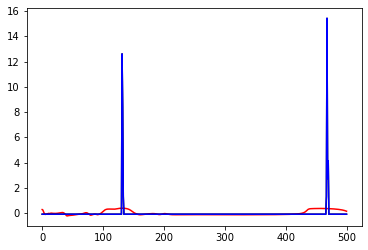

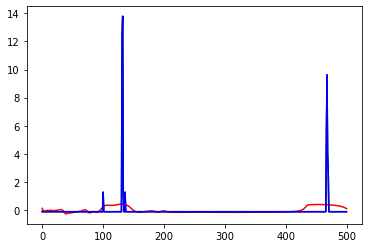

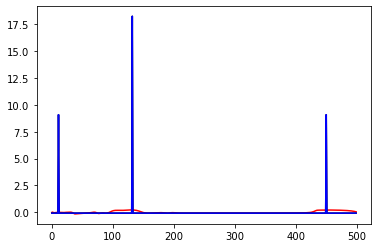

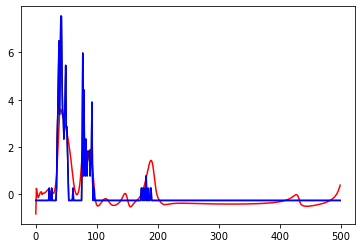

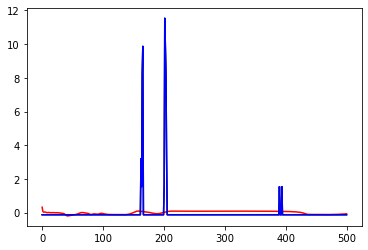

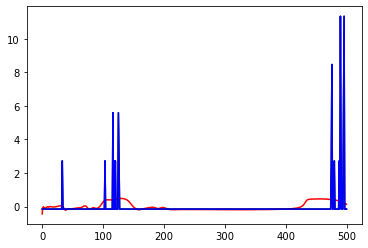

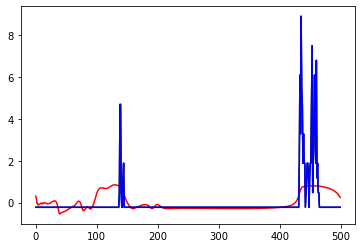

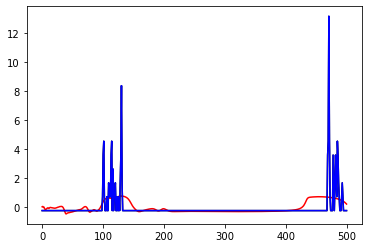

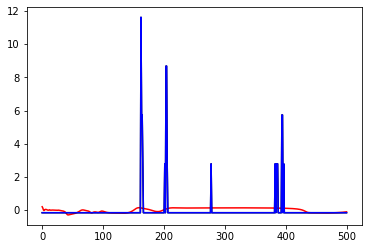

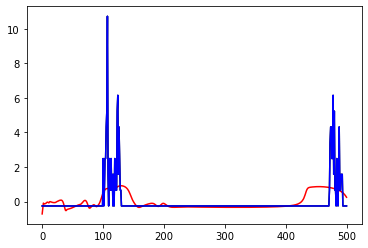

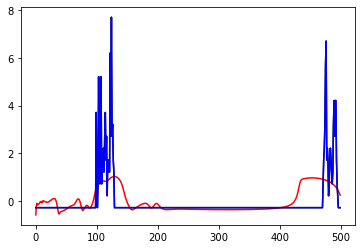

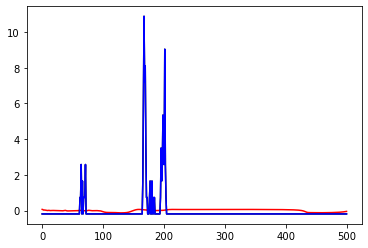

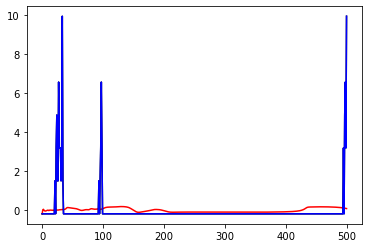

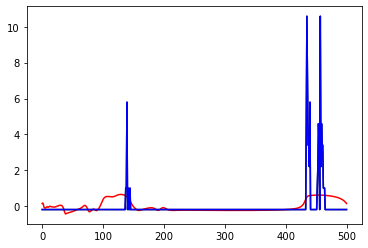

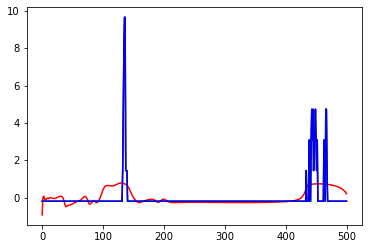

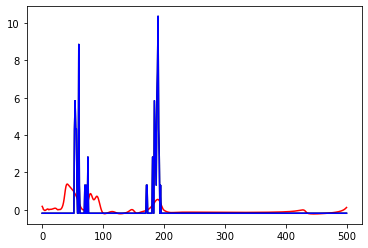

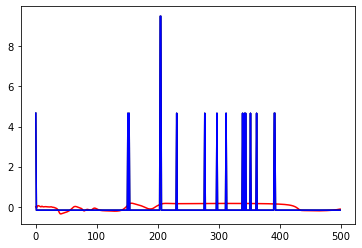

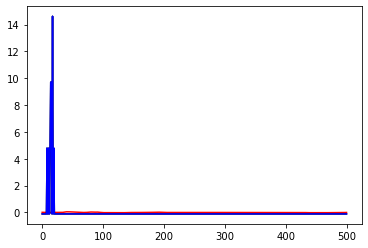

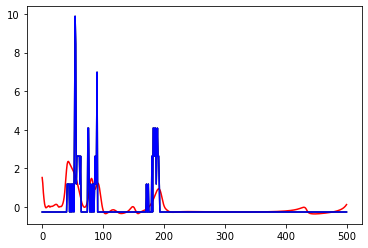

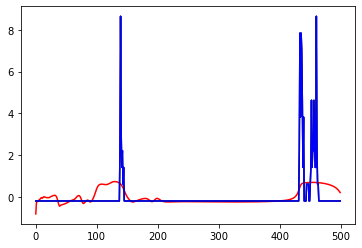

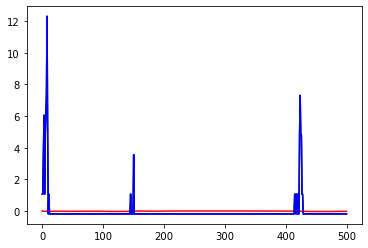

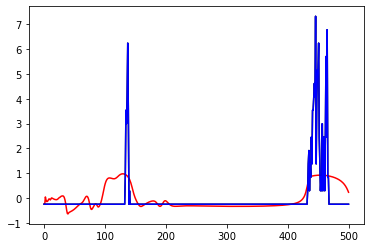

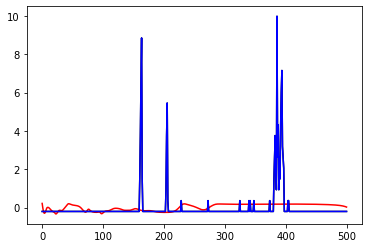

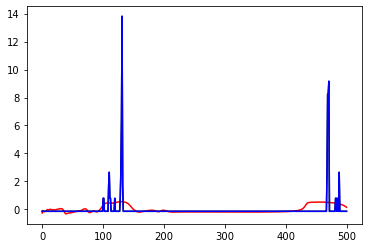

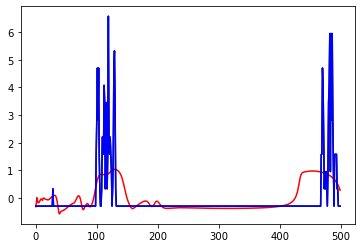

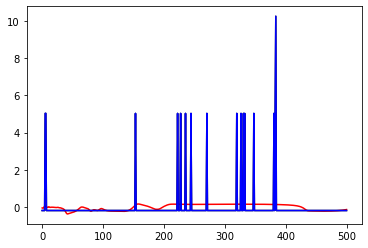

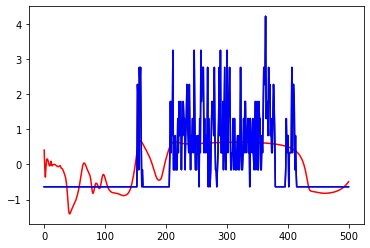

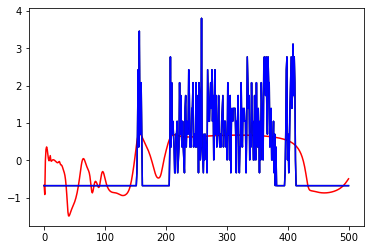

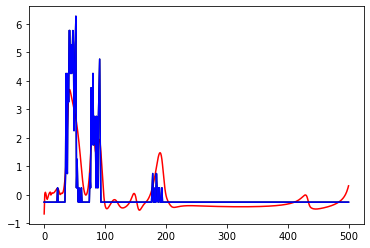

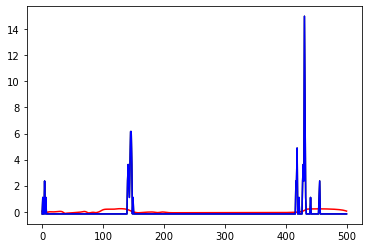

In [16]:
print(vae(x_batch_train).shape)
for i in range(neuron_num):
    plt.figure()
    plt.plot(vae(x_batch_train)[0,:,i],"r")
    plt.plot(output[0,:,i],'k')
    plt.plot(x_batch_train[0,:,i],'b')

# Evaluate Quality of reconstruction 

(1, 500, 30)
(1, 500, 2)
(500, 2)
(500, 2)


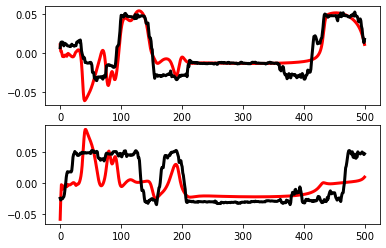

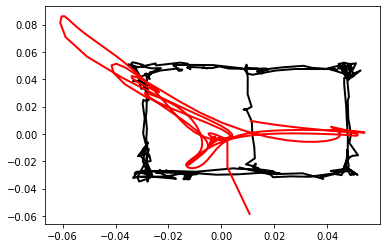

In [17]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')